In [ ]:
conda install -c bioconda trim-galore
https://github.com/FelixKrueger/TrimGalore/blob/master/Docs/Trim_Galore_User_Guide.md

trim_galore \
--illumina \
--paired \
--fastqc \
-o trim_galore/ \
CHK_AAAAOSDA_4_1_CC9G4ACXX.12BA001_clean.fastq.gz \
CHK_AAAAOSDA_4_2_CC9G4ACXX.12BA001_clean.fastq.gz

In [ ]:
https://github.com/ablab/spades
conda install -n anvio5 -c bioconda spades 

#!/bin/bash
#PBS -V # set verbose output
#PBS -N DASTool
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/SAGs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate anvio5
for i in $(cat filenames.txt);
do cd $i;
spades.py --sc \
-1 *_1_* \
-2 *_2_* \
--threads 16 \
-o assembly;
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/SAGs;
done

In [ ]:
for i in $(cat foldernames.txt);
do cd $i/assembly;
cp contigs.fasta ../../assembly/$i-contigs.fasta;
cd ../../;
done

ls -l | wc -l

In [ ]:
from Bio import SeqIO
import glob

file_list = glob.glob('*contigs.fasta')
for f in file_list:
	records_to_keep = [x for x in SeqIO.parse(f, 'fasta') if len(x.seq)>=10000]
	SeqIO.write(records_to_keep, f, 'fasta')

In [ ]:
from Bio import SeqIO
import glob
import os

file_list = glob.glob('*contigs.fasta')
for f in file_list:
    base_name = os.path.basename(f)
    new_filename = '%s.filtered.10k.fa' % base_name
    records_to_keep = [x for x in SeqIO.parse(f, 'fasta') if len(x.seq)>=10000]
    SeqIO.write(records_to_keep, new_filename, 'fasta')

In [ ]:
parallel anvi-script-reformat-fasta \
-o ./renamed/{1}.renamed.fa \
--simplify-names \
--prefix {1} \
-r ./renamed/{1}.mapping.txt {1}-contigs.fasta :::: names.txt

In [ ]:
#for VirSorter
cat *.renamed.fa > ../combined.renamed.10k.SAGs.fa

In [ ]:
anvi-script-reformat-fasta \
combined_SAGs_contigs.fa \
-o reformatted-combined-SAGs-contigs.fa \
-l 500 \
--simplify-names

In [ ]:
http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml
    
#build bowtie index file named $SAMPLE_NAME
bowtie2-build all-sag-contigs.fa SAGs

#!/bin/bash
#PBS -V # set verbose output
#PBS -N sags-mappings
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=32 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=highmem # High Memory

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling
OUT_DIR=$PROJECT_HOME/mappings
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/shared_store/biller_reads

SAMPLE_NAME=SAGs

MAPPING_LOGFILE=$OUT_DIR/$SAMPLE_NAME.log

cd $PROJECT_HOME

for i in $(cat $PROJECT_HOME/filenames.txt); 
do source activate anvio5; 
bowtie2 --threads 32 -x $PROJECT_HOME/$SAMPLE_NAME -1 $READS/$i.fwd* -2 $READS/$i.rev* --no-unal -S $SAMPLE_NAME.$i.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$i.sam > $SAMPLE_NAME.vs.$i.raw.bam;
samtools sort $SAMPLE_NAME.vs.$i.raw.bam -o $SAMPLE_NAME.vs.$i.sorted.bam;
samtools index $SAMPLE_NAME.vs.$i.sorted.bam;

source activate bamm;

bamm filter -b $SAMPLE_NAME.vs.$i.sorted.bam --percentage_id 0.95 2>&1 | tee -a $MAPPING_LOGFILE;

samtools sort -@ 32 -o $SAMPLE_NAME.vs.$i.sorted.95pc.bam $SAMPLE_NAME.vs.$i.sorted_filtered.bam;

samtools index $SAMPLE_NAME.vs.$i.sorted.95pc.bam;
mv $SAMPLE_NAME.vs.$i.sorted.95pc.bam* $OUT_DIR;

rm *$SAMPLE_NAME.vs.$i*;
rm *$SAMPLE_NAME.$i.sam;
done

In [ ]:
#checkM
#https://github.com/Ecogenomics/CheckM/wiki/Genome-Quality-Commands

PATH=$PATH:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/Prodigal
source activate py27

checkm lineage_wf assemblies/ output/

cd SAGs/
checkm taxon_set order Rickettsiales Rickettsiales_markers
checkm analyze Rickettsiales_markers assembly/ output2 -x fasta -t 16
checkm qa --out_format 9 --file results_file.txt --tab_table -t 16 Rickettsiales_markers output2

checkm taxon_list | egrep "Pelagi*|Rickett*|SAR*|sar*|Sar*"
checkm taxon_set family Pelagibacteraceae Pelagibacteraceae_markers
checkm analyze Pelagibacteraceae_markers ./ checkm_output_pelagi -x fasta -t 16
checkm qa --out_format 2 --file checkm_output_pelagi/completeness_stats.txt --tab_table -t 16 Pelagibacteraceae_markers checkm_output_pelagi

In [ ]:
source activate bamm
bamm parse \
--coverages sags-coverage.tsv \
--coverage_mode tpmean \
--bamfiles *.bam \
--threads 16 \

In [ ]:
#output file needs to be transposed so grep can get each biller reads for bats, hots ...etc
#desktop

cd ~/projects/heatmaps/sags
rsync agb214@login.isca.ex.ac.uk:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling/mappings/sags-coverage.tsv .
python
import pandas as pd
df = pd.read_csv("sags-coverage.tsv", sep = "\t")
df #check import
df = df.transpose()
df #check transpose
df.to_csv("sags-coverage-transposed.tsv", sep = "\t")
*ctrl+d*

cat sags-coverage-transposed.tsv | egrep "contig|SRR5720219|SRR5720220|SRR5720221|SRR5720222|SRR5720223|SRR5720224|SRR5720225|SRR5720226|SRR5720227|SRR5720228|SRR5720239|SRR5720240|SRR5720241|SRR5720242|SRR5720243|SRR5720244|SRR5720245|SRR5720246|SRR5720247|SRR5720248|SRR5720265|SRR5720266|SRR5720267|SRR5720268|SRR5720269|SRR5720270|SRR5720271|SRR5720272|SRR5720273|SRR5720274|SRR5720287|SRR5720288|SRR5720289|SRR5720290|SRR5720291|SRR5720292|SRR5720293|SRR5720294|SRR5720295|SRR5720296|SRR5720297|SRR5720298|SRR5720299|SRR5720300|SRR5720301|SRR5720302|SRR5720303|SRR5720304|SRR5720305|SRR5720306|SRR5720308|SRR5720309|SRR5720310|SRR5720311|SRR5720312|SRR5720313|SRR5720314|SRR5720315|SRR5720316|SRR5720317|SRR5720324|SRR5720325|SRR5720328|SRR5720329|SRR5720330|SRR5720331|SRR6507277|SRR6507278" > sags-hots-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5720229|SRR5720230|SRR5720231|SRR5720232|SRR5720233|SRR5720234|SRR5720235|SRR5720236|SRR5720237|SRR5720238|SRR5720249|SRR5720250|SRR5720251|SRR5720252|SRR5720253|SRR5720254|SRR5720255|SRR5720256|SRR5720257|SRR5720258|SRR5720259|SRR5720260|SRR5720261|SRR5720262|SRR5720263|SRR5720264|SRR5720275|SRR5720276|SRR5720277|SRR5720278|SRR5720279|SRR5720280|SRR5720281|SRR5720282|SRR5720283|SRR5720284|SRR5720285|SRR5720286|SRR5720307|SRR5720318|SRR5720319|SRR5720320|SRR5720321|SRR5720322|SRR5720323|SRR5720326|SRR5720327|SRR5720332|SRR5720333|SRR5720334|SRR5720335|SRR5720336|SRR5720337|SRR5720338|SRR5720339|SRR5720340|SRR5720341|SRR5720342|SRR5720343|SRR5720344|SRR6507279|SRR6507280" > sags-bats-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787989|SRR5787990|SRR5787992|SRR5787999|SRR5788000|SRR5788002|SRR5788015|SRR5788016|SRR5788017|SRR5788018|SRR5788019|SRR5788020|SRR5788021|SRR5788022|SRR5788023|SRR5788024|SRR5788047|SRR5788048|SRR5788059|SRR5788060|SRR5788099|SRR5788100|SRR5788103|SRR5788104|SRR5788105|SRR5788106|SRR5788108|SRR5788109|SRR5788110|SRR5788111|SRR5788112|SRR5788113|SRR5788114|SRR5788115|SRR5788116|SRR5788117|SRR5788140|SRR5788144|SRR5788145|SRR5788146|SRR5788147|SRR5788180|SRR5788181|SRR5788182|SRR5788183|SRR5788184|SRR5788185|SRR5788186|SRR5788187|SRR5788188|SRR5788189|SRR5788190|SRR5788192|SRR5788193|SRR5788194|SRR5788195|SRR5788196|SRR5788197|SRR5788198|SRR5788199|SRR5788200|SRR5788201|SRR5788229|SRR5788230|SRR5788231|SRR5788232|SRR5788233|SRR5788234|SRR5788235|SRR5788236|SRR5788237|SRR5788238|SRR5788256|SRR5788281|SRR5788282|SRR5788283|SRR5788284|SRR5788285|SRR5788286|SRR5788287|SRR5788288|SRR5788289|SRR5788290|SRR5788345|SRR5788346|SRR5788347|SRR5788348|SRR5788349|SRR5788350|SRR5788351|SRR5788352|SRR5788353|SRR5788354|SRR5788365|SRR5788366|SRR5788367|SRR5788368|SRR5788369|SRR5788370|SRR5788371|SRR5788372|SRR5788373|SRR5788374|SRR5788375|SRR5788376|SRR5788377|SRR5788378|SRR5788379|SRR5788380|SRR5788381|SRR5788382|SRR5788383|SRR5788384|SRR5788387|SRR5788427|SRR5788428|SRR5788429|SRR5788430|SRR5788431|SRR5788432|SRR5788433|SRR5788434|SRR5788435|SRR5788436|SRR5788447|SRR5788467|SRR5788468" > sags-ga02-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787993|SRR5787994|SRR5788005|SRR5788006|SRR5788007|SRR5788008|SRR5788009|SRR5788010|SRR5788011|SRR5788012|SRR5788013|SRR5788014|SRR5788025|SRR5788036|SRR5788061|SRR5788062|SRR5788063|SRR5788064|SRR5788065|SRR5788066|SRR5788067|SRR5788068|SRR5788069|SRR5788070|SRR5788081|SRR5788082|SRR5788083|SRR5788084|SRR5788085|SRR5788086|SRR5788087|SRR5788088|SRR5788089|SRR5788090|SRR5788107|SRR5788138|SRR5788139|SRR5788141|SRR5788142|SRR5788143|SRR5788168|SRR5788169|SRR5788172|SRR5788173|SRR5788174|SRR5788175|SRR5788204|SRR5788213|SRR5788214|SRR5788215|SRR5788216|SRR5788217|SRR5788218|SRR5788219|SRR5788220|SRR5788221|SRR5788222|SRR5788223|SRR5788224|SRR5788225|SRR5788226|SRR5788227|SRR5788228|SRR5788249|SRR5788250|SRR5788251|SRR5788252|SRR5788253|SRR5788254|SRR5788312|SRR5788313|SRR5788314|SRR5788315|SRR5788316|SRR5788317|SRR5788318|SRR5788319|SRR5788320|SRR5788321|SRR5788322|SRR5788323|SRR5788335|SRR5788336|SRR5788337|SRR5788338|SRR5788339|SRR5788340|SRR5788341|SRR5788342|SRR5788343|SRR5788344|SRR5788407|SRR5788408|SRR5788409|SRR5788410|SRR5788411|SRR5788412|SRR5788413|SRR5788414|SRR5788425|SRR5788426|SRR5788448|SRR5788449|SRR5788450|SRR5788451|SRR5788452|SRR5788453|SRR5788454|SRR5788455|SRR5788456|SRR5788463|SRR5788464|SRR5788465|SRR5788466" > sags-ga03-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5788026|SRR5788027|SRR5788028|SRR5788029|SRR5788030|SRR5788031|SRR5788032|SRR5788033|SRR5788034|SRR5788035|SRR5788071|SRR5788072|SRR5788073|SRR5788074|SRR5788075|SRR5788076|SRR5788077|SRR5788078|SRR5788079|SRR5788080|SRR5788130|SRR5788131|SRR5788136|SRR5788137|SRR5788202|SRR5788203|SRR5788205|SRR5788206|SRR5788207|SRR5788208|SRR5788209|SRR5788210|SRR5788211|SRR5788212|SRR5788302|SRR5788303|SRR5788304|SRR5788305|SRR5788306|SRR5788307|SRR5788308|SRR5788309|SRR5788310|SRR5788311|SRR5788437|SRR5788438|SRR5788439|SRR5788440|SRR5788441|SRR5788442|SRR5788443|SRR5788444|SRR5788445|SRR5788446" > sags-ga10-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787991|SRR5787995|SRR5787996|SRR5787997|SRR5787998|SRR5788001|SRR5788003|SRR5788004|SRR5788037|SRR5788038|SRR5788039|SRR5788040|SRR5788041|SRR5788042|SRR5788043|SRR5788044|SRR5788045|SRR5788046|SRR5788049|SRR5788050|SRR5788051|SRR5788052|SRR5788053|SRR5788054|SRR5788055|SRR5788056|SRR5788057|SRR5788058|SRR5788091|SRR5788092|SRR5788093|SRR5788094|SRR5788095|SRR5788096|SRR5788097|SRR5788098|SRR5788101|SRR5788102|SRR5788118|SRR5788119|SRR5788120|SRR5788121|SRR5788122|SRR5788123|SRR5788124|SRR5788125|SRR5788126|SRR5788127|SRR5788128|SRR5788129|SRR5788132|SRR5788133|SRR5788134|SRR5788135|SRR5788148|SRR5788149|SRR5788150|SRR5788151|SRR5788152|SRR5788153|SRR5788154|SRR5788155|SRR5788156|SRR5788157|SRR5788158|SRR5788159|SRR5788160|SRR5788161|SRR5788162|SRR5788163|SRR5788164|SRR5788165|SRR5788166|SRR5788167|SRR5788170|SRR5788171|SRR5788176|SRR5788177|SRR5788178|SRR5788179|SRR5788191|SRR5788239|SRR5788240|SRR5788241|SRR5788242|SRR5788243|SRR5788244|SRR5788245|SRR5788246|SRR5788247|SRR5788248|SRR5788255|SRR5788257|SRR5788258|SRR5788259|SRR5788260|SRR5788261|SRR5788262|SRR5788263|SRR5788264|SRR5788265|SRR5788266|SRR5788267|SRR5788268|SRR5788269|SRR5788270|SRR5788271|SRR5788272|SRR5788273|SRR5788274|SRR5788275|SRR5788276|SRR5788277|SRR5788278|SRR5788279|SRR5788280|SRR5788291|SRR5788292|SRR5788293|SRR5788294|SRR5788295|SRR5788296|SRR5788297|SRR5788298|SRR5788299|SRR5788300|SRR5788301|SRR5788324|SRR5788325|SRR5788326|SRR5788327|SRR5788328|SRR5788329|SRR5788330|SRR5788331|SRR5788332|SRR5788333|SRR5788334|SRR5788355|SRR5788356|SRR5788357|SRR5788358|SRR5788359|SRR5788360|SRR5788361|SRR5788362|SRR5788363|SRR5788364|SRR5788385|SRR5788386|SRR5788388|SRR5788389|SRR5788390|SRR5788391|SRR5788392|SRR5788393|SRR5788394|SRR5788395|SRR5788396|SRR5788397|SRR5788398|SRR5788399|SRR5788400|SRR5788401|SRR5788402|SRR5788403|SRR5788404|SRR5788405|SRR5788406|SRR5788415|SRR5788416|SRR5788417|SRR5788418|SRR5788419|SRR5788420|SRR5788421|SRR5788422|SRR5788423|SRR5788424|SRR5788457|SRR5788458|SRR5788459|SRR5788460|SRR5788461|SRR5788462" > sags-ga13-coverage.tsv


cat Biller-data-metadata.tsv | egrep "contig|SRR5720219|SRR5720220|SRR5720221|SRR5720222|SRR5720223|SRR5720224|SRR5720225|SRR5720226|SRR5720227|SRR5720228|SRR5720239|SRR5720240|SRR5720241|SRR5720242|SRR5720243|SRR5720244|SRR5720245|SRR5720246|SRR5720247|SRR5720248|SRR5720265|SRR5720266|SRR5720267|SRR5720268|SRR5720269|SRR5720270|SRR5720271|SRR5720272|SRR5720273|SRR5720274|SRR5720287|SRR5720288|SRR5720289|SRR5720290|SRR5720291|SRR5720292|SRR5720293|SRR5720294|SRR5720295|SRR5720296|SRR5720297|SRR5720298|SRR5720299|SRR5720300|SRR5720301|SRR5720302|SRR5720303|SRR5720304|SRR5720305|SRR5720306|SRR5720308|SRR5720309|SRR5720310|SRR5720311|SRR5720312|SRR5720313|SRR5720314|SRR5720315|SRR5720316|SRR5720317|SRR5720324|SRR5720325|SRR5720328|SRR5720329|SRR5720330|SRR5720331|SRR6507277|SRR6507278" > biller_hots_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5720229|SRR5720230|SRR5720231|SRR5720232|SRR5720233|SRR5720234|SRR5720235|SRR5720236|SRR5720237|SRR5720238|SRR5720249|SRR5720250|SRR5720251|SRR5720252|SRR5720253|SRR5720254|SRR5720255|SRR5720256|SRR5720257|SRR5720258|SRR5720259|SRR5720260|SRR5720261|SRR5720262|SRR5720263|SRR5720264|SRR5720275|SRR5720276|SRR5720277|SRR5720278|SRR5720279|SRR5720280|SRR5720281|SRR5720282|SRR5720283|SRR5720284|SRR5720285|SRR5720286|SRR5720307|SRR5720318|SRR5720319|SRR5720320|SRR5720321|SRR5720322|SRR5720323|SRR5720326|SRR5720327|SRR5720332|SRR5720333|SRR5720334|SRR5720335|SRR5720336|SRR5720337|SRR5720338|SRR5720339|SRR5720340|SRR5720341|SRR5720342|SRR5720343|SRR5720344|SRR6507279|SRR6507280" > biller_bats_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787989|SRR5787990|SRR5787992|SRR5787999|SRR5788000|SRR5788002|SRR5788015|SRR5788016|SRR5788017|SRR5788018|SRR5788019|SRR5788020|SRR5788021|SRR5788022|SRR5788023|SRR5788024|SRR5788047|SRR5788048|SRR5788059|SRR5788060|SRR5788099|SRR5788100|SRR5788103|SRR5788104|SRR5788105|SRR5788106|SRR5788108|SRR5788109|SRR5788110|SRR5788111|SRR5788112|SRR5788113|SRR5788114|SRR5788115|SRR5788116|SRR5788117|SRR5788140|SRR5788144|SRR5788145|SRR5788146|SRR5788147|SRR5788180|SRR5788181|SRR5788182|SRR5788183|SRR5788184|SRR5788185|SRR5788186|SRR5788187|SRR5788188|SRR5788189|SRR5788190|SRR5788192|SRR5788193|SRR5788194|SRR5788195|SRR5788196|SRR5788197|SRR5788198|SRR5788199|SRR5788200|SRR5788201|SRR5788229|SRR5788230|SRR5788231|SRR5788232|SRR5788233|SRR5788234|SRR5788235|SRR5788236|SRR5788237|SRR5788238|SRR5788256|SRR5788281|SRR5788282|SRR5788283|SRR5788284|SRR5788285|SRR5788286|SRR5788287|SRR5788288|SRR5788289|SRR5788290|SRR5788345|SRR5788346|SRR5788347|SRR5788348|SRR5788349|SRR5788350|SRR5788351|SRR5788352|SRR5788353|SRR5788354|SRR5788365|SRR5788366|SRR5788367|SRR5788368|SRR5788369|SRR5788370|SRR5788371|SRR5788372|SRR5788373|SRR5788374|SRR5788375|SRR5788376|SRR5788377|SRR5788378|SRR5788379|SRR5788380|SRR5788381|SRR5788382|SRR5788383|SRR5788384|SRR5788387|SRR5788427|SRR5788428|SRR5788429|SRR5788430|SRR5788431|SRR5788432|SRR5788433|SRR5788434|SRR5788435|SRR5788436|SRR5788447|SRR5788467|SRR5788468" > biller_ga02_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787993|SRR5787994|SRR5788005|SRR5788006|SRR5788007|SRR5788008|SRR5788009|SRR5788010|SRR5788011|SRR5788012|SRR5788013|SRR5788014|SRR5788025|SRR5788036|SRR5788061|SRR5788062|SRR5788063|SRR5788064|SRR5788065|SRR5788066|SRR5788067|SRR5788068|SRR5788069|SRR5788070|SRR5788081|SRR5788082|SRR5788083|SRR5788084|SRR5788085|SRR5788086|SRR5788087|SRR5788088|SRR5788089|SRR5788090|SRR5788107|SRR5788138|SRR5788139|SRR5788141|SRR5788142|SRR5788143|SRR5788168|SRR5788169|SRR5788172|SRR5788173|SRR5788174|SRR5788175|SRR5788204|SRR5788213|SRR5788214|SRR5788215|SRR5788216|SRR5788217|SRR5788218|SRR5788219|SRR5788220|SRR5788221|SRR5788222|SRR5788223|SRR5788224|SRR5788225|SRR5788226|SRR5788227|SRR5788228|SRR5788249|SRR5788250|SRR5788251|SRR5788252|SRR5788253|SRR5788254|SRR5788312|SRR5788313|SRR5788314|SRR5788315|SRR5788316|SRR5788317|SRR5788318|SRR5788319|SRR5788320|SRR5788321|SRR5788322|SRR5788323|SRR5788335|SRR5788336|SRR5788337|SRR5788338|SRR5788339|SRR5788340|SRR5788341|SRR5788342|SRR5788343|SRR5788344|SRR5788407|SRR5788408|SRR5788409|SRR5788410|SRR5788411|SRR5788412|SRR5788413|SRR5788414|SRR5788425|SRR5788426|SRR5788448|SRR5788449|SRR5788450|SRR5788451|SRR5788452|SRR5788453|SRR5788454|SRR5788455|SRR5788456|SRR5788463|SRR5788464|SRR5788465|SRR5788466" > biller_ga03_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5788026|SRR5788027|SRR5788028|SRR5788029|SRR5788030|SRR5788031|SRR5788032|SRR5788033|SRR5788034|SRR5788035|SRR5788071|SRR5788072|SRR5788073|SRR5788074|SRR5788075|SRR5788076|SRR5788077|SRR5788078|SRR5788079|SRR5788080|SRR5788130|SRR5788131|SRR5788136|SRR5788137|SRR5788202|SRR5788203|SRR5788205|SRR5788206|SRR5788207|SRR5788208|SRR5788209|SRR5788210|SRR5788211|SRR5788212|SRR5788302|SRR5788303|SRR5788304|SRR5788305|SRR5788306|SRR5788307|SRR5788308|SRR5788309|SRR5788310|SRR5788311|SRR5788437|SRR5788438|SRR5788439|SRR5788440|SRR5788441|SRR5788442|SRR5788443|SRR5788444|SRR5788445|SRR5788446" > biller_ga10_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787991|SRR5787995|SRR5787996|SRR5787997|SRR5787998|SRR5788001|SRR5788003|SRR5788004|SRR5788037|SRR5788038|SRR5788039|SRR5788040|SRR5788041|SRR5788042|SRR5788043|SRR5788044|SRR5788045|SRR5788046|SRR5788049|SRR5788050|SRR5788051|SRR5788052|SRR5788053|SRR5788054|SRR5788055|SRR5788056|SRR5788057|SRR5788058|SRR5788091|SRR5788092|SRR5788093|SRR5788094|SRR5788095|SRR5788096|SRR5788097|SRR5788098|SRR5788101|SRR5788102|SRR5788118|SRR5788119|SRR5788120|SRR5788121|SRR5788122|SRR5788123|SRR5788124|SRR5788125|SRR5788126|SRR5788127|SRR5788128|SRR5788129|SRR5788132|SRR5788133|SRR5788134|SRR5788135|SRR5788148|SRR5788149|SRR5788150|SRR5788151|SRR5788152|SRR5788153|SRR5788154|SRR5788155|SRR5788156|SRR5788157|SRR5788158|SRR5788159|SRR5788160|SRR5788161|SRR5788162|SRR5788163|SRR5788164|SRR5788165|SRR5788166|SRR5788167|SRR5788170|SRR5788171|SRR5788176|SRR5788177|SRR5788178|SRR5788179|SRR5788191|SRR5788239|SRR5788240|SRR5788241|SRR5788242|SRR5788243|SRR5788244|SRR5788245|SRR5788246|SRR5788247|SRR5788248|SRR5788255|SRR5788257|SRR5788258|SRR5788259|SRR5788260|SRR5788261|SRR5788262|SRR5788263|SRR5788264|SRR5788265|SRR5788266|SRR5788267|SRR5788268|SRR5788269|SRR5788270|SRR5788271|SRR5788272|SRR5788273|SRR5788274|SRR5788275|SRR5788276|SRR5788277|SRR5788278|SRR5788279|SRR5788280|SRR5788291|SRR5788292|SRR5788293|SRR5788294|SRR5788295|SRR5788296|SRR5788297|SRR5788298|SRR5788299|SRR5788300|SRR5788301|SRR5788324|SRR5788325|SRR5788326|SRR5788327|SRR5788328|SRR5788329|SRR5788330|SRR5788331|SRR5788332|SRR5788333|SRR5788334|SRR5788355|SRR5788356|SRR5788357|SRR5788358|SRR5788359|SRR5788360|SRR5788361|SRR5788362|SRR5788363|SRR5788364|SRR5788385|SRR5788386|SRR5788388|SRR5788389|SRR5788390|SRR5788391|SRR5788392|SRR5788393|SRR5788394|SRR5788395|SRR5788396|SRR5788397|SRR5788398|SRR5788399|SRR5788400|SRR5788401|SRR5788402|SRR5788403|SRR5788404|SRR5788405|SRR5788406|SRR5788415|SRR5788416|SRR5788417|SRR5788418|SRR5788419|SRR5788420|SRR5788421|SRR5788422|SRR5788423|SRR5788424|SRR5788457|SRR5788458|SRR5788459|SRR5788460|SRR5788461|SRR5788462" > biller_ga13_metadata.tsv

#transform these all back into the non transposed form
python
import pandas as pd
df = pd.read_csv("sags-hots-coverage.tsv", sep = "\t")



In [ ]:
source activate anvio5

for i in $(cat contig-names.txt);
do anvi-script-reformat-fasta $i-contigs.fasta -o $i-contigs-renamed.fasta --simplify-names --prefix $i -r $i-mappings.txt;
done

for i in $(cat contig-names.txt);
do barrnap $i-contigs.fasta --kingdom bac --threads 16 --outseq $i-ribosomal.txt;
done

In [ ]:
cat *-ribosomal.txt | egrep "5S_rRNA|23S_rRNA" > all_ribsomal_RNA.txt
open in excel and sep by ">_-(),:"
statment =IF((D2=D3)AND(C2=C3))OR((D1=D2)AND(C1=C2)) provides TRUE if on same contig. Sort by TRUE after paste special

In [20]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/5S_rRNA_sstart_send.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[0:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_sstart_to_5S_region", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [21]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/23S_rRNA_sstart_send.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:99999999999]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_region_to_send", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [22]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/sag-variable-region.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_to_5S", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s_5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [ ]:
#!/bin/bash
#PBS -V # set verbose output
#PBS -N sags-self-mappings
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=32 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5
PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags
OUT_DIR=$PROJECT_HOME/self_mappings
SAMPLE_NAME=SAGs

for sag in $(cat sag_names.txt); do
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/$sag;
MAPPING_LOGFILE=$OUT_DIR/$sag.log;
cd $READS;
bowtie2-build /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/renamed/$sag-contigs-renamed.fasta SAGs 2>&1 | tee -a $MAPPING_LOGFILE;
bowtie2 --threads 32 -x $SAMPLE_NAME -1 *_1_* -2 *_2_* --no-unal -S $SAMPLE_NAME.$sag.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$sag.sam > $SAMPLE_NAME.vs.$sag.raw.bam;
samtools sort $SAMPLE_NAME.vs.$sag.raw.bam -o $SAMPLE_NAME.vs.$sag.sorted.bam;
samtools index $SAMPLE_NAME.vs.$sag.sorted.bam;

mv $SAMPLE_NAME.vs.$sag.sorted.bam* $OUT_DIR;
rm *$SAMPLE_NAME*;
cd $PROJECT_HOME;
done

In [ ]:
source activate anvio5
for i in $(cat 23s-vr-5s-contigs.txt); do
coverageBed -d -a 23s-vr-5s.bed -b ../*$i.sorted.bam | grep "$i" > $i-23s-vr-5s-coverage.tsv;
done

source activate anvio5
for i in $(cat vr-5s-contigs.txt); do
coverageBed -d -a vr-5s.bed -b ../*$i.sorted.bam | grep "$i" > $i-vr-5s-coverage.tsv;
done

source activate anvio5
for i in $(cat 23s-vr-contigs.txt); do
coverageBed -d -a 23s-vr.bed -b ../*$i.sorted.bam | grep "$i" > $i-23s-vr-coverage.tsv;
done

In [299]:
import pandas as pd
import numpy as np
import glob

variance = []
path = "/home/minion/projects/SAGs/coverage/23s_5s/AA*.tsv"
for filename in glob.glob(path):
    df = pd.read_csv(filename, sep="\t", 
                     names=['contig', 'sstart', 'send', 'count', 'coverage'])
    df = df[df.coverage !=0]
    data = pd.DataFrame([df.contig[0], df.loc[:,"coverage"].var(), len(df)])
    variance.append(data)
variance = pd.concat(variance, axis=1)
variance = variance.transpose()
print(variance)
#variance.to_csv("/home/minion/projects/SAGs/abc.tsv", sep="\t", header = None, index = False)

                   0        1      2
0  AAEK_000000000002  7302.29  34116
0  AAJO_000000000001  127.092  49069
0  AAAY_000000000002  54052.9  23611
0  AAPZ_000000000001  386.792  45666
0  AAOA_000000000001  12298.1  52323
0  AADH_000000000002   129795  29983
0  AAIN_000000000005  6024.75  12814
0  AABC_000000000003  2097.83   2944
0  AAHL_000000000001  16151.9  33403
0  AAOI_000000000002  298.711  33180
0  AAET_000000000002  1404.44  13418
0  AABE_000000000001  972.025  41077
0  AAAU_000000000009  439.603   2939
0  AABL_000000000001  86.4188   2940
0  AAGM_000000000001  8599.28  42311
0  AAIZ_000000000002  24424.6  45343
0  AAHY_000000000005  1241.11  23470
0  AAPE_000000000002   374592  90206
0  AACI_000000000001  26266.2  52174
0  AANY_000000000002  3026.73  56468
0  AAFX_000000000001  2029.52  61945
0  AABZ_000000000002  7019.81  12535
0  AAHK_000000000002  4991.65  55433
0  AAPB_000000000002  12609.8  43614
0  AAHI_000000000001  793.596  56747
0  AAPR_000000000001  2349.87  51777
0

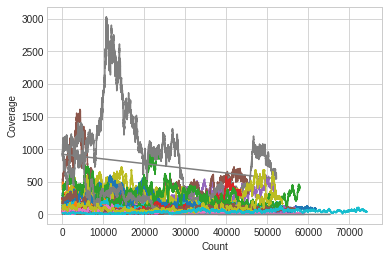

In [297]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

path = "/home/minion/projects/SAGs/coverage/23s_5s/*.tsv"
for filename in glob.glob(path):
    df = pd.read_csv(filename, sep="\t", 
                     names=['contig', 'sstart', 'send', 'count', 'coverage'])
    x = df["count"]
    y = df["coverage"].replace(np.nan, 0)
    plt.plot(x, y);
    plt.xlabel("Count")
    plt.ylabel("Coverage")

In [ ]:
#after barrnapp 
cat *.txt | egrep ">23S|>5S" > all-ribosomes.txt
# to get all the names of the ribosome locations into one file

In [17]:
import pandas as pd
df = pd.read_csv("/home/minion/Desktop/sags/all-ribosomes.txt", header = None)
df1 = df[0].str.split(">", expand = True)
df2 = df1[1].str.split(":", expand = True)
df3 = df2[3].str.split("-", n=1, expand = True)
df4 = df3[1].str.split(")", expand = True)
df5 = df4[0].str.split("(", expand = True)
df7 = df2[2].str.split("_", expand = True)


#df6 = result.duplicated(subset="contig", keep=False)

#df = pd.concat([df7[0], df2[0], df2[2], df3[0], df5, df6], axis=1, join="inner")
#df.columns = ["genome","ribosome", "contig", "sstart", "send", "strand", "duplicate_contig"]

#sags = pd.read_csv("/home/minion/Desktop/sags/sag_genome_addresses.csv", sep = '\t')
#sags.set_index("genome", inplace = True)
#df.set_index("genome", inplace = True)
#abc=df.join(sags)
#abc

KeyError: Index(['contig'], dtype='object')

In [229]:
duplicate_true = abc.loc[abc.duplicate_contig==True]
duplicate_true.reset_index(drop=True, inplace=True)
duplicate_false = abc.loc[abc.duplicate_contig==False]
duplicate_false.reset_index(drop=True, inplace=True)

duplicate_false

int(duplicate_false.index)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'RangeIndex'

In [235]:
thisdict=duplicate_false.to_dict('index')
thisdict[3]


{'ribosome': '23S_rRNA',
 'contig': 'AAAF_000000000007',
 'sstart': '8088',
 'send': '10837',
 'strand': '-',
 'duplicate_contig': False,
 'address': '/home/minion/projects/SAGs/SAG_contigs/AAAF-contigs-renamed.fasta'}

In [256]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

for x, y in thisdict.items():
    if thisdict[x]['ribosome'] == '23S_rRNA':
        i = max(int(thisdict[x]['sstart']), int(thisdict[x]['send']))
        records = list(SeqIO.parse(thisdict[x]["address"], "fasta"))
        
        
        print(records)
        
#        record_dict = SeqIO.index(thisdict[x]["address"], "fasta")
#        sequences = record_dict[thisdict[x]["contig"].seq
#SeqIO.write(sequences, "example.fasta", "fasta")


[SeqRecord(seq=Seq('CATTTATCGCTATCTGAGATTTTTTAATAGTAAATTCCTTTTACAATTTTAGAA...TAT', SingleLetterAlphabet()), id='AAAB_000000000001', name='AAAB_000000000001', description='AAAB_000000000001', dbxrefs=[]), SeqRecord(seq=Seq('AATTGATTTTGCTATTGCTTCAGCTTGCCCCCTTTCATTCATAATTGGGACAAC...TTA', SingleLetterAlphabet()), id='AAAB_000000000002', name='AAAB_000000000002', description='AAAB_000000000002', dbxrefs=[]), SeqRecord(seq=Seq('TTGGATTAATGCTAATATTTTTATTTTTTACATATCAAATATTTAAAAAATTAT...AGA', SingleLetterAlphabet()), id='AAAB_000000000003', name='AAAB_000000000003', description='AAAB_000000000003', dbxrefs=[]), SeqRecord(seq=Seq('TAACAATAAACTGCTTTAATTTTTTTATAGTTTTTTGAAATATAGGTAGCGGTG...ACT', SingleLetterAlphabet()), id='AAAB_000000000004', name='AAAB_000000000004', description='AAAB_000000000004', dbxrefs=[]), SeqRecord(seq=Seq('TAATTAATCTATTGTCTTTAATTGAGGGATGAATTTTTGCTATTTTTCTTAAAT...TTA', SingleLetterAlphabet()), id='AAAB_000000000005', name='AAAB_000000000005', description='AAAB_000000000005

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/sag-variable-region.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_to_5S", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s_5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [ ]:
### VIRAL PORTION
prokka on cat 1,2,4,5 VIRSorter, prophage and viral separate

sag_virsorter_viral.fasta \
--outdir prokka_viral \
--prefix prokka_viral \
--force \
--kingdom Virus \
--compliant \
--evalue 10.0 \
--cpus 1 \
--genus sar11_viral \
--species \
--strain \
--locustag gene \
--addgenes \
--rfam

prokka_viral.tsv gives viral protein identity
prokka_viral.faa gives translated protein for each gene


#set up diamond previously done with sar202 project
wget ftp://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/nr.gz
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/prot.accession2taxid.gz
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdmp.zip

source activate anvio5
diamond makedb --in nr.gz --db nr --taxonmap prot.accession2taxid.gz --taxonnodes nodes.dmp

#run diamond blastx on the viral contigs to find identities
diamond blastx \
--db /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/nr.dmnd \
--query sag_virsorter_viral.fasta \
--out sag_viral_blastx.tsv \
--taxonmap /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/prot.accession2taxid.gz \
--taxonnodes /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/nodes.dmp \
--more-sensitive \
--outfmt 102 \
--threads 16 \
--block-size 20 
#--top 5 \
#--e 0.000001

In [ ]:
for i in *.fasta; \
do new_name=$(basename $i .reformatted.fasta); \
echo $new_name; \
wget --post-file="$i" "http://phaster.ca/phaster_api" -O phaster/${new_name}_phaster_output; \
sleep 10; \
done

In [ ]:
for i in $(cat job_ids.tsv); do
wget "http://phaster.ca/phaster_api?acc=$i";
sleep 10; 
done

In [ ]:
for i in *.fna; do mv $i $(basename $i .fna).fasta; done

In [ ]:
ln -s /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/other_sar11_genomes/*.fasta /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/reformatted
#!/bin/bash
#PBS -v # set verbose output
#PBS -N 
#PBS -d .
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=128gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m aesar11
#PBS -l feature=phi     # Phi

conda activate gtdbtk
gtdbtk classify_wf \
--genome_dir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/reformatted \
--out_dir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/sar11_gtdbtk \
--extension fasta \
--prefix sar11 \
--cpus 16 2>&1 | tee sar11_gtdbtk.log

In [ ]:
#barrnap 16s seq for phylogenetics
for i in *.fasta; do barrnap $i --quiet --threads 8 -o $i.rrna.fa < $i > $i.rrna.gff; done
for i in *.fa; do cat $i | grep 16S -A 1 > $(basename $i .fasta.rrna.fa)_16s.fna; done
find . -name "*_16s.fna" -size 0 -print0 | xargs -0 rm # remove files with 0 size

In [ ]:
for i in *.fa; \
do prokka $i \
--outdir $(basename $i .fa) \
--prefix $(basename $i .fa) \
--force \
--kingdom Virus \
--compliant \
--addmrna \
--cpus 8 \
--genus $(basename $i .fa) \
--species \
--strain \
--locustag $(basename $i .fa)_gene \
--addgenes \
--rfam; \
done

In [ ]:
#split a fasta by record with BioPython
from Bio import SeqIO
import os
import glob
filename=glob.glob("*.fasta")
for f in filename:
    for record in SeqIO.parse(f, "fasta"):
        base_name=os.path.basename(f).split(".fasta")[0]
        SeqIO.write(record, base_name+record.description+".fna", "fasta")


In [ ]:
#renames a contig by its filename if it only contains 1 contig
from Bio import SeqIO
import os
import glob
filename=glob.glob("*.fna")
for f in filename:
    for record in SeqIO.parse(f, "fasta"):
        base_name=os.path.basename(f).split(".fna")[0]
        record.id=record.name=record.description=base_name
        SeqIO.write(record, record.id+".fasta", "fasta")

In [ ]:
#converts a fastq into fasta
SeqIO.convert("s3_AE1712_C6_N1_7_80m.rev_val_2.fq", "fastq", "s3_AE1712_C6_N1_7_80m.rev_val_2.fasta", "fasta")

In [ ]:
conda activate py37
minimap2 -a all_phaster.fna all_virsorter.fna > alignments.sam
conda activate py27
samtools view -F 4 -bS alignments.sam > alignments.raw.bam
samtools sort alignments.raw.bam -o alignments.sorted.bam
samtools index alignments.sorted.bam
bamm filter -b alignments.sorted.bam --percentage_id 0.95
samtools sort alignments.sorted_filtered.bam -o alignments.sorted.95pc.bam
samtools index alignments.sorted.95pc.bam
rm alignments.raw.bam alignments.sam alignments.sorted.bam* alignments.sorted_filtered.bam*
bamm parse --coverages alignments-coverage.tsv --coverage_mode counts --bamfiles alignments.sorted.95pc.bam

In [ ]:
##viral tools tried
marvel --> glorified HMM + PROKKA
PHASTEST --> used. 
ViralPRO --> install via downloads and needs DLed subsequent libraries and software. Took hard.
VRprofile --> looking of virulence genes which may not be viral
PhiSpy --> broken script + no support in 20 years
Prophinder --> 2008 and old software
Metaphinder --> just a glorified blast
Virsorter --> used
VIRFinder --> haven't got it to work
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-76 ##read

In [62]:
import pandas as pd
AAAA = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t")
AAAA = AAAA.drop("Length", axis=1)
AAAA = df.rename(columns={"#contig":"contig"})
AAAA = df[df.contig.str.startswith("AAAA")].sum()
AAAA = pd.DataFrame(data=AAAA[0:]).T
AAAA["contig"] = "AAAA"
AAAA

contig  scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam  \
0   AAAA                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam  \
0                                                0.0                    

                                  ...                                  \
0                                 ...                                   

   scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720344.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720321.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720342.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR5720327.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR6507280.sorted.95pc.bam  \
0                                                0.0                    

   scratch/mapping/all_sar11_viral_removed_SRR6507279.sorted.95pc.bam  
0                                                0.0                   

[1 rows x 63 columns]

In [64]:
import pandas as pd
AAAB = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t")
AAAB = AAAB.drop("Length", axis=1)
AAAB = AAAB.rename(columns={"#contig":"contig"})
AAAB = AAAB[AAAB.contig.str.startswith("AAAB")].sum()
AAAB = pd.DataFrame(data=AAAB[0:]).T
AAAB["contig"] = "AAAB"
AAAB

contig scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam  \
0   AAAB                                             0.0443                   

  scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam  \
0                                             0.1863                   

  scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam  \
0                                             0.2778                   

  scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam  \
0                                             0.4834                   

  scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam  \
0                                             0.5321                   

  scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam  \
0                                             0.6061                   

  scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam  \
0                                             0.5058                   

  scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam  \
0                                             0.3439                   

  scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam  \
0                                             0.4579                   

                                 ...                                  \
0                                ...                                   

  scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam  \
0                                             0.3376                   

  scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam  \
0                                              0.499                   

  scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam  \
0                                             0.6494                   

  scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam  \
0                                             0.6578                   

  scratch/mapping/all_sar11_viral_removed_SRR5720344.sorted.95pc.bam  \
0                                             0.1979                   

  scratch/mapping/all_sar11_viral_removed_SRR5720321.sorted.95pc.bam  \
0                                             0.3979                   

  scratch/mapping/all_sar11_viral_removed_SRR5720342.sorted.95pc.bam  \
0                                             0.7869                   

  scratch/mapping/all_sar11_viral_removed_SRR5720327.sorted.95pc.bam  \
0                                             1.0937                   

  scratch/mapping/all_sar11_viral_removed_SRR6507280.sorted.95pc.bam  \
0                                             2.1754                   

  scratch/mapping/all_sar11_viral_removed_SRR6507279.sorted.95pc.bam  
0                                              3.087                  

[1 rows x 63 columns]

In [100]:
for f in range(0,len(file_list)):
    print(file_list[f])
#for f in range(file_list):
#    print(file_list[f])

/home/minion/Desktop/all_sar11_viral_removed_ga10_tpmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_gp13_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_hots_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_hots_tpmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_ga10_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_ga02_tpmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_ga02_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_gp13_tpmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_ga03_cmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_ga03_tpmean_coverage.tsv
/home/minion/Desktop/all_sar11_viral_removed_bats_tpmean_coverage.tsv


In [3]:
import pandas as pd
import glob
import os
file_list = glob.glob("/home/minion/Desktop/*coverage.tsv")

for f in file_list:
    data = pd.read_csv(f, sep = "\t") #read tsv
    data = data.rename(columns={"#contig":"contig"}) #rename variable #contigs to contigs as the "#" messes up everything
    all_data = data[0:0] #create a dataframe with the header of the dataframe as append will messup the dataframe order without. (needs a template)
    for i in ["AAAA", "AAAB", "AAAC"]: #list of samples to loop through 
        data2=data[data.contig.str.startswith(i)].sum() #find all readings with the sample name at the start and sum them
        data2["contig"]=i #rename the sample with just the organism name not the sum of all the sample names
        data2=pd.DataFrame(data=data2).T # flip the dataframe and make it a pandas dataframe
        all_data = all_data.append(data2) # append the data to a dataframe with all the other organisms
    all_data = all_data.drop("Length", axis =1) #remove the length column 
    base_name=os.path.basename(f).split(".tsv")[0]
    all_data.to_csv(base_name+"condensed.tsv", sep = "\t", index = False) #write to tsv and dropping the row index

In [4]:
import pandas as pd

data = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t") #read tsv
data = data.rename(columns={"#contig":"contig"}) #rename variable #contigs to contigs as the "#" messes up everything
all_data = data[0:0] #create a dataframe with the header of the dataframe as append will messup the dataframe order without. (needs a template)
for i in ["AAAA", "AAAB", "AAAC"]: #list of samples to loop through 
    data2=data[data.contig.str.startswith(i)].sum() #find all readings with the sample name at the start and sum them
    data2["contig"]=i #rename the sample with just the organism name not the sum of all the sample names
    data2=pd.DataFrame(data=data2).T # flip the dataframe and make it a pandas dataframe
    all_data = all_data.append(data2) # append the data to a dataframe with all the other organisms
all_data = all_data.drop("Length", axis =1) #remove the length column
all_data

contig scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam  \
0   AAAA                                             0.0219                   
0   AAAB                                             0.0443                   
0   AAAC                                             0.0009                   

  scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam  \
0                                             0.0712                   
0                                             0.1863                   
0                                             0.0082                   

  scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam  \
0                                             0.0001                   
0                                             0.2778                   
0                                             0.4265                   

  scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam  \
0                                             0.0905                   
0                                             0.4834                   
0                                             2.0182                   

  scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam  \
0                                             0.1313                   
0                                             0.5321                   
0                                             0.4647                   

  scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam  \
0                                             0.1101                   
0                                             0.6061                   
0                                             2.3574                   

  scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam  \
0                                             0.2209                   
0                                             0.5058                   
0                                             0.2848                   

  scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam  \
0                                              0.105                   
0                                             0.3439                   
0                                             0.1222                   

  scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam  \
0                                             0.1315                   
0                                             0.4579                   
0                                             2.0425                   

                                 ...                                  \
0                                ...                                   
0                                ...                                   
0                                ...                                   

  scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam  \
0                                             0.0074                   
0                                             0.3376                   
0                                             0.2161                   

  scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam  \
0                                             0.0857                   
0                                              0.499                   
0                                             2.5155                   

  scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam  \
0                                              0.183                   
0                                             0.6494                   
0                                             1.2309                   

  scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam  \
0                                             0.1762                   
0                                             0.6578                   
0

In [5]:
all_data.rename(columns={
'scratch/mapping/all_sar11_viral_removed_SRR5720219.sorted.95pc.bam':'SRR5720219',
'scratch/mapping/all_sar11_viral_removed_SRR5720220.sorted.95pc.bam':'SRR5720220',
'scratch/mapping/all_sar11_viral_removed_SRR5720221.sorted.95pc.bam':'SRR5720221',
'scratch/mapping/all_sar11_viral_removed_SRR5720222.sorted.95pc.bam':'SRR5720222',
'scratch/mapping/all_sar11_viral_removed_SRR5720223.sorted.95pc.bam':'SRR5720223',
'scratch/mapping/all_sar11_viral_removed_SRR5720224.sorted.95pc.bam':'SRR5720224',
'scratch/mapping/all_sar11_viral_removed_SRR5720225.sorted.95pc.bam':'SRR5720225',
'scratch/mapping/all_sar11_viral_removed_SRR5720226.sorted.95pc.bam':'SRR5720226',
'scratch/mapping/all_sar11_viral_removed_SRR5720227.sorted.95pc.bam':'SRR5720227',
'scratch/mapping/all_sar11_viral_removed_SRR5720228.sorted.95pc.bam':'SRR5720228',
'scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam':'SRR5720229',
'scratch/mapping/all_sar11_viral_removed_SRR5720230.sorted.95pc.bam':'SRR5720230',
'scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam':'SRR5720231',
'scratch/mapping/all_sar11_viral_removed_SRR5720232.sorted.95pc.bam':'SRR5720232',
'scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam':'SRR5720233',
'scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam':'SRR5720234',
'scratch/mapping/all_sar11_viral_removed_SRR5720235.sorted.95pc.bam':'SRR5720235',
'scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam':'SRR5720236',
'scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam':'SRR5720237',
'scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam':'SRR5720238',
'scratch/mapping/all_sar11_viral_removed_SRR5720239.sorted.95pc.bam':'SRR5720239',
'scratch/mapping/all_sar11_viral_removed_SRR5720240.sorted.95pc.bam':'SRR5720240',
'scratch/mapping/all_sar11_viral_removed_SRR5720241.sorted.95pc.bam':'SRR5720241',
'scratch/mapping/all_sar11_viral_removed_SRR5720242.sorted.95pc.bam':'SRR5720242',
'scratch/mapping/all_sar11_viral_removed_SRR5720243.sorted.95pc.bam':'SRR5720243',
'scratch/mapping/all_sar11_viral_removed_SRR5720244.sorted.95pc.bam':'SRR5720244',
'scratch/mapping/all_sar11_viral_removed_SRR5720245.sorted.95pc.bam':'SRR5720245',
'scratch/mapping/all_sar11_viral_removed_SRR5720246.sorted.95pc.bam':'SRR5720246',
'scratch/mapping/all_sar11_viral_removed_SRR5720247.sorted.95pc.bam':'SRR5720247',
'scratch/mapping/all_sar11_viral_removed_SRR5720248.sorted.95pc.bam':'SRR5720248',
'scratch/mapping/all_sar11_viral_removed_SRR5720249.sorted.95pc.bam':'SRR5720249',
'scratch/mapping/all_sar11_viral_removed_SRR5720250.sorted.95pc.bam':'SRR5720250',
'scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam':'SRR5720251',
'scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam':'SRR5720252',
'scratch/mapping/all_sar11_viral_removed_SRR5720253.sorted.95pc.bam':'SRR5720253',
'scratch/mapping/all_sar11_viral_removed_SRR5720254.sorted.95pc.bam':'SRR5720254',
'scratch/mapping/all_sar11_viral_removed_SRR5720255.sorted.95pc.bam':'SRR5720255',
'scratch/mapping/all_sar11_viral_removed_SRR5720256.sorted.95pc.bam':'SRR5720256',
'scratch/mapping/all_sar11_viral_removed_SRR5720257.sorted.95pc.bam':'SRR5720257',
'scratch/mapping/all_sar11_viral_removed_SRR5720258.sorted.95pc.bam':'SRR5720258',
'scratch/mapping/all_sar11_viral_removed_SRR5720259.sorted.95pc.bam':'SRR5720259',
'scratch/mapping/all_sar11_viral_removed_SRR5720260.sorted.95pc.bam':'SRR5720260',
'scratch/mapping/all_sar11_viral_removed_SRR5720261.sorted.95pc.bam':'SRR5720261',
'scratch/mapping/all_sar11_viral_removed_SRR5720262.sorted.95pc.bam':'SRR5720262',
'scratch/mapping/all_sar11_viral_removed_SRR5720263.sorted.95pc.bam':'SRR5720263',
'scratch/mapping/all_sar11_viral_removed_SRR5720264.sorted.95pc.bam':'SRR5720264',
'scratch/mapping/all_sar11_viral_removed_SRR5720265.sorted.95pc.bam':'SRR5720265',
'scratch/mapping/all_sar11_viral_removed_SRR5720266.sorted.95pc.bam':'SRR5720266',
'scratch/mapping/all_sar11_viral_removed_SRR5720267.sorted.95pc.bam':'SRR5720267',
'scratch/mapping/all_sar11_viral_removed_SRR5720268.sorted.95pc.bam':'SRR5720268',
'scratch/mapping/all_sar11_viral_removed_SRR5720269.sorted.95pc.bam':'SRR5720269',
'scratch/mapping/all_sar11_viral_removed_SRR5720270.sorted.95pc.bam':'SRR5720270',
'scratch/mapping/all_sar11_viral_removed_SRR5720271.sorted.95pc.bam':'SRR5720271',
'scratch/mapping/all_sar11_viral_removed_SRR5720272.sorted.95pc.bam':'SRR5720272',
'scratch/mapping/all_sar11_viral_removed_SRR5720273.sorted.95pc.bam':'SRR5720273',
'scratch/mapping/all_sar11_viral_removed_SRR5720274.sorted.95pc.bam':'SRR5720274',
'scratch/mapping/all_sar11_viral_removed_SRR5720275.sorted.95pc.bam':'SRR5720275',
'scratch/mapping/all_sar11_viral_removed_SRR5720276.sorted.95pc.bam':'SRR5720276',
'scratch/mapping/all_sar11_viral_removed_SRR5720277.sorted.95pc.bam':'SRR5720277',
'scratch/mapping/all_sar11_viral_removed_SRR5720278.sorted.95pc.bam':'SRR5720278',
'scratch/mapping/all_sar11_viral_removed_SRR5720279.sorted.95pc.bam':'SRR5720279',
'scratch/mapping/all_sar11_viral_removed_SRR5720280.sorted.95pc.bam':'SRR5720280',
'scratch/mapping/all_sar11_viral_removed_SRR5720281.sorted.95pc.bam':'SRR5720281',
'scratch/mapping/all_sar11_viral_removed_SRR5720282.sorted.95pc.bam':'SRR5720282',
'scratch/mapping/all_sar11_viral_removed_SRR5720283.sorted.95pc.bam':'SRR5720283',
'scratch/mapping/all_sar11_viral_removed_SRR5720284.sorted.95pc.bam':'SRR5720284',
'scratch/mapping/all_sar11_viral_removed_SRR5720285.sorted.95pc.bam':'SRR5720285',
'scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam':'SRR5720286',
'scratch/mapping/all_sar11_viral_removed_SRR5720287.sorted.95pc.bam':'SRR5720287',
'scratch/mapping/all_sar11_viral_removed_SRR5720288.sorted.95pc.bam':'SRR5720288',
'scratch/mapping/all_sar11_viral_removed_SRR5720289.sorted.95pc.bam':'SRR5720289',
'scratch/mapping/all_sar11_viral_removed_SRR5720290.sorted.95pc.bam':'SRR5720290',
'scratch/mapping/all_sar11_viral_removed_SRR5720291.sorted.95pc.bam':'SRR5720291',
'scratch/mapping/all_sar11_viral_removed_SRR5720292.sorted.95pc.bam':'SRR5720292',
'scratch/mapping/all_sar11_viral_removed_SRR5720293.sorted.95pc.bam':'SRR5720293',
'scratch/mapping/all_sar11_viral_removed_SRR5720294.sorted.95pc.bam':'SRR5720294',
'scratch/mapping/all_sar11_viral_removed_SRR5720295.sorted.95pc.bam':'SRR5720295',
'scratch/mapping/all_sar11_viral_removed_SRR5720296.sorted.95pc.bam':'SRR5720296',
'scratch/mapping/all_sar11_viral_removed_SRR5720297.sorted.95pc.bam':'SRR5720297',
'scratch/mapping/all_sar11_viral_removed_SRR5720298.sorted.95pc.bam':'SRR5720298',
'scratch/mapping/all_sar11_viral_removed_SRR5720299.sorted.95pc.bam':'SRR5720299',
'scratch/mapping/all_sar11_viral_removed_SRR5720300.sorted.95pc.bam':'SRR5720300',
'scratch/mapping/all_sar11_viral_removed_SRR5720301.sorted.95pc.bam':'SRR5720301',
'scratch/mapping/all_sar11_viral_removed_SRR5720302.sorted.95pc.bam':'SRR5720302',
'scratch/mapping/all_sar11_viral_removed_SRR5720303.sorted.95pc.bam':'SRR5720303',
'scratch/mapping/all_sar11_viral_removed_SRR5720304.sorted.95pc.bam':'SRR5720304',
'scratch/mapping/all_sar11_viral_removed_SRR5720305.sorted.95pc.bam':'SRR5720305',
'scratch/mapping/all_sar11_viral_removed_SRR5720306.sorted.95pc.bam':'SRR5720306',
'scratch/mapping/all_sar11_viral_removed_SRR5720307.sorted.95pc.bam':'SRR5720307',
'scratch/mapping/all_sar11_viral_removed_SRR5720308.sorted.95pc.bam':'SRR5720308',
'scratch/mapping/all_sar11_viral_removed_SRR5720309.sorted.95pc.bam':'SRR5720309',
'scratch/mapping/all_sar11_viral_removed_SRR5720310.sorted.95pc.bam':'SRR5720310',
'scratch/mapping/all_sar11_viral_removed_SRR5720311.sorted.95pc.bam':'SRR5720311',
'scratch/mapping/all_sar11_viral_removed_SRR5720312.sorted.95pc.bam':'SRR5720312',
'scratch/mapping/all_sar11_viral_removed_SRR5720313.sorted.95pc.bam':'SRR5720313',
'scratch/mapping/all_sar11_viral_removed_SRR5720314.sorted.95pc.bam':'SRR5720314',
'scratch/mapping/all_sar11_viral_removed_SRR5720315.sorted.95pc.bam':'SRR5720315',
'scratch/mapping/all_sar11_viral_removed_SRR5720316.sorted.95pc.bam':'SRR5720316',
'scratch/mapping/all_sar11_viral_removed_SRR5720317.sorted.95pc.bam':'SRR5720317',
'scratch/mapping/all_sar11_viral_removed_SRR5720318.sorted.95pc.bam':'SRR5720318',
'scratch/mapping/all_sar11_viral_removed_SRR5720319.sorted.95pc.bam':'SRR5720319',
'scratch/mapping/all_sar11_viral_removed_SRR5720320.sorted.95pc.bam':'SRR5720320',
'scratch/mapping/all_sar11_viral_removed_SRR5720321.sorted.95pc.bam':'SRR5720321',
'scratch/mapping/all_sar11_viral_removed_SRR5720322.sorted.95pc.bam':'SRR5720322',
'scratch/mapping/all_sar11_viral_removed_SRR5720323.sorted.95pc.bam':'SRR5720323',
'scratch/mapping/all_sar11_viral_removed_SRR5720324.sorted.95pc.bam':'SRR5720324',
'scratch/mapping/all_sar11_viral_removed_SRR5720325.sorted.95pc.bam':'SRR5720325',
'scratch/mapping/all_sar11_viral_removed_SRR5720326.sorted.95pc.bam':'SRR5720326',
'scratch/mapping/all_sar11_viral_removed_SRR5720327.sorted.95pc.bam':'SRR5720327',
'scratch/mapping/all_sar11_viral_removed_SRR5720328.sorted.95pc.bam':'SRR5720328',
'scratch/mapping/all_sar11_viral_removed_SRR5720329.sorted.95pc.bam':'SRR5720329',
'scratch/mapping/all_sar11_viral_removed_SRR5720330.sorted.95pc.bam':'SRR5720330',
'scratch/mapping/all_sar11_viral_removed_SRR5720331.sorted.95pc.bam':'SRR5720331',
'scratch/mapping/all_sar11_viral_removed_SRR5720332.sorted.95pc.bam':'SRR5720332',
'scratch/mapping/all_sar11_viral_removed_SRR5720333.sorted.95pc.bam':'SRR5720333',
'scratch/mapping/all_sar11_viral_removed_SRR5720334.sorted.95pc.bam':'SRR5720334',
'scratch/mapping/all_sar11_viral_removed_SRR5720335.sorted.95pc.bam':'SRR5720335',
'scratch/mapping/all_sar11_viral_removed_SRR5720336.sorted.95pc.bam':'SRR5720336',
'scratch/mapping/all_sar11_viral_removed_SRR5720337.sorted.95pc.bam':'SRR5720337',
'scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam':'SRR5720338',
'scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam':'SRR5720339',
'scratch/mapping/all_sar11_viral_removed_SRR5720340.sorted.95pc.bam':'SRR5720340',
'scratch/mapping/all_sar11_viral_removed_SRR5720341.sorted.95pc.bam':'SRR5720341',
'scratch/mapping/all_sar11_viral_removed_SRR5720342.sorted.95pc.bam':'SRR5720342',
'scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam':'SRR5720343',
'scratch/mapping/all_sar11_viral_removed_SRR5720344.sorted.95pc.bam':'SRR5720344',
'scratch/mapping/all_sar11_viral_removed_SRR5787989.sorted.95pc.bam':'SRR5787989',
'scratch/mapping/all_sar11_viral_removed_SRR5787990.sorted.95pc.bam':'SRR5787990',
'scratch/mapping/all_sar11_viral_removed_SRR5787991.sorted.95pc.bam':'SRR5787991',
'scratch/mapping/all_sar11_viral_removed_SRR5787992.sorted.95pc.bam':'SRR5787992',
'scratch/mapping/all_sar11_viral_removed_SRR5787993.sorted.95pc.bam':'SRR5787993',
'scratch/mapping/all_sar11_viral_removed_SRR5787994.sorted.95pc.bam':'SRR5787994',
'scratch/mapping/all_sar11_viral_removed_SRR5787995.sorted.95pc.bam':'SRR5787995',
'scratch/mapping/all_sar11_viral_removed_SRR5787996.sorted.95pc.bam':'SRR5787996',
'scratch/mapping/all_sar11_viral_removed_SRR5787997.sorted.95pc.bam':'SRR5787997',
'scratch/mapping/all_sar11_viral_removed_SRR5787998.sorted.95pc.bam':'SRR5787998',
'scratch/mapping/all_sar11_viral_removed_SRR5787999.sorted.95pc.bam':'SRR5787999',
'scratch/mapping/all_sar11_viral_removed_SRR5788000.sorted.95pc.bam':'SRR5788000',
'scratch/mapping/all_sar11_viral_removed_SRR5788001.sorted.95pc.bam':'SRR5788001',
'scratch/mapping/all_sar11_viral_removed_SRR5788002.sorted.95pc.bam':'SRR5788002',
'scratch/mapping/all_sar11_viral_removed_SRR5788003.sorted.95pc.bam':'SRR5788003',
'scratch/mapping/all_sar11_viral_removed_SRR5788004.sorted.95pc.bam':'SRR5788004',
'scratch/mapping/all_sar11_viral_removed_SRR5788005.sorted.95pc.bam':'SRR5788005',
'scratch/mapping/all_sar11_viral_removed_SRR5788006.sorted.95pc.bam':'SRR5788006',
'scratch/mapping/all_sar11_viral_removed_SRR5788007.sorted.95pc.bam':'SRR5788007',
'scratch/mapping/all_sar11_viral_removed_SRR5788008.sorted.95pc.bam':'SRR5788008',
'scratch/mapping/all_sar11_viral_removed_SRR5788009.sorted.95pc.bam':'SRR5788009',
'scratch/mapping/all_sar11_viral_removed_SRR5788010.sorted.95pc.bam':'SRR5788010',
'scratch/mapping/all_sar11_viral_removed_SRR5788011.sorted.95pc.bam':'SRR5788011',
'scratch/mapping/all_sar11_viral_removed_SRR5788012.sorted.95pc.bam':'SRR5788012',
'scratch/mapping/all_sar11_viral_removed_SRR5788013.sorted.95pc.bam':'SRR5788013',
'scratch/mapping/all_sar11_viral_removed_SRR5788014.sorted.95pc.bam':'SRR5788014',
'scratch/mapping/all_sar11_viral_removed_SRR5788015.sorted.95pc.bam':'SRR5788015',
'scratch/mapping/all_sar11_viral_removed_SRR5788016.sorted.95pc.bam':'SRR5788016',
'scratch/mapping/all_sar11_viral_removed_SRR5788017.sorted.95pc.bam':'SRR5788017',
'scratch/mapping/all_sar11_viral_removed_SRR5788018.sorted.95pc.bam':'SRR5788018',
'scratch/mapping/all_sar11_viral_removed_SRR5788019.sorted.95pc.bam':'SRR5788019',
'scratch/mapping/all_sar11_viral_removed_SRR5788020.sorted.95pc.bam':'SRR5788020',
'scratch/mapping/all_sar11_viral_removed_SRR5788021.sorted.95pc.bam':'SRR5788021',
'scratch/mapping/all_sar11_viral_removed_SRR5788022.sorted.95pc.bam':'SRR5788022',
'scratch/mapping/all_sar11_viral_removed_SRR5788023.sorted.95pc.bam':'SRR5788023',
'scratch/mapping/all_sar11_viral_removed_SRR5788024.sorted.95pc.bam':'SRR5788024',
'scratch/mapping/all_sar11_viral_removed_SRR5788025.sorted.95pc.bam':'SRR5788025',
'scratch/mapping/all_sar11_viral_removed_SRR5788026.sorted.95pc.bam':'SRR5788026',
'scratch/mapping/all_sar11_viral_removed_SRR5788027.sorted.95pc.bam':'SRR5788027',
'scratch/mapping/all_sar11_viral_removed_SRR5788028.sorted.95pc.bam':'SRR5788028',
'scratch/mapping/all_sar11_viral_removed_SRR5788029.sorted.95pc.bam':'SRR5788029',
'scratch/mapping/all_sar11_viral_removed_SRR5788030.sorted.95pc.bam':'SRR5788030',
'scratch/mapping/all_sar11_viral_removed_SRR5788031.sorted.95pc.bam':'SRR5788031',
'scratch/mapping/all_sar11_viral_removed_SRR5788032.sorted.95pc.bam':'SRR5788032',
'scratch/mapping/all_sar11_viral_removed_SRR5788033.sorted.95pc.bam':'SRR5788033',
'scratch/mapping/all_sar11_viral_removed_SRR5788034.sorted.95pc.bam':'SRR5788034',
'scratch/mapping/all_sar11_viral_removed_SRR5788035.sorted.95pc.bam':'SRR5788035',
'scratch/mapping/all_sar11_viral_removed_SRR5788036.sorted.95pc.bam':'SRR5788036',
'scratch/mapping/all_sar11_viral_removed_SRR5788037.sorted.95pc.bam':'SRR5788037',
'scratch/mapping/all_sar11_viral_removed_SRR5788038.sorted.95pc.bam':'SRR5788038',
'scratch/mapping/all_sar11_viral_removed_SRR5788039.sorted.95pc.bam':'SRR5788039',
'scratch/mapping/all_sar11_viral_removed_SRR5788040.sorted.95pc.bam':'SRR5788040',
'scratch/mapping/all_sar11_viral_removed_SRR5788041.sorted.95pc.bam':'SRR5788041',
'scratch/mapping/all_sar11_viral_removed_SRR5788042.sorted.95pc.bam':'SRR5788042',
'scratch/mapping/all_sar11_viral_removed_SRR5788043.sorted.95pc.bam':'SRR5788043',
'scratch/mapping/all_sar11_viral_removed_SRR5788044.sorted.95pc.bam':'SRR5788044',
'scratch/mapping/all_sar11_viral_removed_SRR5788045.sorted.95pc.bam':'SRR5788045',
'scratch/mapping/all_sar11_viral_removed_SRR5788046.sorted.95pc.bam':'SRR5788046',
'scratch/mapping/all_sar11_viral_removed_SRR5788047.sorted.95pc.bam':'SRR5788047',
'scratch/mapping/all_sar11_viral_removed_SRR5788048.sorted.95pc.bam':'SRR5788048',
'scratch/mapping/all_sar11_viral_removed_SRR5788049.sorted.95pc.bam':'SRR5788049',
'scratch/mapping/all_sar11_viral_removed_SRR5788050.sorted.95pc.bam':'SRR5788050',
'scratch/mapping/all_sar11_viral_removed_SRR5788051.sorted.95pc.bam':'SRR5788051',
'scratch/mapping/all_sar11_viral_removed_SRR5788052.sorted.95pc.bam':'SRR5788052',
'scratch/mapping/all_sar11_viral_removed_SRR5788053.sorted.95pc.bam':'SRR5788053',
'scratch/mapping/all_sar11_viral_removed_SRR5788054.sorted.95pc.bam':'SRR5788054',
'scratch/mapping/all_sar11_viral_removed_SRR5788055.sorted.95pc.bam':'SRR5788055',
'scratch/mapping/all_sar11_viral_removed_SRR5788056.sorted.95pc.bam':'SRR5788056',
'scratch/mapping/all_sar11_viral_removed_SRR5788057.sorted.95pc.bam':'SRR5788057',
'scratch/mapping/all_sar11_viral_removed_SRR5788058.sorted.95pc.bam':'SRR5788058',
'scratch/mapping/all_sar11_viral_removed_SRR5788059.sorted.95pc.bam':'SRR5788059',
'scratch/mapping/all_sar11_viral_removed_SRR5788060.sorted.95pc.bam':'SRR5788060',
'scratch/mapping/all_sar11_viral_removed_SRR5788061.sorted.95pc.bam':'SRR5788061',
'scratch/mapping/all_sar11_viral_removed_SRR5788062.sorted.95pc.bam':'SRR5788062',
'scratch/mapping/all_sar11_viral_removed_SRR5788063.sorted.95pc.bam':'SRR5788063',
'scratch/mapping/all_sar11_viral_removed_SRR5788064.sorted.95pc.bam':'SRR5788064',
'scratch/mapping/all_sar11_viral_removed_SRR5788065.sorted.95pc.bam':'SRR5788065',
'scratch/mapping/all_sar11_viral_removed_SRR5788066.sorted.95pc.bam':'SRR5788066',
'scratch/mapping/all_sar11_viral_removed_SRR5788067.sorted.95pc.bam':'SRR5788067',
'scratch/mapping/all_sar11_viral_removed_SRR5788068.sorted.95pc.bam':'SRR5788068',
'scratch/mapping/all_sar11_viral_removed_SRR5788069.sorted.95pc.bam':'SRR5788069',
'scratch/mapping/all_sar11_viral_removed_SRR5788070.sorted.95pc.bam':'SRR5788070',
'scratch/mapping/all_sar11_viral_removed_SRR5788071.sorted.95pc.bam':'SRR5788071',
'scratch/mapping/all_sar11_viral_removed_SRR5788072.sorted.95pc.bam':'SRR5788072',
'scratch/mapping/all_sar11_viral_removed_SRR5788073.sorted.95pc.bam':'SRR5788073',
'scratch/mapping/all_sar11_viral_removed_SRR5788074.sorted.95pc.bam':'SRR5788074',
'scratch/mapping/all_sar11_viral_removed_SRR5788075.sorted.95pc.bam':'SRR5788075',
'scratch/mapping/all_sar11_viral_removed_SRR5788076.sorted.95pc.bam':'SRR5788076',
'scratch/mapping/all_sar11_viral_removed_SRR5788077.sorted.95pc.bam':'SRR5788077',
'scratch/mapping/all_sar11_viral_removed_SRR5788078.sorted.95pc.bam':'SRR5788078',
'scratch/mapping/all_sar11_viral_removed_SRR5788079.sorted.95pc.bam':'SRR5788079',
'scratch/mapping/all_sar11_viral_removed_SRR5788080.sorted.95pc.bam':'SRR5788080',
'scratch/mapping/all_sar11_viral_removed_SRR5788081.sorted.95pc.bam':'SRR5788081',
'scratch/mapping/all_sar11_viral_removed_SRR5788082.sorted.95pc.bam':'SRR5788082',
'scratch/mapping/all_sar11_viral_removed_SRR5788083.sorted.95pc.bam':'SRR5788083',
'scratch/mapping/all_sar11_viral_removed_SRR5788084.sorted.95pc.bam':'SRR5788084',
'scratch/mapping/all_sar11_viral_removed_SRR5788085.sorted.95pc.bam':'SRR5788085',
'scratch/mapping/all_sar11_viral_removed_SRR5788086.sorted.95pc.bam':'SRR5788086',
'scratch/mapping/all_sar11_viral_removed_SRR5788087.sorted.95pc.bam':'SRR5788087',
'scratch/mapping/all_sar11_viral_removed_SRR5788088.sorted.95pc.bam':'SRR5788088',
'scratch/mapping/all_sar11_viral_removed_SRR5788089.sorted.95pc.bam':'SRR5788089',
'scratch/mapping/all_sar11_viral_removed_SRR5788090.sorted.95pc.bam':'SRR5788090',
'scratch/mapping/all_sar11_viral_removed_SRR5788091.sorted.95pc.bam':'SRR5788091',
'scratch/mapping/all_sar11_viral_removed_SRR5788092.sorted.95pc.bam':'SRR5788092',
'scratch/mapping/all_sar11_viral_removed_SRR5788093.sorted.95pc.bam':'SRR5788093',
'scratch/mapping/all_sar11_viral_removed_SRR5788094.sorted.95pc.bam':'SRR5788094',
'scratch/mapping/all_sar11_viral_removed_SRR5788095.sorted.95pc.bam':'SRR5788095',
'scratch/mapping/all_sar11_viral_removed_SRR5788096.sorted.95pc.bam':'SRR5788096',
'scratch/mapping/all_sar11_viral_removed_SRR5788097.sorted.95pc.bam':'SRR5788097',
'scratch/mapping/all_sar11_viral_removed_SRR5788098.sorted.95pc.bam':'SRR5788098',
'scratch/mapping/all_sar11_viral_removed_SRR5788099.sorted.95pc.bam':'SRR5788099',
'scratch/mapping/all_sar11_viral_removed_SRR5788100.sorted.95pc.bam':'SRR5788100',
'scratch/mapping/all_sar11_viral_removed_SRR5788101.sorted.95pc.bam':'SRR5788101',
'scratch/mapping/all_sar11_viral_removed_SRR5788102.sorted.95pc.bam':'SRR5788102',
'scratch/mapping/all_sar11_viral_removed_SRR5788103.sorted.95pc.bam':'SRR5788103',
'scratch/mapping/all_sar11_viral_removed_SRR5788104.sorted.95pc.bam':'SRR5788104',
'scratch/mapping/all_sar11_viral_removed_SRR5788105.sorted.95pc.bam':'SRR5788105',
'scratch/mapping/all_sar11_viral_removed_SRR5788106.sorted.95pc.bam':'SRR5788106',
'scratch/mapping/all_sar11_viral_removed_SRR5788107.sorted.95pc.bam':'SRR5788107',
'scratch/mapping/all_sar11_viral_removed_SRR5788108.sorted.95pc.bam':'SRR5788108',
'scratch/mapping/all_sar11_viral_removed_SRR5788109.sorted.95pc.bam':'SRR5788109',
'scratch/mapping/all_sar11_viral_removed_SRR5788110.sorted.95pc.bam':'SRR5788110',
'scratch/mapping/all_sar11_viral_removed_SRR5788111.sorted.95pc.bam':'SRR5788111',
'scratch/mapping/all_sar11_viral_removed_SRR5788112.sorted.95pc.bam':'SRR5788112',
'scratch/mapping/all_sar11_viral_removed_SRR5788113.sorted.95pc.bam':'SRR5788113',
'scratch/mapping/all_sar11_viral_removed_SRR5788114.sorted.95pc.bam':'SRR5788114',
'scratch/mapping/all_sar11_viral_removed_SRR5788115.sorted.95pc.bam':'SRR5788115',
'scratch/mapping/all_sar11_viral_removed_SRR5788116.sorted.95pc.bam':'SRR5788116',
'scratch/mapping/all_sar11_viral_removed_SRR5788117.sorted.95pc.bam':'SRR5788117',
'scratch/mapping/all_sar11_viral_removed_SRR5788118.sorted.95pc.bam':'SRR5788118',
'scratch/mapping/all_sar11_viral_removed_SRR5788119.sorted.95pc.bam':'SRR5788119',
'scratch/mapping/all_sar11_viral_removed_SRR5788120.sorted.95pc.bam':'SRR5788120',
'scratch/mapping/all_sar11_viral_removed_SRR5788121.sorted.95pc.bam':'SRR5788121',
'scratch/mapping/all_sar11_viral_removed_SRR5788122.sorted.95pc.bam':'SRR5788122',
'scratch/mapping/all_sar11_viral_removed_SRR5788123.sorted.95pc.bam':'SRR5788123',
'scratch/mapping/all_sar11_viral_removed_SRR5788124.sorted.95pc.bam':'SRR5788124',
'scratch/mapping/all_sar11_viral_removed_SRR5788125.sorted.95pc.bam':'SRR5788125',
'scratch/mapping/all_sar11_viral_removed_SRR5788126.sorted.95pc.bam':'SRR5788126',
'scratch/mapping/all_sar11_viral_removed_SRR5788127.sorted.95pc.bam':'SRR5788127',
'scratch/mapping/all_sar11_viral_removed_SRR5788128.sorted.95pc.bam':'SRR5788128',
'scratch/mapping/all_sar11_viral_removed_SRR5788129.sorted.95pc.bam':'SRR5788129',
'scratch/mapping/all_sar11_viral_removed_SRR5788130.sorted.95pc.bam':'SRR5788130',
'scratch/mapping/all_sar11_viral_removed_SRR5788131.sorted.95pc.bam':'SRR5788131',
'scratch/mapping/all_sar11_viral_removed_SRR5788132.sorted.95pc.bam':'SRR5788132',
'scratch/mapping/all_sar11_viral_removed_SRR5788133.sorted.95pc.bam':'SRR5788133',
'scratch/mapping/all_sar11_viral_removed_SRR5788134.sorted.95pc.bam':'SRR5788134',
'scratch/mapping/all_sar11_viral_removed_SRR5788135.sorted.95pc.bam':'SRR5788135',
'scratch/mapping/all_sar11_viral_removed_SRR5788136.sorted.95pc.bam':'SRR5788136',
'scratch/mapping/all_sar11_viral_removed_SRR5788137.sorted.95pc.bam':'SRR5788137',
'scratch/mapping/all_sar11_viral_removed_SRR5788138.sorted.95pc.bam':'SRR5788138',
'scratch/mapping/all_sar11_viral_removed_SRR5788139.sorted.95pc.bam':'SRR5788139',
'scratch/mapping/all_sar11_viral_removed_SRR5788140.sorted.95pc.bam':'SRR5788140',
'scratch/mapping/all_sar11_viral_removed_SRR5788141.sorted.95pc.bam':'SRR5788141',
'scratch/mapping/all_sar11_viral_removed_SRR5788142.sorted.95pc.bam':'SRR5788142',
'scratch/mapping/all_sar11_viral_removed_SRR5788143.sorted.95pc.bam':'SRR5788143',
'scratch/mapping/all_sar11_viral_removed_SRR5788144.sorted.95pc.bam':'SRR5788144',
'scratch/mapping/all_sar11_viral_removed_SRR5788145.sorted.95pc.bam':'SRR5788145',
'scratch/mapping/all_sar11_viral_removed_SRR5788146.sorted.95pc.bam':'SRR5788146',
'scratch/mapping/all_sar11_viral_removed_SRR5788147.sorted.95pc.bam':'SRR5788147',
'scratch/mapping/all_sar11_viral_removed_SRR5788148.sorted.95pc.bam':'SRR5788148',
'scratch/mapping/all_sar11_viral_removed_SRR5788149.sorted.95pc.bam':'SRR5788149',
'scratch/mapping/all_sar11_viral_removed_SRR5788150.sorted.95pc.bam':'SRR5788150',
'scratch/mapping/all_sar11_viral_removed_SRR5788151.sorted.95pc.bam':'SRR5788151',
'scratch/mapping/all_sar11_viral_removed_SRR5788152.sorted.95pc.bam':'SRR5788152',
'scratch/mapping/all_sar11_viral_removed_SRR5788153.sorted.95pc.bam':'SRR5788153',
'scratch/mapping/all_sar11_viral_removed_SRR5788154.sorted.95pc.bam':'SRR5788154',
'scratch/mapping/all_sar11_viral_removed_SRR5788155.sorted.95pc.bam':'SRR5788155',
'scratch/mapping/all_sar11_viral_removed_SRR5788156.sorted.95pc.bam':'SRR5788156',
'scratch/mapping/all_sar11_viral_removed_SRR5788157.sorted.95pc.bam':'SRR5788157',
'scratch/mapping/all_sar11_viral_removed_SRR5788158.sorted.95pc.bam':'SRR5788158',
'scratch/mapping/all_sar11_viral_removed_SRR5788159.sorted.95pc.bam':'SRR5788159',
'scratch/mapping/all_sar11_viral_removed_SRR5788160.sorted.95pc.bam':'SRR5788160',
'scratch/mapping/all_sar11_viral_removed_SRR5788161.sorted.95pc.bam':'SRR5788161',
'scratch/mapping/all_sar11_viral_removed_SRR5788162.sorted.95pc.bam':'SRR5788162',
'scratch/mapping/all_sar11_viral_removed_SRR5788163.sorted.95pc.bam':'SRR5788163',
'scratch/mapping/all_sar11_viral_removed_SRR5788164.sorted.95pc.bam':'SRR5788164',
'scratch/mapping/all_sar11_viral_removed_SRR5788165.sorted.95pc.bam':'SRR5788165',
'scratch/mapping/all_sar11_viral_removed_SRR5788166.sorted.95pc.bam':'SRR5788166',
'scratch/mapping/all_sar11_viral_removed_SRR5788167.sorted.95pc.bam':'SRR5788167',
'scratch/mapping/all_sar11_viral_removed_SRR5788168.sorted.95pc.bam':'SRR5788168',
'scratch/mapping/all_sar11_viral_removed_SRR5788169.sorted.95pc.bam':'SRR5788169',
'scratch/mapping/all_sar11_viral_removed_SRR5788170.sorted.95pc.bam':'SRR5788170',
'scratch/mapping/all_sar11_viral_removed_SRR5788171.sorted.95pc.bam':'SRR5788171',
'scratch/mapping/all_sar11_viral_removed_SRR5788172.sorted.95pc.bam':'SRR5788172',
'scratch/mapping/all_sar11_viral_removed_SRR5788173.sorted.95pc.bam':'SRR5788173',
'scratch/mapping/all_sar11_viral_removed_SRR5788174.sorted.95pc.bam':'SRR5788174',
'scratch/mapping/all_sar11_viral_removed_SRR5788175.sorted.95pc.bam':'SRR5788175',
'scratch/mapping/all_sar11_viral_removed_SRR5788176.sorted.95pc.bam':'SRR5788176',
'scratch/mapping/all_sar11_viral_removed_SRR5788177.sorted.95pc.bam':'SRR5788177',
'scratch/mapping/all_sar11_viral_removed_SRR5788178.sorted.95pc.bam':'SRR5788178',
'scratch/mapping/all_sar11_viral_removed_SRR5788179.sorted.95pc.bam':'SRR5788179',
'scratch/mapping/all_sar11_viral_removed_SRR5788180.sorted.95pc.bam':'SRR5788180',
'scratch/mapping/all_sar11_viral_removed_SRR5788181.sorted.95pc.bam':'SRR5788181',
'scratch/mapping/all_sar11_viral_removed_SRR5788182.sorted.95pc.bam':'SRR5788182',
'scratch/mapping/all_sar11_viral_removed_SRR5788183.sorted.95pc.bam':'SRR5788183',
'scratch/mapping/all_sar11_viral_removed_SRR5788184.sorted.95pc.bam':'SRR5788184',
'scratch/mapping/all_sar11_viral_removed_SRR5788185.sorted.95pc.bam':'SRR5788185',
'scratch/mapping/all_sar11_viral_removed_SRR5788186.sorted.95pc.bam':'SRR5788186',
'scratch/mapping/all_sar11_viral_removed_SRR5788187.sorted.95pc.bam':'SRR5788187',
'scratch/mapping/all_sar11_viral_removed_SRR5788188.sorted.95pc.bam':'SRR5788188',
'scratch/mapping/all_sar11_viral_removed_SRR5788189.sorted.95pc.bam':'SRR5788189',
'scratch/mapping/all_sar11_viral_removed_SRR5788190.sorted.95pc.bam':'SRR5788190',
'scratch/mapping/all_sar11_viral_removed_SRR5788191.sorted.95pc.bam':'SRR5788191',
'scratch/mapping/all_sar11_viral_removed_SRR5788192.sorted.95pc.bam':'SRR5788192',
'scratch/mapping/all_sar11_viral_removed_SRR5788193.sorted.95pc.bam':'SRR5788193',
'scratch/mapping/all_sar11_viral_removed_SRR5788194.sorted.95pc.bam':'SRR5788194',
'scratch/mapping/all_sar11_viral_removed_SRR5788195.sorted.95pc.bam':'SRR5788195',
'scratch/mapping/all_sar11_viral_removed_SRR5788196.sorted.95pc.bam':'SRR5788196',
'scratch/mapping/all_sar11_viral_removed_SRR5788197.sorted.95pc.bam':'SRR5788197',
'scratch/mapping/all_sar11_viral_removed_SRR5788198.sorted.95pc.bam':'SRR5788198',
'scratch/mapping/all_sar11_viral_removed_SRR5788199.sorted.95pc.bam':'SRR5788199',
'scratch/mapping/all_sar11_viral_removed_SRR5788200.sorted.95pc.bam':'SRR5788200',
'scratch/mapping/all_sar11_viral_removed_SRR5788201.sorted.95pc.bam':'SRR5788201',
'scratch/mapping/all_sar11_viral_removed_SRR5788202.sorted.95pc.bam':'SRR5788202',
'scratch/mapping/all_sar11_viral_removed_SRR5788203.sorted.95pc.bam':'SRR5788203',
'scratch/mapping/all_sar11_viral_removed_SRR5788204.sorted.95pc.bam':'SRR5788204',
'scratch/mapping/all_sar11_viral_removed_SRR5788205.sorted.95pc.bam':'SRR5788205',
'scratch/mapping/all_sar11_viral_removed_SRR5788206.sorted.95pc.bam':'SRR5788206',
'scratch/mapping/all_sar11_viral_removed_SRR5788207.sorted.95pc.bam':'SRR5788207',
'scratch/mapping/all_sar11_viral_removed_SRR5788208.sorted.95pc.bam':'SRR5788208',
'scratch/mapping/all_sar11_viral_removed_SRR5788209.sorted.95pc.bam':'SRR5788209',
'scratch/mapping/all_sar11_viral_removed_SRR5788210.sorted.95pc.bam':'SRR5788210',
'scratch/mapping/all_sar11_viral_removed_SRR5788211.sorted.95pc.bam':'SRR5788211',
'scratch/mapping/all_sar11_viral_removed_SRR5788212.sorted.95pc.bam':'SRR5788212',
'scratch/mapping/all_sar11_viral_removed_SRR5788213.sorted.95pc.bam':'SRR5788213',
'scratch/mapping/all_sar11_viral_removed_SRR5788214.sorted.95pc.bam':'SRR5788214',
'scratch/mapping/all_sar11_viral_removed_SRR5788215.sorted.95pc.bam':'SRR5788215',
'scratch/mapping/all_sar11_viral_removed_SRR5788216.sorted.95pc.bam':'SRR5788216',
'scratch/mapping/all_sar11_viral_removed_SRR5788217.sorted.95pc.bam':'SRR5788217',
'scratch/mapping/all_sar11_viral_removed_SRR5788218.sorted.95pc.bam':'SRR5788218',
'scratch/mapping/all_sar11_viral_removed_SRR5788219.sorted.95pc.bam':'SRR5788219',
'scratch/mapping/all_sar11_viral_removed_SRR5788220.sorted.95pc.bam':'SRR5788220',
'scratch/mapping/all_sar11_viral_removed_SRR5788221.sorted.95pc.bam':'SRR5788221',
'scratch/mapping/all_sar11_viral_removed_SRR5788222.sorted.95pc.bam':'SRR5788222',
'scratch/mapping/all_sar11_viral_removed_SRR5788223.sorted.95pc.bam':'SRR5788223',
'scratch/mapping/all_sar11_viral_removed_SRR5788224.sorted.95pc.bam':'SRR5788224',
'scratch/mapping/all_sar11_viral_removed_SRR5788225.sorted.95pc.bam':'SRR5788225',
'scratch/mapping/all_sar11_viral_removed_SRR5788226.sorted.95pc.bam':'SRR5788226',
'scratch/mapping/all_sar11_viral_removed_SRR5788227.sorted.95pc.bam':'SRR5788227',
'scratch/mapping/all_sar11_viral_removed_SRR5788228.sorted.95pc.bam':'SRR5788228',
'scratch/mapping/all_sar11_viral_removed_SRR5788229.sorted.95pc.bam':'SRR5788229',
'scratch/mapping/all_sar11_viral_removed_SRR5788230.sorted.95pc.bam':'SRR5788230',
'scratch/mapping/all_sar11_viral_removed_SRR5788231.sorted.95pc.bam':'SRR5788231',
'scratch/mapping/all_sar11_viral_removed_SRR5788232.sorted.95pc.bam':'SRR5788232',
'scratch/mapping/all_sar11_viral_removed_SRR5788233.sorted.95pc.bam':'SRR5788233',
'scratch/mapping/all_sar11_viral_removed_SRR5788234.sorted.95pc.bam':'SRR5788234',
'scratch/mapping/all_sar11_viral_removed_SRR5788235.sorted.95pc.bam':'SRR5788235',
'scratch/mapping/all_sar11_viral_removed_SRR5788236.sorted.95pc.bam':'SRR5788236',
'scratch/mapping/all_sar11_viral_removed_SRR5788237.sorted.95pc.bam':'SRR5788237',
'scratch/mapping/all_sar11_viral_removed_SRR5788238.sorted.95pc.bam':'SRR5788238',
'scratch/mapping/all_sar11_viral_removed_SRR5788239.sorted.95pc.bam':'SRR5788239',
'scratch/mapping/all_sar11_viral_removed_SRR5788240.sorted.95pc.bam':'SRR5788240',
'scratch/mapping/all_sar11_viral_removed_SRR5788241.sorted.95pc.bam':'SRR5788241',
'scratch/mapping/all_sar11_viral_removed_SRR5788242.sorted.95pc.bam':'SRR5788242',
'scratch/mapping/all_sar11_viral_removed_SRR5788243.sorted.95pc.bam':'SRR5788243',
'scratch/mapping/all_sar11_viral_removed_SRR5788244.sorted.95pc.bam':'SRR5788244',
'scratch/mapping/all_sar11_viral_removed_SRR5788245.sorted.95pc.bam':'SRR5788245',
'scratch/mapping/all_sar11_viral_removed_SRR5788246.sorted.95pc.bam':'SRR5788246',
'scratch/mapping/all_sar11_viral_removed_SRR5788247.sorted.95pc.bam':'SRR5788247',
'scratch/mapping/all_sar11_viral_removed_SRR5788248.sorted.95pc.bam':'SRR5788248',
'scratch/mapping/all_sar11_viral_removed_SRR5788249.sorted.95pc.bam':'SRR5788249',
'scratch/mapping/all_sar11_viral_removed_SRR5788250.sorted.95pc.bam':'SRR5788250',
'scratch/mapping/all_sar11_viral_removed_SRR5788251.sorted.95pc.bam':'SRR5788251',
'scratch/mapping/all_sar11_viral_removed_SRR5788252.sorted.95pc.bam':'SRR5788252',
'scratch/mapping/all_sar11_viral_removed_SRR5788253.sorted.95pc.bam':'SRR5788253',
'scratch/mapping/all_sar11_viral_removed_SRR5788254.sorted.95pc.bam':'SRR5788254',
'scratch/mapping/all_sar11_viral_removed_SRR5788255.sorted.95pc.bam':'SRR5788255',
'scratch/mapping/all_sar11_viral_removed_SRR5788256.sorted.95pc.bam':'SRR5788256',
'scratch/mapping/all_sar11_viral_removed_SRR5788257.sorted.95pc.bam':'SRR5788257',
'scratch/mapping/all_sar11_viral_removed_SRR5788258.sorted.95pc.bam':'SRR5788258',
'scratch/mapping/all_sar11_viral_removed_SRR5788259.sorted.95pc.bam':'SRR5788259',
'scratch/mapping/all_sar11_viral_removed_SRR5788260.sorted.95pc.bam':'SRR5788260',
'scratch/mapping/all_sar11_viral_removed_SRR5788261.sorted.95pc.bam':'SRR5788261',
'scratch/mapping/all_sar11_viral_removed_SRR5788262.sorted.95pc.bam':'SRR5788262',
'scratch/mapping/all_sar11_viral_removed_SRR5788263.sorted.95pc.bam':'SRR5788263',
'scratch/mapping/all_sar11_viral_removed_SRR5788264.sorted.95pc.bam':'SRR5788264',
'scratch/mapping/all_sar11_viral_removed_SRR5788265.sorted.95pc.bam':'SRR5788265',
'scratch/mapping/all_sar11_viral_removed_SRR5788266.sorted.95pc.bam':'SRR5788266',
'scratch/mapping/all_sar11_viral_removed_SRR5788267.sorted.95pc.bam':'SRR5788267',
'scratch/mapping/all_sar11_viral_removed_SRR5788268.sorted.95pc.bam':'SRR5788268',
'scratch/mapping/all_sar11_viral_removed_SRR5788269.sorted.95pc.bam':'SRR5788269',
'scratch/mapping/all_sar11_viral_removed_SRR5788270.sorted.95pc.bam':'SRR5788270',
'scratch/mapping/all_sar11_viral_removed_SRR5788271.sorted.95pc.bam':'SRR5788271',
'scratch/mapping/all_sar11_viral_removed_SRR5788272.sorted.95pc.bam':'SRR5788272',
'scratch/mapping/all_sar11_viral_removed_SRR5788273.sorted.95pc.bam':'SRR5788273',
'scratch/mapping/all_sar11_viral_removed_SRR5788274.sorted.95pc.bam':'SRR5788274',
'scratch/mapping/all_sar11_viral_removed_SRR5788275.sorted.95pc.bam':'SRR5788275',
'scratch/mapping/all_sar11_viral_removed_SRR5788276.sorted.95pc.bam':'SRR5788276',
'scratch/mapping/all_sar11_viral_removed_SRR5788277.sorted.95pc.bam':'SRR5788277',
'scratch/mapping/all_sar11_viral_removed_SRR5788278.sorted.95pc.bam':'SRR5788278',
'scratch/mapping/all_sar11_viral_removed_SRR5788279.sorted.95pc.bam':'SRR5788279',
'scratch/mapping/all_sar11_viral_removed_SRR5788280.sorted.95pc.bam':'SRR5788280',
'scratch/mapping/all_sar11_viral_removed_SRR5788281.sorted.95pc.bam':'SRR5788281',
'scratch/mapping/all_sar11_viral_removed_SRR5788282.sorted.95pc.bam':'SRR5788282',
'scratch/mapping/all_sar11_viral_removed_SRR5788283.sorted.95pc.bam':'SRR5788283',
'scratch/mapping/all_sar11_viral_removed_SRR5788284.sorted.95pc.bam':'SRR5788284',
'scratch/mapping/all_sar11_viral_removed_SRR5788285.sorted.95pc.bam':'SRR5788285',
'scratch/mapping/all_sar11_viral_removed_SRR5788286.sorted.95pc.bam':'SRR5788286',
'scratch/mapping/all_sar11_viral_removed_SRR5788287.sorted.95pc.bam':'SRR5788287',
'scratch/mapping/all_sar11_viral_removed_SRR5788288.sorted.95pc.bam':'SRR5788288',
'scratch/mapping/all_sar11_viral_removed_SRR5788289.sorted.95pc.bam':'SRR5788289',
'scratch/mapping/all_sar11_viral_removed_SRR5788290.sorted.95pc.bam':'SRR5788290',
'scratch/mapping/all_sar11_viral_removed_SRR5788291.sorted.95pc.bam':'SRR5788291',
'scratch/mapping/all_sar11_viral_removed_SRR5788292.sorted.95pc.bam':'SRR5788292',
'scratch/mapping/all_sar11_viral_removed_SRR5788293.sorted.95pc.bam':'SRR5788293',
'scratch/mapping/all_sar11_viral_removed_SRR5788294.sorted.95pc.bam':'SRR5788294',
'scratch/mapping/all_sar11_viral_removed_SRR5788295.sorted.95pc.bam':'SRR5788295',
'scratch/mapping/all_sar11_viral_removed_SRR5788296.sorted.95pc.bam':'SRR5788296',
'scratch/mapping/all_sar11_viral_removed_SRR5788297.sorted.95pc.bam':'SRR5788297',
'scratch/mapping/all_sar11_viral_removed_SRR5788298.sorted.95pc.bam':'SRR5788298',
'scratch/mapping/all_sar11_viral_removed_SRR5788299.sorted.95pc.bam':'SRR5788299',
'scratch/mapping/all_sar11_viral_removed_SRR5788300.sorted.95pc.bam':'SRR5788300',
'scratch/mapping/all_sar11_viral_removed_SRR5788301.sorted.95pc.bam':'SRR5788301',
'scratch/mapping/all_sar11_viral_removed_SRR5788302.sorted.95pc.bam':'SRR5788302',
'scratch/mapping/all_sar11_viral_removed_SRR5788303.sorted.95pc.bam':'SRR5788303',
'scratch/mapping/all_sar11_viral_removed_SRR5788304.sorted.95pc.bam':'SRR5788304',
'scratch/mapping/all_sar11_viral_removed_SRR5788305.sorted.95pc.bam':'SRR5788305',
'scratch/mapping/all_sar11_viral_removed_SRR5788306.sorted.95pc.bam':'SRR5788306',
'scratch/mapping/all_sar11_viral_removed_SRR5788307.sorted.95pc.bam':'SRR5788307',
'scratch/mapping/all_sar11_viral_removed_SRR5788308.sorted.95pc.bam':'SRR5788308',
'scratch/mapping/all_sar11_viral_removed_SRR5788309.sorted.95pc.bam':'SRR5788309',
'scratch/mapping/all_sar11_viral_removed_SRR5788310.sorted.95pc.bam':'SRR5788310',
'scratch/mapping/all_sar11_viral_removed_SRR5788311.sorted.95pc.bam':'SRR5788311',
'scratch/mapping/all_sar11_viral_removed_SRR5788312.sorted.95pc.bam':'SRR5788312',
'scratch/mapping/all_sar11_viral_removed_SRR5788313.sorted.95pc.bam':'SRR5788313',
'scratch/mapping/all_sar11_viral_removed_SRR5788314.sorted.95pc.bam':'SRR5788314',
'scratch/mapping/all_sar11_viral_removed_SRR5788315.sorted.95pc.bam':'SRR5788315',
'scratch/mapping/all_sar11_viral_removed_SRR5788316.sorted.95pc.bam':'SRR5788316',
'scratch/mapping/all_sar11_viral_removed_SRR5788317.sorted.95pc.bam':'SRR5788317',
'scratch/mapping/all_sar11_viral_removed_SRR5788318.sorted.95pc.bam':'SRR5788318',
'scratch/mapping/all_sar11_viral_removed_SRR5788319.sorted.95pc.bam':'SRR5788319',
'scratch/mapping/all_sar11_viral_removed_SRR5788320.sorted.95pc.bam':'SRR5788320',
'scratch/mapping/all_sar11_viral_removed_SRR5788321.sorted.95pc.bam':'SRR5788321',
'scratch/mapping/all_sar11_viral_removed_SRR5788322.sorted.95pc.bam':'SRR5788322',
'scratch/mapping/all_sar11_viral_removed_SRR5788323.sorted.95pc.bam':'SRR5788323',
'scratch/mapping/all_sar11_viral_removed_SRR5788324.sorted.95pc.bam':'SRR5788324',
'scratch/mapping/all_sar11_viral_removed_SRR5788325.sorted.95pc.bam':'SRR5788325',
'scratch/mapping/all_sar11_viral_removed_SRR5788326.sorted.95pc.bam':'SRR5788326',
'scratch/mapping/all_sar11_viral_removed_SRR5788327.sorted.95pc.bam':'SRR5788327',
'scratch/mapping/all_sar11_viral_removed_SRR5788328.sorted.95pc.bam':'SRR5788328',
'scratch/mapping/all_sar11_viral_removed_SRR5788329.sorted.95pc.bam':'SRR5788329',
'scratch/mapping/all_sar11_viral_removed_SRR5788330.sorted.95pc.bam':'SRR5788330',
'scratch/mapping/all_sar11_viral_removed_SRR5788331.sorted.95pc.bam':'SRR5788331',
'scratch/mapping/all_sar11_viral_removed_SRR5788332.sorted.95pc.bam':'SRR5788332',
'scratch/mapping/all_sar11_viral_removed_SRR5788333.sorted.95pc.bam':'SRR5788333',
'scratch/mapping/all_sar11_viral_removed_SRR5788334.sorted.95pc.bam':'SRR5788334',
'scratch/mapping/all_sar11_viral_removed_SRR5788335.sorted.95pc.bam':'SRR5788335',
'scratch/mapping/all_sar11_viral_removed_SRR5788336.sorted.95pc.bam':'SRR5788336',
'scratch/mapping/all_sar11_viral_removed_SRR5788337.sorted.95pc.bam':'SRR5788337',
'scratch/mapping/all_sar11_viral_removed_SRR5788338.sorted.95pc.bam':'SRR5788338',
'scratch/mapping/all_sar11_viral_removed_SRR5788339.sorted.95pc.bam':'SRR5788339',
'scratch/mapping/all_sar11_viral_removed_SRR5788340.sorted.95pc.bam':'SRR5788340',
'scratch/mapping/all_sar11_viral_removed_SRR5788341.sorted.95pc.bam':'SRR5788341',
'scratch/mapping/all_sar11_viral_removed_SRR5788342.sorted.95pc.bam':'SRR5788342',
'scratch/mapping/all_sar11_viral_removed_SRR5788343.sorted.95pc.bam':'SRR5788343',
'scratch/mapping/all_sar11_viral_removed_SRR5788344.sorted.95pc.bam':'SRR5788344',
'scratch/mapping/all_sar11_viral_removed_SRR5788345.sorted.95pc.bam':'SRR5788345',
'scratch/mapping/all_sar11_viral_removed_SRR5788346.sorted.95pc.bam':'SRR5788346',
'scratch/mapping/all_sar11_viral_removed_SRR5788347.sorted.95pc.bam':'SRR5788347',
'scratch/mapping/all_sar11_viral_removed_SRR5788348.sorted.95pc.bam':'SRR5788348',
'scratch/mapping/all_sar11_viral_removed_SRR5788349.sorted.95pc.bam':'SRR5788349',
'scratch/mapping/all_sar11_viral_removed_SRR5788350.sorted.95pc.bam':'SRR5788350',
'scratch/mapping/all_sar11_viral_removed_SRR5788351.sorted.95pc.bam':'SRR5788351',
'scratch/mapping/all_sar11_viral_removed_SRR5788352.sorted.95pc.bam':'SRR5788352',
'scratch/mapping/all_sar11_viral_removed_SRR5788353.sorted.95pc.bam':'SRR5788353',
'scratch/mapping/all_sar11_viral_removed_SRR5788354.sorted.95pc.bam':'SRR5788354',
'scratch/mapping/all_sar11_viral_removed_SRR5788355.sorted.95pc.bam':'SRR5788355',
'scratch/mapping/all_sar11_viral_removed_SRR5788356.sorted.95pc.bam':'SRR5788356',
'scratch/mapping/all_sar11_viral_removed_SRR5788357.sorted.95pc.bam':'SRR5788357',
'scratch/mapping/all_sar11_viral_removed_SRR5788358.sorted.95pc.bam':'SRR5788358',
'scratch/mapping/all_sar11_viral_removed_SRR5788359.sorted.95pc.bam':'SRR5788359',
'scratch/mapping/all_sar11_viral_removed_SRR5788360.sorted.95pc.bam':'SRR5788360',
'scratch/mapping/all_sar11_viral_removed_SRR5788361.sorted.95pc.bam':'SRR5788361',
'scratch/mapping/all_sar11_viral_removed_SRR5788362.sorted.95pc.bam':'SRR5788362',
'scratch/mapping/all_sar11_viral_removed_SRR5788363.sorted.95pc.bam':'SRR5788363',
'scratch/mapping/all_sar11_viral_removed_SRR5788364.sorted.95pc.bam':'SRR5788364',
'scratch/mapping/all_sar11_viral_removed_SRR5788365.sorted.95pc.bam':'SRR5788365',
'scratch/mapping/all_sar11_viral_removed_SRR5788366.sorted.95pc.bam':'SRR5788366',
'scratch/mapping/all_sar11_viral_removed_SRR5788367.sorted.95pc.bam':'SRR5788367',
'scratch/mapping/all_sar11_viral_removed_SRR5788368.sorted.95pc.bam':'SRR5788368',
'scratch/mapping/all_sar11_viral_removed_SRR5788369.sorted.95pc.bam':'SRR5788369',
'scratch/mapping/all_sar11_viral_removed_SRR5788370.sorted.95pc.bam':'SRR5788370',
'scratch/mapping/all_sar11_viral_removed_SRR5788371.sorted.95pc.bam':'SRR5788371',
'scratch/mapping/all_sar11_viral_removed_SRR5788372.sorted.95pc.bam':'SRR5788372',
'scratch/mapping/all_sar11_viral_removed_SRR5788373.sorted.95pc.bam':'SRR5788373',
'scratch/mapping/all_sar11_viral_removed_SRR5788374.sorted.95pc.bam':'SRR5788374',
'scratch/mapping/all_sar11_viral_removed_SRR5788375.sorted.95pc.bam':'SRR5788375',
'scratch/mapping/all_sar11_viral_removed_SRR5788376.sorted.95pc.bam':'SRR5788376',
'scratch/mapping/all_sar11_viral_removed_SRR5788377.sorted.95pc.bam':'SRR5788377',
'scratch/mapping/all_sar11_viral_removed_SRR5788378.sorted.95pc.bam':'SRR5788378',
'scratch/mapping/all_sar11_viral_removed_SRR5788379.sorted.95pc.bam':'SRR5788379',
'scratch/mapping/all_sar11_viral_removed_SRR5788380.sorted.95pc.bam':'SRR5788380',
'scratch/mapping/all_sar11_viral_removed_SRR5788381.sorted.95pc.bam':'SRR5788381',
'scratch/mapping/all_sar11_viral_removed_SRR5788382.sorted.95pc.bam':'SRR5788382',
'scratch/mapping/all_sar11_viral_removed_SRR5788383.sorted.95pc.bam':'SRR5788383',
'scratch/mapping/all_sar11_viral_removed_SRR5788384.sorted.95pc.bam':'SRR5788384',
'scratch/mapping/all_sar11_viral_removed_SRR5788385.sorted.95pc.bam':'SRR5788385',
'scratch/mapping/all_sar11_viral_removed_SRR5788386.sorted.95pc.bam':'SRR5788386',
'scratch/mapping/all_sar11_viral_removed_SRR5788387.sorted.95pc.bam':'SRR5788387',
'scratch/mapping/all_sar11_viral_removed_SRR5788388.sorted.95pc.bam':'SRR5788388',
'scratch/mapping/all_sar11_viral_removed_SRR5788389.sorted.95pc.bam':'SRR5788389',
'scratch/mapping/all_sar11_viral_removed_SRR5788390.sorted.95pc.bam':'SRR5788390',
'scratch/mapping/all_sar11_viral_removed_SRR5788391.sorted.95pc.bam':'SRR5788391',
'scratch/mapping/all_sar11_viral_removed_SRR5788392.sorted.95pc.bam':'SRR5788392',
'scratch/mapping/all_sar11_viral_removed_SRR5788393.sorted.95pc.bam':'SRR5788393',
'scratch/mapping/all_sar11_viral_removed_SRR5788394.sorted.95pc.bam':'SRR5788394',
'scratch/mapping/all_sar11_viral_removed_SRR5788395.sorted.95pc.bam':'SRR5788395',
'scratch/mapping/all_sar11_viral_removed_SRR5788396.sorted.95pc.bam':'SRR5788396',
'scratch/mapping/all_sar11_viral_removed_SRR5788397.sorted.95pc.bam':'SRR5788397',
'scratch/mapping/all_sar11_viral_removed_SRR5788398.sorted.95pc.bam':'SRR5788398',
'scratch/mapping/all_sar11_viral_removed_SRR5788399.sorted.95pc.bam':'SRR5788399',
'scratch/mapping/all_sar11_viral_removed_SRR5788400.sorted.95pc.bam':'SRR5788400',
'scratch/mapping/all_sar11_viral_removed_SRR5788401.sorted.95pc.bam':'SRR5788401',
'scratch/mapping/all_sar11_viral_removed_SRR5788402.sorted.95pc.bam':'SRR5788402',
'scratch/mapping/all_sar11_viral_removed_SRR5788403.sorted.95pc.bam':'SRR5788403',
'scratch/mapping/all_sar11_viral_removed_SRR5788404.sorted.95pc.bam':'SRR5788404',
'scratch/mapping/all_sar11_viral_removed_SRR5788405.sorted.95pc.bam':'SRR5788405',
'scratch/mapping/all_sar11_viral_removed_SRR5788406.sorted.95pc.bam':'SRR5788406',
'scratch/mapping/all_sar11_viral_removed_SRR5788407.sorted.95pc.bam':'SRR5788407',
'scratch/mapping/all_sar11_viral_removed_SRR5788408.sorted.95pc.bam':'SRR5788408',
'scratch/mapping/all_sar11_viral_removed_SRR5788409.sorted.95pc.bam':'SRR5788409',
'scratch/mapping/all_sar11_viral_removed_SRR5788410.sorted.95pc.bam':'SRR5788410',
'scratch/mapping/all_sar11_viral_removed_SRR5788411.sorted.95pc.bam':'SRR5788411',
'scratch/mapping/all_sar11_viral_removed_SRR5788412.sorted.95pc.bam':'SRR5788412',
'scratch/mapping/all_sar11_viral_removed_SRR5788413.sorted.95pc.bam':'SRR5788413',
'scratch/mapping/all_sar11_viral_removed_SRR5788414.sorted.95pc.bam':'SRR5788414',
'scratch/mapping/all_sar11_viral_removed_SRR5788415.sorted.95pc.bam':'SRR5788415',
'scratch/mapping/all_sar11_viral_removed_SRR5788416.sorted.95pc.bam':'SRR5788416',
'scratch/mapping/all_sar11_viral_removed_SRR5788417.sorted.95pc.bam':'SRR5788417',
'scratch/mapping/all_sar11_viral_removed_SRR5788418.sorted.95pc.bam':'SRR5788418',
'scratch/mapping/all_sar11_viral_removed_SRR5788419.sorted.95pc.bam':'SRR5788419',
'scratch/mapping/all_sar11_viral_removed_SRR5788420.sorted.95pc.bam':'SRR5788420',
'scratch/mapping/all_sar11_viral_removed_SRR5788421.sorted.95pc.bam':'SRR5788421',
'scratch/mapping/all_sar11_viral_removed_SRR5788422.sorted.95pc.bam':'SRR5788422',
'scratch/mapping/all_sar11_viral_removed_SRR5788423.sorted.95pc.bam':'SRR5788423',
'scratch/mapping/all_sar11_viral_removed_SRR5788424.sorted.95pc.bam':'SRR5788424',
'scratch/mapping/all_sar11_viral_removed_SRR5788425.sorted.95pc.bam':'SRR5788425',
'scratch/mapping/all_sar11_viral_removed_SRR5788426.sorted.95pc.bam':'SRR5788426',
'scratch/mapping/all_sar11_viral_removed_SRR5788427.sorted.95pc.bam':'SRR5788427',
'scratch/mapping/all_sar11_viral_removed_SRR5788428.sorted.95pc.bam':'SRR5788428',
'scratch/mapping/all_sar11_viral_removed_SRR5788429.sorted.95pc.bam':'SRR5788429',
'scratch/mapping/all_sar11_viral_removed_SRR5788430.sorted.95pc.bam':'SRR5788430',
'scratch/mapping/all_sar11_viral_removed_SRR5788431.sorted.95pc.bam':'SRR5788431',
'scratch/mapping/all_sar11_viral_removed_SRR5788432.sorted.95pc.bam':'SRR5788432',
'scratch/mapping/all_sar11_viral_removed_SRR5788433.sorted.95pc.bam':'SRR5788433',
'scratch/mapping/all_sar11_viral_removed_SRR5788434.sorted.95pc.bam':'SRR5788434',
'scratch/mapping/all_sar11_viral_removed_SRR5788435.sorted.95pc.bam':'SRR5788435',
'scratch/mapping/all_sar11_viral_removed_SRR5788436.sorted.95pc.bam':'SRR5788436',
'scratch/mapping/all_sar11_viral_removed_SRR5788437.sorted.95pc.bam':'SRR5788437',
'scratch/mapping/all_sar11_viral_removed_SRR5788438.sorted.95pc.bam':'SRR5788438',
'scratch/mapping/all_sar11_viral_removed_SRR5788439.sorted.95pc.bam':'SRR5788439',
'scratch/mapping/all_sar11_viral_removed_SRR5788440.sorted.95pc.bam':'SRR5788440',
'scratch/mapping/all_sar11_viral_removed_SRR5788441.sorted.95pc.bam':'SRR5788441',
'scratch/mapping/all_sar11_viral_removed_SRR5788442.sorted.95pc.bam':'SRR5788442',
'scratch/mapping/all_sar11_viral_removed_SRR5788443.sorted.95pc.bam':'SRR5788443',
'scratch/mapping/all_sar11_viral_removed_SRR5788444.sorted.95pc.bam':'SRR5788444',
'scratch/mapping/all_sar11_viral_removed_SRR5788445.sorted.95pc.bam':'SRR5788445',
'scratch/mapping/all_sar11_viral_removed_SRR5788446.sorted.95pc.bam':'SRR5788446',
'scratch/mapping/all_sar11_viral_removed_SRR5788447.sorted.95pc.bam':'SRR5788447',
'scratch/mapping/all_sar11_viral_removed_SRR5788448.sorted.95pc.bam':'SRR5788448',
'scratch/mapping/all_sar11_viral_removed_SRR5788449.sorted.95pc.bam':'SRR5788449',
'scratch/mapping/all_sar11_viral_removed_SRR5788450.sorted.95pc.bam':'SRR5788450',
'scratch/mapping/all_sar11_viral_removed_SRR5788451.sorted.95pc.bam':'SRR5788451',
'scratch/mapping/all_sar11_viral_removed_SRR5788452.sorted.95pc.bam':'SRR5788452',
'scratch/mapping/all_sar11_viral_removed_SRR5788453.sorted.95pc.bam':'SRR5788453',
'scratch/mapping/all_sar11_viral_removed_SRR5788454.sorted.95pc.bam':'SRR5788454',
'scratch/mapping/all_sar11_viral_removed_SRR5788455.sorted.95pc.bam':'SRR5788455',
'scratch/mapping/all_sar11_viral_removed_SRR5788456.sorted.95pc.bam':'SRR5788456',
'scratch/mapping/all_sar11_viral_removed_SRR5788457.sorted.95pc.bam':'SRR5788457',
'scratch/mapping/all_sar11_viral_removed_SRR5788458.sorted.95pc.bam':'SRR5788458',
'scratch/mapping/all_sar11_viral_removed_SRR5788459.sorted.95pc.bam':'SRR5788459',
'scratch/mapping/all_sar11_viral_removed_SRR5788460.sorted.95pc.bam':'SRR5788460',
'scratch/mapping/all_sar11_viral_removed_SRR5788461.sorted.95pc.bam':'SRR5788461',
'scratch/mapping/all_sar11_viral_removed_SRR5788462.sorted.95pc.bam':'SRR5788462',
'scratch/mapping/all_sar11_viral_removed_SRR5788463.sorted.95pc.bam':'SRR5788463',
'scratch/mapping/all_sar11_viral_removed_SRR5788464.sorted.95pc.bam':'SRR5788464',
'scratch/mapping/all_sar11_viral_removed_SRR5788465.sorted.95pc.bam':'SRR5788465',
'scratch/mapping/all_sar11_viral_removed_SRR5788466.sorted.95pc.bam':'SRR5788466',
'scratch/mapping/all_sar11_viral_removed_SRR5788467.sorted.95pc.bam':'SRR5788467',
'scratch/mapping/all_sar11_viral_removed_SRR5788468.sorted.95pc.bam':'SRR5788468',
'scratch/mapping/all_sar11_viral_removed_SRR6507277.sorted.95pc.bam':'SRR6507277',
'scratch/mapping/all_sar11_viral_removed_SRR6507278.sorted.95pc.bam':'SRR6507278',
'scratch/mapping/all_sar11_viral_removed_SRR6507279.sorted.95pc.bam':'SRR6507279',
'scratch/mapping/all_sar11_viral_removed_SRR6507280.sorted.95pc.bam':'SRR6507280'}, inplace=True)
all_data

contig SRR5720234 SRR5720229 SRR5720251 SRR5720233 SRR5720237 SRR5720238  \
0   AAAA     0.0219     0.0712     0.0001     0.0905     0.1313     0.1101   
0   AAAB     0.0443     0.1863     0.2778     0.4834     0.5321     0.6061   
0   AAAC     0.0009     0.0082     0.4265     2.0182     0.4647     2.3574   

  SRR5720231 SRR5720236 SRR5720252    ...     SRR5720286 SRR5720343  \
0     0.2209      0.105     0.1315    ...         0.0074     0.0857   
0     0.5058     0.3439     0.4579    ...         0.3376      0.499   
0     0.2848     0.1222     2.0425    ...         0.2161     2.5155   

  SRR5720338 SRR5720339 SRR5720344 SRR5720321 SRR5720342 SRR5720327  \
0      0.183     0.1762     0.0699     0.0231     0.0898     0.0803   
0     0.6494     0.6578     0.1979     0.3979     0.7869     1.0937   
0     1.2309     1.0772     0.0264     1.1504     4.2868    15.5775   

  SRR6507280 SRR6507279  
0     0.5376      0.043  
0     2.1754      3.087  
0     1.0144     6.3938  

[3 rows x 63 columns]

In [80]:
import pandas as pd
import os
import glob
file_list=glob.glob("/home/minion/Desktop/read_counts/*")
read_counts=pd.DataFrame([])
for f in file_list:
    base_name=os.path.basename(f).split("_read_count.txt")[0]
    test = pd.read_csv(f, header = None)
    test.index = [base_name]
    read_counts = read_counts.append(test)
read_counts = read_counts.T
read_counts

for i in list(all_data)[1:]:
    all_data[i]=all_data[i]*1000000000/read_counts[i]
all_data

KeyError: 'scratch/mapping/all_sar11_viral_removed_SRR5788067.sorted.95pc.bam'

In [162]:
import glob
import pandas as pd
import os 
inp=glob.glob("/home/minion/Desktop/sar11_viral_counts_coverage.tsv")
#params_filename=["AAAA", "AAAB", "AAAC"]
reference = "sar11_viral"
inp_file_list=glob.glob("/home/minion/Desktop/biller/read_counts/*")
for f in range (0, len(inp)):
    data = pd.read_csv(inp[f], sep = "\t")
    data = data.rename(columns={"#contig":"contig"})
#    all_data = data[0:0]
#    for i in params_filename:
#        data2=data[data.contig.str.startswith(i)].sum()
#        data2["contig"]=i
#        data2=pd.DataFrame(data=data2).T
#        all_data = all_data.append(data2)
#    data = data.drop("Length", axis =1) #remove the length column
    data.rename(columns={
str(reference)+'_SRR5720219.sorted.95pc.bam':'SRR5720219',
str(reference)+'_SRR5720220.sorted.95pc.bam':'SRR5720220',
str(reference)+'_SRR5720221.sorted.95pc.bam':'SRR5720221',
str(reference)+'_SRR5720222.sorted.95pc.bam':'SRR5720222',
str(reference)+'_SRR5720223.sorted.95pc.bam':'SRR5720223',
str(reference)+'_SRR5720224.sorted.95pc.bam':'SRR5720224',
str(reference)+'_SRR5720225.sorted.95pc.bam':'SRR5720225',
str(reference)+'_SRR5720226.sorted.95pc.bam':'SRR5720226',
str(reference)+'_SRR5720227.sorted.95pc.bam':'SRR5720227',
str(reference)+'_SRR5720228.sorted.95pc.bam':'SRR5720228',
str(reference)+'_SRR5720229.sorted.95pc.bam':'SRR5720229',
str(reference)+'_SRR5720230.sorted.95pc.bam':'SRR5720230',
str(reference)+'_SRR5720231.sorted.95pc.bam':'SRR5720231',
str(reference)+'_SRR5720232.sorted.95pc.bam':'SRR5720232',
str(reference)+'_SRR5720233.sorted.95pc.bam':'SRR5720233',
str(reference)+'_SRR5720234.sorted.95pc.bam':'SRR5720234',
str(reference)+'_SRR5720235.sorted.95pc.bam':'SRR5720235',
str(reference)+'_SRR5720236.sorted.95pc.bam':'SRR5720236',
str(reference)+'_SRR5720237.sorted.95pc.bam':'SRR5720237',
str(reference)+'_SRR5720238.sorted.95pc.bam':'SRR5720238',
str(reference)+'_SRR5720239.sorted.95pc.bam':'SRR5720239',
str(reference)+'_SRR5720240.sorted.95pc.bam':'SRR5720240',
str(reference)+'_SRR5720241.sorted.95pc.bam':'SRR5720241',
str(reference)+'_SRR5720242.sorted.95pc.bam':'SRR5720242',
str(reference)+'_SRR5720243.sorted.95pc.bam':'SRR5720243',
str(reference)+'_SRR5720244.sorted.95pc.bam':'SRR5720244',
str(reference)+'_SRR5720245.sorted.95pc.bam':'SRR5720245',
str(reference)+'_SRR5720246.sorted.95pc.bam':'SRR5720246',
str(reference)+'_SRR5720247.sorted.95pc.bam':'SRR5720247',
str(reference)+'_SRR5720248.sorted.95pc.bam':'SRR5720248',
str(reference)+'_SRR5720249.sorted.95pc.bam':'SRR5720249',
str(reference)+'_SRR5720250.sorted.95pc.bam':'SRR5720250',
str(reference)+'_SRR5720251.sorted.95pc.bam':'SRR5720251',
str(reference)+'_SRR5720252.sorted.95pc.bam':'SRR5720252',
str(reference)+'_SRR5720253.sorted.95pc.bam':'SRR5720253',
str(reference)+'_SRR5720254.sorted.95pc.bam':'SRR5720254',
str(reference)+'_SRR5720255.sorted.95pc.bam':'SRR5720255',
str(reference)+'_SRR5720256.sorted.95pc.bam':'SRR5720256',
str(reference)+'_SRR5720257.sorted.95pc.bam':'SRR5720257',
str(reference)+'_SRR5720258.sorted.95pc.bam':'SRR5720258',
str(reference)+'_SRR5720259.sorted.95pc.bam':'SRR5720259',
str(reference)+'_SRR5720260.sorted.95pc.bam':'SRR5720260',
str(reference)+'_SRR5720261.sorted.95pc.bam':'SRR5720261',
str(reference)+'_SRR5720262.sorted.95pc.bam':'SRR5720262',
str(reference)+'_SRR5720263.sorted.95pc.bam':'SRR5720263',
str(reference)+'_SRR5720264.sorted.95pc.bam':'SRR5720264',
str(reference)+'_SRR5720265.sorted.95pc.bam':'SRR5720265',
str(reference)+'_SRR5720266.sorted.95pc.bam':'SRR5720266',
str(reference)+'_SRR5720267.sorted.95pc.bam':'SRR5720267',
str(reference)+'_SRR5720268.sorted.95pc.bam':'SRR5720268',
str(reference)+'_SRR5720269.sorted.95pc.bam':'SRR5720269',
str(reference)+'_SRR5720270.sorted.95pc.bam':'SRR5720270',
str(reference)+'_SRR5720271.sorted.95pc.bam':'SRR5720271',
str(reference)+'_SRR5720272.sorted.95pc.bam':'SRR5720272',
str(reference)+'_SRR5720273.sorted.95pc.bam':'SRR5720273',
str(reference)+'_SRR5720274.sorted.95pc.bam':'SRR5720274',
str(reference)+'_SRR5720275.sorted.95pc.bam':'SRR5720275',
str(reference)+'_SRR5720276.sorted.95pc.bam':'SRR5720276',
str(reference)+'_SRR5720277.sorted.95pc.bam':'SRR5720277',
str(reference)+'_SRR5720278.sorted.95pc.bam':'SRR5720278',
str(reference)+'_SRR5720279.sorted.95pc.bam':'SRR5720279',
str(reference)+'_SRR5720280.sorted.95pc.bam':'SRR5720280',
str(reference)+'_SRR5720281.sorted.95pc.bam':'SRR5720281',
str(reference)+'_SRR5720282.sorted.95pc.bam':'SRR5720282',
str(reference)+'_SRR5720283.sorted.95pc.bam':'SRR5720283',
str(reference)+'_SRR5720284.sorted.95pc.bam':'SRR5720284',
str(reference)+'_SRR5720285.sorted.95pc.bam':'SRR5720285',
str(reference)+'_SRR5720286.sorted.95pc.bam':'SRR5720286',
str(reference)+'_SRR5720287.sorted.95pc.bam':'SRR5720287',
str(reference)+'_SRR5720288.sorted.95pc.bam':'SRR5720288',
str(reference)+'_SRR5720289.sorted.95pc.bam':'SRR5720289',
str(reference)+'_SRR5720290.sorted.95pc.bam':'SRR5720290',
str(reference)+'_SRR5720291.sorted.95pc.bam':'SRR5720291',
str(reference)+'_SRR5720292.sorted.95pc.bam':'SRR5720292',
str(reference)+'_SRR5720293.sorted.95pc.bam':'SRR5720293',
str(reference)+'_SRR5720294.sorted.95pc.bam':'SRR5720294',
str(reference)+'_SRR5720295.sorted.95pc.bam':'SRR5720295',
str(reference)+'_SRR5720296.sorted.95pc.bam':'SRR5720296',
str(reference)+'_SRR5720297.sorted.95pc.bam':'SRR5720297',
str(reference)+'_SRR5720298.sorted.95pc.bam':'SRR5720298',
str(reference)+'_SRR5720299.sorted.95pc.bam':'SRR5720299',
str(reference)+'_SRR5720300.sorted.95pc.bam':'SRR5720300',
str(reference)+'_SRR5720301.sorted.95pc.bam':'SRR5720301',
str(reference)+'_SRR5720302.sorted.95pc.bam':'SRR5720302',
str(reference)+'_SRR5720303.sorted.95pc.bam':'SRR5720303',
str(reference)+'_SRR5720304.sorted.95pc.bam':'SRR5720304',
str(reference)+'_SRR5720305.sorted.95pc.bam':'SRR5720305',
str(reference)+'_SRR5720306.sorted.95pc.bam':'SRR5720306',
str(reference)+'_SRR5720307.sorted.95pc.bam':'SRR5720307',
str(reference)+'_SRR5720308.sorted.95pc.bam':'SRR5720308',
str(reference)+'_SRR5720309.sorted.95pc.bam':'SRR5720309',
str(reference)+'_SRR5720310.sorted.95pc.bam':'SRR5720310',
str(reference)+'_SRR5720311.sorted.95pc.bam':'SRR5720311',
str(reference)+'_SRR5720312.sorted.95pc.bam':'SRR5720312',
str(reference)+'_SRR5720313.sorted.95pc.bam':'SRR5720313',
str(reference)+'_SRR5720314.sorted.95pc.bam':'SRR5720314',
str(reference)+'_SRR5720315.sorted.95pc.bam':'SRR5720315',
str(reference)+'_SRR5720316.sorted.95pc.bam':'SRR5720316',
str(reference)+'_SRR5720317.sorted.95pc.bam':'SRR5720317',
str(reference)+'_SRR5720318.sorted.95pc.bam':'SRR5720318',
str(reference)+'_SRR5720319.sorted.95pc.bam':'SRR5720319',
str(reference)+'_SRR5720320.sorted.95pc.bam':'SRR5720320',
str(reference)+'_SRR5720321.sorted.95pc.bam':'SRR5720321',
str(reference)+'_SRR5720322.sorted.95pc.bam':'SRR5720322',
str(reference)+'_SRR5720323.sorted.95pc.bam':'SRR5720323',
str(reference)+'_SRR5720324.sorted.95pc.bam':'SRR5720324',
str(reference)+'_SRR5720325.sorted.95pc.bam':'SRR5720325',
str(reference)+'_SRR5720326.sorted.95pc.bam':'SRR5720326',
str(reference)+'_SRR5720327.sorted.95pc.bam':'SRR5720327',
str(reference)+'_SRR5720328.sorted.95pc.bam':'SRR5720328',
str(reference)+'_SRR5720329.sorted.95pc.bam':'SRR5720329',
str(reference)+'_SRR5720330.sorted.95pc.bam':'SRR5720330',
str(reference)+'_SRR5720331.sorted.95pc.bam':'SRR5720331',
str(reference)+'_SRR5720332.sorted.95pc.bam':'SRR5720332',
str(reference)+'_SRR5720333.sorted.95pc.bam':'SRR5720333',
str(reference)+'_SRR5720334.sorted.95pc.bam':'SRR5720334',
str(reference)+'_SRR5720335.sorted.95pc.bam':'SRR5720335',
str(reference)+'_SRR5720336.sorted.95pc.bam':'SRR5720336',
str(reference)+'_SRR5720337.sorted.95pc.bam':'SRR5720337',
str(reference)+'_SRR5720338.sorted.95pc.bam':'SRR5720338',
str(reference)+'_SRR5720339.sorted.95pc.bam':'SRR5720339',
str(reference)+'_SRR5720340.sorted.95pc.bam':'SRR5720340',
str(reference)+'_SRR5720341.sorted.95pc.bam':'SRR5720341',
str(reference)+'_SRR5720342.sorted.95pc.bam':'SRR5720342',
str(reference)+'_SRR5720343.sorted.95pc.bam':'SRR5720343',
str(reference)+'_SRR5720344.sorted.95pc.bam':'SRR5720344',
str(reference)+'_SRR5787989.sorted.95pc.bam':'SRR5787989',
str(reference)+'_SRR5787990.sorted.95pc.bam':'SRR5787990',
str(reference)+'_SRR5787991.sorted.95pc.bam':'SRR5787991',
str(reference)+'_SRR5787992.sorted.95pc.bam':'SRR5787992',
str(reference)+'_SRR5787993.sorted.95pc.bam':'SRR5787993',
str(reference)+'_SRR5787994.sorted.95pc.bam':'SRR5787994',
str(reference)+'_SRR5787995.sorted.95pc.bam':'SRR5787995',
str(reference)+'_SRR5787996.sorted.95pc.bam':'SRR5787996',
str(reference)+'_SRR5787997.sorted.95pc.bam':'SRR5787997',
str(reference)+'_SRR5787998.sorted.95pc.bam':'SRR5787998',
str(reference)+'_SRR5787999.sorted.95pc.bam':'SRR5787999',
str(reference)+'_SRR5788000.sorted.95pc.bam':'SRR5788000',
str(reference)+'_SRR5788001.sorted.95pc.bam':'SRR5788001',
str(reference)+'_SRR5788002.sorted.95pc.bam':'SRR5788002',
str(reference)+'_SRR5788003.sorted.95pc.bam':'SRR5788003',
str(reference)+'_SRR5788004.sorted.95pc.bam':'SRR5788004',
str(reference)+'_SRR5788005.sorted.95pc.bam':'SRR5788005',
str(reference)+'_SRR5788006.sorted.95pc.bam':'SRR5788006',
str(reference)+'_SRR5788007.sorted.95pc.bam':'SRR5788007',
str(reference)+'_SRR5788008.sorted.95pc.bam':'SRR5788008',
str(reference)+'_SRR5788009.sorted.95pc.bam':'SRR5788009',
str(reference)+'_SRR5788010.sorted.95pc.bam':'SRR5788010',
str(reference)+'_SRR5788011.sorted.95pc.bam':'SRR5788011',
str(reference)+'_SRR5788012.sorted.95pc.bam':'SRR5788012',
str(reference)+'_SRR5788013.sorted.95pc.bam':'SRR5788013',
str(reference)+'_SRR5788014.sorted.95pc.bam':'SRR5788014',
str(reference)+'_SRR5788015.sorted.95pc.bam':'SRR5788015',
str(reference)+'_SRR5788016.sorted.95pc.bam':'SRR5788016',
str(reference)+'_SRR5788017.sorted.95pc.bam':'SRR5788017',
str(reference)+'_SRR5788018.sorted.95pc.bam':'SRR5788018',
str(reference)+'_SRR5788019.sorted.95pc.bam':'SRR5788019',
str(reference)+'_SRR5788020.sorted.95pc.bam':'SRR5788020',
str(reference)+'_SRR5788021.sorted.95pc.bam':'SRR5788021',
str(reference)+'_SRR5788022.sorted.95pc.bam':'SRR5788022',
str(reference)+'_SRR5788023.sorted.95pc.bam':'SRR5788023',
str(reference)+'_SRR5788024.sorted.95pc.bam':'SRR5788024',
str(reference)+'_SRR5788025.sorted.95pc.bam':'SRR5788025',
str(reference)+'_SRR5788026.sorted.95pc.bam':'SRR5788026',
str(reference)+'_SRR5788027.sorted.95pc.bam':'SRR5788027',
str(reference)+'_SRR5788028.sorted.95pc.bam':'SRR5788028',
str(reference)+'_SRR5788029.sorted.95pc.bam':'SRR5788029',
str(reference)+'_SRR5788030.sorted.95pc.bam':'SRR5788030',
str(reference)+'_SRR5788031.sorted.95pc.bam':'SRR5788031',
str(reference)+'_SRR5788032.sorted.95pc.bam':'SRR5788032',
str(reference)+'_SRR5788033.sorted.95pc.bam':'SRR5788033',
str(reference)+'_SRR5788034.sorted.95pc.bam':'SRR5788034',
str(reference)+'_SRR5788035.sorted.95pc.bam':'SRR5788035',
str(reference)+'_SRR5788036.sorted.95pc.bam':'SRR5788036',
str(reference)+'_SRR5788037.sorted.95pc.bam':'SRR5788037',
str(reference)+'_SRR5788038.sorted.95pc.bam':'SRR5788038',
str(reference)+'_SRR5788039.sorted.95pc.bam':'SRR5788039',
str(reference)+'_SRR5788040.sorted.95pc.bam':'SRR5788040',
str(reference)+'_SRR5788041.sorted.95pc.bam':'SRR5788041',
str(reference)+'_SRR5788042.sorted.95pc.bam':'SRR5788042',
str(reference)+'_SRR5788043.sorted.95pc.bam':'SRR5788043',
str(reference)+'_SRR5788044.sorted.95pc.bam':'SRR5788044',
str(reference)+'_SRR5788045.sorted.95pc.bam':'SRR5788045',
str(reference)+'_SRR5788046.sorted.95pc.bam':'SRR5788046',
str(reference)+'_SRR5788047.sorted.95pc.bam':'SRR5788047',
str(reference)+'_SRR5788048.sorted.95pc.bam':'SRR5788048',
str(reference)+'_SRR5788049.sorted.95pc.bam':'SRR5788049',
str(reference)+'_SRR5788050.sorted.95pc.bam':'SRR5788050',
str(reference)+'_SRR5788051.sorted.95pc.bam':'SRR5788051',
str(reference)+'_SRR5788052.sorted.95pc.bam':'SRR5788052',
str(reference)+'_SRR5788053.sorted.95pc.bam':'SRR5788053',
str(reference)+'_SRR5788054.sorted.95pc.bam':'SRR5788054',
str(reference)+'_SRR5788055.sorted.95pc.bam':'SRR5788055',
str(reference)+'_SRR5788056.sorted.95pc.bam':'SRR5788056',
str(reference)+'_SRR5788057.sorted.95pc.bam':'SRR5788057',
str(reference)+'_SRR5788058.sorted.95pc.bam':'SRR5788058',
str(reference)+'_SRR5788059.sorted.95pc.bam':'SRR5788059',
str(reference)+'_SRR5788060.sorted.95pc.bam':'SRR5788060',
str(reference)+'_SRR5788061.sorted.95pc.bam':'SRR5788061',
str(reference)+'_SRR5788062.sorted.95pc.bam':'SRR5788062',
str(reference)+'_SRR5788063.sorted.95pc.bam':'SRR5788063',
str(reference)+'_SRR5788064.sorted.95pc.bam':'SRR5788064',
str(reference)+'_SRR5788065.sorted.95pc.bam':'SRR5788065',
str(reference)+'_SRR5788066.sorted.95pc.bam':'SRR5788066',
str(reference)+'_SRR5788067.sorted.95pc.bam':'SRR5788067',
str(reference)+'_SRR5788068.sorted.95pc.bam':'SRR5788068',
str(reference)+'_SRR5788069.sorted.95pc.bam':'SRR5788069',
str(reference)+'_SRR5788070.sorted.95pc.bam':'SRR5788070',
str(reference)+'_SRR5788071.sorted.95pc.bam':'SRR5788071',
str(reference)+'_SRR5788072.sorted.95pc.bam':'SRR5788072',
str(reference)+'_SRR5788073.sorted.95pc.bam':'SRR5788073',
str(reference)+'_SRR5788074.sorted.95pc.bam':'SRR5788074',
str(reference)+'_SRR5788075.sorted.95pc.bam':'SRR5788075',
str(reference)+'_SRR5788076.sorted.95pc.bam':'SRR5788076',
str(reference)+'_SRR5788077.sorted.95pc.bam':'SRR5788077',
str(reference)+'_SRR5788078.sorted.95pc.bam':'SRR5788078',
str(reference)+'_SRR5788079.sorted.95pc.bam':'SRR5788079',
str(reference)+'_SRR5788080.sorted.95pc.bam':'SRR5788080',
str(reference)+'_SRR5788081.sorted.95pc.bam':'SRR5788081',
str(reference)+'_SRR5788082.sorted.95pc.bam':'SRR5788082',
str(reference)+'_SRR5788083.sorted.95pc.bam':'SRR5788083',
str(reference)+'_SRR5788084.sorted.95pc.bam':'SRR5788084',
str(reference)+'_SRR5788085.sorted.95pc.bam':'SRR5788085',
str(reference)+'_SRR5788086.sorted.95pc.bam':'SRR5788086',
str(reference)+'_SRR5788087.sorted.95pc.bam':'SRR5788087',
str(reference)+'_SRR5788088.sorted.95pc.bam':'SRR5788088',
str(reference)+'_SRR5788089.sorted.95pc.bam':'SRR5788089',
str(reference)+'_SRR5788090.sorted.95pc.bam':'SRR5788090',
str(reference)+'_SRR5788091.sorted.95pc.bam':'SRR5788091',
str(reference)+'_SRR5788092.sorted.95pc.bam':'SRR5788092',
str(reference)+'_SRR5788093.sorted.95pc.bam':'SRR5788093',
str(reference)+'_SRR5788094.sorted.95pc.bam':'SRR5788094',
str(reference)+'_SRR5788095.sorted.95pc.bam':'SRR5788095',
str(reference)+'_SRR5788096.sorted.95pc.bam':'SRR5788096',
str(reference)+'_SRR5788097.sorted.95pc.bam':'SRR5788097',
str(reference)+'_SRR5788098.sorted.95pc.bam':'SRR5788098',
str(reference)+'_SRR5788099.sorted.95pc.bam':'SRR5788099',
str(reference)+'_SRR5788100.sorted.95pc.bam':'SRR5788100',
str(reference)+'_SRR5788101.sorted.95pc.bam':'SRR5788101',
str(reference)+'_SRR5788102.sorted.95pc.bam':'SRR5788102',
str(reference)+'_SRR5788103.sorted.95pc.bam':'SRR5788103',
str(reference)+'_SRR5788104.sorted.95pc.bam':'SRR5788104',
str(reference)+'_SRR5788105.sorted.95pc.bam':'SRR5788105',
str(reference)+'_SRR5788106.sorted.95pc.bam':'SRR5788106',
str(reference)+'_SRR5788107.sorted.95pc.bam':'SRR5788107',
str(reference)+'_SRR5788108.sorted.95pc.bam':'SRR5788108',
str(reference)+'_SRR5788109.sorted.95pc.bam':'SRR5788109',
str(reference)+'_SRR5788110.sorted.95pc.bam':'SRR5788110',
str(reference)+'_SRR5788111.sorted.95pc.bam':'SRR5788111',
str(reference)+'_SRR5788112.sorted.95pc.bam':'SRR5788112',
str(reference)+'_SRR5788113.sorted.95pc.bam':'SRR5788113',
str(reference)+'_SRR5788114.sorted.95pc.bam':'SRR5788114',
str(reference)+'_SRR5788115.sorted.95pc.bam':'SRR5788115',
str(reference)+'_SRR5788116.sorted.95pc.bam':'SRR5788116',
str(reference)+'_SRR5788117.sorted.95pc.bam':'SRR5788117',
str(reference)+'_SRR5788118.sorted.95pc.bam':'SRR5788118',
str(reference)+'_SRR5788119.sorted.95pc.bam':'SRR5788119',
str(reference)+'_SRR5788120.sorted.95pc.bam':'SRR5788120',
str(reference)+'_SRR5788121.sorted.95pc.bam':'SRR5788121',
str(reference)+'_SRR5788122.sorted.95pc.bam':'SRR5788122',
str(reference)+'_SRR5788123.sorted.95pc.bam':'SRR5788123',
str(reference)+'_SRR5788124.sorted.95pc.bam':'SRR5788124',
str(reference)+'_SRR5788125.sorted.95pc.bam':'SRR5788125',
str(reference)+'_SRR5788126.sorted.95pc.bam':'SRR5788126',
str(reference)+'_SRR5788127.sorted.95pc.bam':'SRR5788127',
str(reference)+'_SRR5788128.sorted.95pc.bam':'SRR5788128',
str(reference)+'_SRR5788129.sorted.95pc.bam':'SRR5788129',
str(reference)+'_SRR5788130.sorted.95pc.bam':'SRR5788130',
str(reference)+'_SRR5788131.sorted.95pc.bam':'SRR5788131',
str(reference)+'_SRR5788132.sorted.95pc.bam':'SRR5788132',
str(reference)+'_SRR5788133.sorted.95pc.bam':'SRR5788133',
str(reference)+'_SRR5788134.sorted.95pc.bam':'SRR5788134',
str(reference)+'_SRR5788135.sorted.95pc.bam':'SRR5788135',
str(reference)+'_SRR5788136.sorted.95pc.bam':'SRR5788136',
str(reference)+'_SRR5788137.sorted.95pc.bam':'SRR5788137',
str(reference)+'_SRR5788138.sorted.95pc.bam':'SRR5788138',
str(reference)+'_SRR5788139.sorted.95pc.bam':'SRR5788139',
str(reference)+'_SRR5788140.sorted.95pc.bam':'SRR5788140',
str(reference)+'_SRR5788141.sorted.95pc.bam':'SRR5788141',
str(reference)+'_SRR5788142.sorted.95pc.bam':'SRR5788142',
str(reference)+'_SRR5788143.sorted.95pc.bam':'SRR5788143',
str(reference)+'_SRR5788144.sorted.95pc.bam':'SRR5788144',
str(reference)+'_SRR5788145.sorted.95pc.bam':'SRR5788145',
str(reference)+'_SRR5788146.sorted.95pc.bam':'SRR5788146',
str(reference)+'_SRR5788147.sorted.95pc.bam':'SRR5788147',
str(reference)+'_SRR5788148.sorted.95pc.bam':'SRR5788148',
str(reference)+'_SRR5788149.sorted.95pc.bam':'SRR5788149',
str(reference)+'_SRR5788150.sorted.95pc.bam':'SRR5788150',
str(reference)+'_SRR5788151.sorted.95pc.bam':'SRR5788151',
str(reference)+'_SRR5788152.sorted.95pc.bam':'SRR5788152',
str(reference)+'_SRR5788153.sorted.95pc.bam':'SRR5788153',
str(reference)+'_SRR5788154.sorted.95pc.bam':'SRR5788154',
str(reference)+'_SRR5788155.sorted.95pc.bam':'SRR5788155',
str(reference)+'_SRR5788156.sorted.95pc.bam':'SRR5788156',
str(reference)+'_SRR5788157.sorted.95pc.bam':'SRR5788157',
str(reference)+'_SRR5788158.sorted.95pc.bam':'SRR5788158',
str(reference)+'_SRR5788159.sorted.95pc.bam':'SRR5788159',
str(reference)+'_SRR5788160.sorted.95pc.bam':'SRR5788160',
str(reference)+'_SRR5788161.sorted.95pc.bam':'SRR5788161',
str(reference)+'_SRR5788162.sorted.95pc.bam':'SRR5788162',
str(reference)+'_SRR5788163.sorted.95pc.bam':'SRR5788163',
str(reference)+'_SRR5788164.sorted.95pc.bam':'SRR5788164',
str(reference)+'_SRR5788165.sorted.95pc.bam':'SRR5788165',
str(reference)+'_SRR5788166.sorted.95pc.bam':'SRR5788166',
str(reference)+'_SRR5788167.sorted.95pc.bam':'SRR5788167',
str(reference)+'_SRR5788168.sorted.95pc.bam':'SRR5788168',
str(reference)+'_SRR5788169.sorted.95pc.bam':'SRR5788169',
str(reference)+'_SRR5788170.sorted.95pc.bam':'SRR5788170',
str(reference)+'_SRR5788171.sorted.95pc.bam':'SRR5788171',
str(reference)+'_SRR5788172.sorted.95pc.bam':'SRR5788172',
str(reference)+'_SRR5788173.sorted.95pc.bam':'SRR5788173',
str(reference)+'_SRR5788174.sorted.95pc.bam':'SRR5788174',
str(reference)+'_SRR5788175.sorted.95pc.bam':'SRR5788175',
str(reference)+'_SRR5788176.sorted.95pc.bam':'SRR5788176',
str(reference)+'_SRR5788177.sorted.95pc.bam':'SRR5788177',
str(reference)+'_SRR5788178.sorted.95pc.bam':'SRR5788178',
str(reference)+'_SRR5788179.sorted.95pc.bam':'SRR5788179',
str(reference)+'_SRR5788180.sorted.95pc.bam':'SRR5788180',
str(reference)+'_SRR5788181.sorted.95pc.bam':'SRR5788181',
str(reference)+'_SRR5788182.sorted.95pc.bam':'SRR5788182',
str(reference)+'_SRR5788183.sorted.95pc.bam':'SRR5788183',
str(reference)+'_SRR5788184.sorted.95pc.bam':'SRR5788184',
str(reference)+'_SRR5788185.sorted.95pc.bam':'SRR5788185',
str(reference)+'_SRR5788186.sorted.95pc.bam':'SRR5788186',
str(reference)+'_SRR5788187.sorted.95pc.bam':'SRR5788187',
str(reference)+'_SRR5788188.sorted.95pc.bam':'SRR5788188',
str(reference)+'_SRR5788189.sorted.95pc.bam':'SRR5788189',
str(reference)+'_SRR5788190.sorted.95pc.bam':'SRR5788190',
str(reference)+'_SRR5788191.sorted.95pc.bam':'SRR5788191',
str(reference)+'_SRR5788192.sorted.95pc.bam':'SRR5788192',
str(reference)+'_SRR5788193.sorted.95pc.bam':'SRR5788193',
str(reference)+'_SRR5788194.sorted.95pc.bam':'SRR5788194',
str(reference)+'_SRR5788195.sorted.95pc.bam':'SRR5788195',
str(reference)+'_SRR5788196.sorted.95pc.bam':'SRR5788196',
str(reference)+'_SRR5788197.sorted.95pc.bam':'SRR5788197',
str(reference)+'_SRR5788198.sorted.95pc.bam':'SRR5788198',
str(reference)+'_SRR5788199.sorted.95pc.bam':'SRR5788199',
str(reference)+'_SRR5788200.sorted.95pc.bam':'SRR5788200',
str(reference)+'_SRR5788201.sorted.95pc.bam':'SRR5788201',
str(reference)+'_SRR5788202.sorted.95pc.bam':'SRR5788202',
str(reference)+'_SRR5788203.sorted.95pc.bam':'SRR5788203',
str(reference)+'_SRR5788204.sorted.95pc.bam':'SRR5788204',
str(reference)+'_SRR5788205.sorted.95pc.bam':'SRR5788205',
str(reference)+'_SRR5788206.sorted.95pc.bam':'SRR5788206',
str(reference)+'_SRR5788207.sorted.95pc.bam':'SRR5788207',
str(reference)+'_SRR5788208.sorted.95pc.bam':'SRR5788208',
str(reference)+'_SRR5788209.sorted.95pc.bam':'SRR5788209',
str(reference)+'_SRR5788210.sorted.95pc.bam':'SRR5788210',
str(reference)+'_SRR5788211.sorted.95pc.bam':'SRR5788211',
str(reference)+'_SRR5788212.sorted.95pc.bam':'SRR5788212',
str(reference)+'_SRR5788213.sorted.95pc.bam':'SRR5788213',
str(reference)+'_SRR5788214.sorted.95pc.bam':'SRR5788214',
str(reference)+'_SRR5788215.sorted.95pc.bam':'SRR5788215',
str(reference)+'_SRR5788216.sorted.95pc.bam':'SRR5788216',
str(reference)+'_SRR5788217.sorted.95pc.bam':'SRR5788217',
str(reference)+'_SRR5788218.sorted.95pc.bam':'SRR5788218',
str(reference)+'_SRR5788219.sorted.95pc.bam':'SRR5788219',
str(reference)+'_SRR5788220.sorted.95pc.bam':'SRR5788220',
str(reference)+'_SRR5788221.sorted.95pc.bam':'SRR5788221',
str(reference)+'_SRR5788222.sorted.95pc.bam':'SRR5788222',
str(reference)+'_SRR5788223.sorted.95pc.bam':'SRR5788223',
str(reference)+'_SRR5788224.sorted.95pc.bam':'SRR5788224',
str(reference)+'_SRR5788225.sorted.95pc.bam':'SRR5788225',
str(reference)+'_SRR5788226.sorted.95pc.bam':'SRR5788226',
str(reference)+'_SRR5788227.sorted.95pc.bam':'SRR5788227',
str(reference)+'_SRR5788228.sorted.95pc.bam':'SRR5788228',
str(reference)+'_SRR5788229.sorted.95pc.bam':'SRR5788229',
str(reference)+'_SRR5788230.sorted.95pc.bam':'SRR5788230',
str(reference)+'_SRR5788231.sorted.95pc.bam':'SRR5788231',
str(reference)+'_SRR5788232.sorted.95pc.bam':'SRR5788232',
str(reference)+'_SRR5788233.sorted.95pc.bam':'SRR5788233',
str(reference)+'_SRR5788234.sorted.95pc.bam':'SRR5788234',
str(reference)+'_SRR5788235.sorted.95pc.bam':'SRR5788235',
str(reference)+'_SRR5788236.sorted.95pc.bam':'SRR5788236',
str(reference)+'_SRR5788237.sorted.95pc.bam':'SRR5788237',
str(reference)+'_SRR5788238.sorted.95pc.bam':'SRR5788238',
str(reference)+'_SRR5788239.sorted.95pc.bam':'SRR5788239',
str(reference)+'_SRR5788240.sorted.95pc.bam':'SRR5788240',
str(reference)+'_SRR5788241.sorted.95pc.bam':'SRR5788241',
str(reference)+'_SRR5788242.sorted.95pc.bam':'SRR5788242',
str(reference)+'_SRR5788243.sorted.95pc.bam':'SRR5788243',
str(reference)+'_SRR5788244.sorted.95pc.bam':'SRR5788244',
str(reference)+'_SRR5788245.sorted.95pc.bam':'SRR5788245',
str(reference)+'_SRR5788246.sorted.95pc.bam':'SRR5788246',
str(reference)+'_SRR5788247.sorted.95pc.bam':'SRR5788247',
str(reference)+'_SRR5788248.sorted.95pc.bam':'SRR5788248',
str(reference)+'_SRR5788249.sorted.95pc.bam':'SRR5788249',
str(reference)+'_SRR5788250.sorted.95pc.bam':'SRR5788250',
str(reference)+'_SRR5788251.sorted.95pc.bam':'SRR5788251',
str(reference)+'_SRR5788252.sorted.95pc.bam':'SRR5788252',
str(reference)+'_SRR5788253.sorted.95pc.bam':'SRR5788253',
str(reference)+'_SRR5788254.sorted.95pc.bam':'SRR5788254',
str(reference)+'_SRR5788255.sorted.95pc.bam':'SRR5788255',
str(reference)+'_SRR5788256.sorted.95pc.bam':'SRR5788256',
str(reference)+'_SRR5788257.sorted.95pc.bam':'SRR5788257',
str(reference)+'_SRR5788258.sorted.95pc.bam':'SRR5788258',
str(reference)+'_SRR5788259.sorted.95pc.bam':'SRR5788259',
str(reference)+'_SRR5788260.sorted.95pc.bam':'SRR5788260',
str(reference)+'_SRR5788261.sorted.95pc.bam':'SRR5788261',
str(reference)+'_SRR5788262.sorted.95pc.bam':'SRR5788262',
str(reference)+'_SRR5788263.sorted.95pc.bam':'SRR5788263',
str(reference)+'_SRR5788264.sorted.95pc.bam':'SRR5788264',
str(reference)+'_SRR5788265.sorted.95pc.bam':'SRR5788265',
str(reference)+'_SRR5788266.sorted.95pc.bam':'SRR5788266',
str(reference)+'_SRR5788267.sorted.95pc.bam':'SRR5788267',
str(reference)+'_SRR5788268.sorted.95pc.bam':'SRR5788268',
str(reference)+'_SRR5788269.sorted.95pc.bam':'SRR5788269',
str(reference)+'_SRR5788270.sorted.95pc.bam':'SRR5788270',
str(reference)+'_SRR5788271.sorted.95pc.bam':'SRR5788271',
str(reference)+'_SRR5788272.sorted.95pc.bam':'SRR5788272',
str(reference)+'_SRR5788273.sorted.95pc.bam':'SRR5788273',
str(reference)+'_SRR5788274.sorted.95pc.bam':'SRR5788274',
str(reference)+'_SRR5788275.sorted.95pc.bam':'SRR5788275',
str(reference)+'_SRR5788276.sorted.95pc.bam':'SRR5788276',
str(reference)+'_SRR5788277.sorted.95pc.bam':'SRR5788277',
str(reference)+'_SRR5788278.sorted.95pc.bam':'SRR5788278',
str(reference)+'_SRR5788279.sorted.95pc.bam':'SRR5788279',
str(reference)+'_SRR5788280.sorted.95pc.bam':'SRR5788280',
str(reference)+'_SRR5788281.sorted.95pc.bam':'SRR5788281',
str(reference)+'_SRR5788282.sorted.95pc.bam':'SRR5788282',
str(reference)+'_SRR5788283.sorted.95pc.bam':'SRR5788283',
str(reference)+'_SRR5788284.sorted.95pc.bam':'SRR5788284',
str(reference)+'_SRR5788285.sorted.95pc.bam':'SRR5788285',
str(reference)+'_SRR5788286.sorted.95pc.bam':'SRR5788286',
str(reference)+'_SRR5788287.sorted.95pc.bam':'SRR5788287',
str(reference)+'_SRR5788288.sorted.95pc.bam':'SRR5788288',
str(reference)+'_SRR5788289.sorted.95pc.bam':'SRR5788289',
str(reference)+'_SRR5788290.sorted.95pc.bam':'SRR5788290',
str(reference)+'_SRR5788291.sorted.95pc.bam':'SRR5788291',
str(reference)+'_SRR5788292.sorted.95pc.bam':'SRR5788292',
str(reference)+'_SRR5788293.sorted.95pc.bam':'SRR5788293',
str(reference)+'_SRR5788294.sorted.95pc.bam':'SRR5788294',
str(reference)+'_SRR5788295.sorted.95pc.bam':'SRR5788295',
str(reference)+'_SRR5788296.sorted.95pc.bam':'SRR5788296',
str(reference)+'_SRR5788297.sorted.95pc.bam':'SRR5788297',
str(reference)+'_SRR5788298.sorted.95pc.bam':'SRR5788298',
str(reference)+'_SRR5788299.sorted.95pc.bam':'SRR5788299',
str(reference)+'_SRR5788300.sorted.95pc.bam':'SRR5788300',
str(reference)+'_SRR5788301.sorted.95pc.bam':'SRR5788301',
str(reference)+'_SRR5788302.sorted.95pc.bam':'SRR5788302',
str(reference)+'_SRR5788303.sorted.95pc.bam':'SRR5788303',
str(reference)+'_SRR5788304.sorted.95pc.bam':'SRR5788304',
str(reference)+'_SRR5788305.sorted.95pc.bam':'SRR5788305',
str(reference)+'_SRR5788306.sorted.95pc.bam':'SRR5788306',
str(reference)+'_SRR5788307.sorted.95pc.bam':'SRR5788307',
str(reference)+'_SRR5788308.sorted.95pc.bam':'SRR5788308',
str(reference)+'_SRR5788309.sorted.95pc.bam':'SRR5788309',
str(reference)+'_SRR5788310.sorted.95pc.bam':'SRR5788310',
str(reference)+'_SRR5788311.sorted.95pc.bam':'SRR5788311',
str(reference)+'_SRR5788312.sorted.95pc.bam':'SRR5788312',
str(reference)+'_SRR5788313.sorted.95pc.bam':'SRR5788313',
str(reference)+'_SRR5788314.sorted.95pc.bam':'SRR5788314',
str(reference)+'_SRR5788315.sorted.95pc.bam':'SRR5788315',
str(reference)+'_SRR5788316.sorted.95pc.bam':'SRR5788316',
str(reference)+'_SRR5788317.sorted.95pc.bam':'SRR5788317',
str(reference)+'_SRR5788318.sorted.95pc.bam':'SRR5788318',
str(reference)+'_SRR5788319.sorted.95pc.bam':'SRR5788319',
str(reference)+'_SRR5788320.sorted.95pc.bam':'SRR5788320',
str(reference)+'_SRR5788321.sorted.95pc.bam':'SRR5788321',
str(reference)+'_SRR5788322.sorted.95pc.bam':'SRR5788322',
str(reference)+'_SRR5788323.sorted.95pc.bam':'SRR5788323',
str(reference)+'_SRR5788324.sorted.95pc.bam':'SRR5788324',
str(reference)+'_SRR5788325.sorted.95pc.bam':'SRR5788325',
str(reference)+'_SRR5788326.sorted.95pc.bam':'SRR5788326',
str(reference)+'_SRR5788327.sorted.95pc.bam':'SRR5788327',
str(reference)+'_SRR5788328.sorted.95pc.bam':'SRR5788328',
str(reference)+'_SRR5788329.sorted.95pc.bam':'SRR5788329',
str(reference)+'_SRR5788330.sorted.95pc.bam':'SRR5788330',
str(reference)+'_SRR5788331.sorted.95pc.bam':'SRR5788331',
str(reference)+'_SRR5788332.sorted.95pc.bam':'SRR5788332',
str(reference)+'_SRR5788333.sorted.95pc.bam':'SRR5788333',
str(reference)+'_SRR5788334.sorted.95pc.bam':'SRR5788334',
str(reference)+'_SRR5788335.sorted.95pc.bam':'SRR5788335',
str(reference)+'_SRR5788336.sorted.95pc.bam':'SRR5788336',
str(reference)+'_SRR5788337.sorted.95pc.bam':'SRR5788337',
str(reference)+'_SRR5788338.sorted.95pc.bam':'SRR5788338',
str(reference)+'_SRR5788339.sorted.95pc.bam':'SRR5788339',
str(reference)+'_SRR5788340.sorted.95pc.bam':'SRR5788340',
str(reference)+'_SRR5788341.sorted.95pc.bam':'SRR5788341',
str(reference)+'_SRR5788342.sorted.95pc.bam':'SRR5788342',
str(reference)+'_SRR5788343.sorted.95pc.bam':'SRR5788343',
str(reference)+'_SRR5788344.sorted.95pc.bam':'SRR5788344',
str(reference)+'_SRR5788345.sorted.95pc.bam':'SRR5788345',
str(reference)+'_SRR5788346.sorted.95pc.bam':'SRR5788346',
str(reference)+'_SRR5788347.sorted.95pc.bam':'SRR5788347',
str(reference)+'_SRR5788348.sorted.95pc.bam':'SRR5788348',
str(reference)+'_SRR5788349.sorted.95pc.bam':'SRR5788349',
str(reference)+'_SRR5788350.sorted.95pc.bam':'SRR5788350',
str(reference)+'_SRR5788351.sorted.95pc.bam':'SRR5788351',
str(reference)+'_SRR5788352.sorted.95pc.bam':'SRR5788352',
str(reference)+'_SRR5788353.sorted.95pc.bam':'SRR5788353',
str(reference)+'_SRR5788354.sorted.95pc.bam':'SRR5788354',
str(reference)+'_SRR5788355.sorted.95pc.bam':'SRR5788355',
str(reference)+'_SRR5788356.sorted.95pc.bam':'SRR5788356',
str(reference)+'_SRR5788357.sorted.95pc.bam':'SRR5788357',
str(reference)+'_SRR5788358.sorted.95pc.bam':'SRR5788358',
str(reference)+'_SRR5788359.sorted.95pc.bam':'SRR5788359',
str(reference)+'_SRR5788360.sorted.95pc.bam':'SRR5788360',
str(reference)+'_SRR5788361.sorted.95pc.bam':'SRR5788361',
str(reference)+'_SRR5788362.sorted.95pc.bam':'SRR5788362',
str(reference)+'_SRR5788363.sorted.95pc.bam':'SRR5788363',
str(reference)+'_SRR5788364.sorted.95pc.bam':'SRR5788364',
str(reference)+'_SRR5788365.sorted.95pc.bam':'SRR5788365',
str(reference)+'_SRR5788366.sorted.95pc.bam':'SRR5788366',
str(reference)+'_SRR5788367.sorted.95pc.bam':'SRR5788367',
str(reference)+'_SRR5788368.sorted.95pc.bam':'SRR5788368',
str(reference)+'_SRR5788369.sorted.95pc.bam':'SRR5788369',
str(reference)+'_SRR5788370.sorted.95pc.bam':'SRR5788370',
str(reference)+'_SRR5788371.sorted.95pc.bam':'SRR5788371',
str(reference)+'_SRR5788372.sorted.95pc.bam':'SRR5788372',
str(reference)+'_SRR5788373.sorted.95pc.bam':'SRR5788373',
str(reference)+'_SRR5788374.sorted.95pc.bam':'SRR5788374',
str(reference)+'_SRR5788375.sorted.95pc.bam':'SRR5788375',
str(reference)+'_SRR5788376.sorted.95pc.bam':'SRR5788376',
str(reference)+'_SRR5788377.sorted.95pc.bam':'SRR5788377',
str(reference)+'_SRR5788378.sorted.95pc.bam':'SRR5788378',
str(reference)+'_SRR5788379.sorted.95pc.bam':'SRR5788379',
str(reference)+'_SRR5788380.sorted.95pc.bam':'SRR5788380',
str(reference)+'_SRR5788381.sorted.95pc.bam':'SRR5788381',
str(reference)+'_SRR5788382.sorted.95pc.bam':'SRR5788382',
str(reference)+'_SRR5788383.sorted.95pc.bam':'SRR5788383',
str(reference)+'_SRR5788384.sorted.95pc.bam':'SRR5788384',
str(reference)+'_SRR5788385.sorted.95pc.bam':'SRR5788385',
str(reference)+'_SRR5788386.sorted.95pc.bam':'SRR5788386',
str(reference)+'_SRR5788387.sorted.95pc.bam':'SRR5788387',
str(reference)+'_SRR5788388.sorted.95pc.bam':'SRR5788388',
str(reference)+'_SRR5788389.sorted.95pc.bam':'SRR5788389',
str(reference)+'_SRR5788390.sorted.95pc.bam':'SRR5788390',
str(reference)+'_SRR5788391.sorted.95pc.bam':'SRR5788391',
str(reference)+'_SRR5788392.sorted.95pc.bam':'SRR5788392',
str(reference)+'_SRR5788393.sorted.95pc.bam':'SRR5788393',
str(reference)+'_SRR5788394.sorted.95pc.bam':'SRR5788394',
str(reference)+'_SRR5788395.sorted.95pc.bam':'SRR5788395',
str(reference)+'_SRR5788396.sorted.95pc.bam':'SRR5788396',
str(reference)+'_SRR5788397.sorted.95pc.bam':'SRR5788397',
str(reference)+'_SRR5788398.sorted.95pc.bam':'SRR5788398',
str(reference)+'_SRR5788399.sorted.95pc.bam':'SRR5788399',
str(reference)+'_SRR5788400.sorted.95pc.bam':'SRR5788400',
str(reference)+'_SRR5788401.sorted.95pc.bam':'SRR5788401',
str(reference)+'_SRR5788402.sorted.95pc.bam':'SRR5788402',
str(reference)+'_SRR5788403.sorted.95pc.bam':'SRR5788403',
str(reference)+'_SRR5788404.sorted.95pc.bam':'SRR5788404',
str(reference)+'_SRR5788405.sorted.95pc.bam':'SRR5788405',
str(reference)+'_SRR5788406.sorted.95pc.bam':'SRR5788406',
str(reference)+'_SRR5788407.sorted.95pc.bam':'SRR5788407',
str(reference)+'_SRR5788408.sorted.95pc.bam':'SRR5788408',
str(reference)+'_SRR5788409.sorted.95pc.bam':'SRR5788409',
str(reference)+'_SRR5788410.sorted.95pc.bam':'SRR5788410',
str(reference)+'_SRR5788411.sorted.95pc.bam':'SRR5788411',
str(reference)+'_SRR5788412.sorted.95pc.bam':'SRR5788412',
str(reference)+'_SRR5788413.sorted.95pc.bam':'SRR5788413',
str(reference)+'_SRR5788414.sorted.95pc.bam':'SRR5788414',
str(reference)+'_SRR5788415.sorted.95pc.bam':'SRR5788415',
str(reference)+'_SRR5788416.sorted.95pc.bam':'SRR5788416',
str(reference)+'_SRR5788417.sorted.95pc.bam':'SRR5788417',
str(reference)+'_SRR5788418.sorted.95pc.bam':'SRR5788418',
str(reference)+'_SRR5788419.sorted.95pc.bam':'SRR5788419',
str(reference)+'_SRR5788420.sorted.95pc.bam':'SRR5788420',
str(reference)+'_SRR5788421.sorted.95pc.bam':'SRR5788421',
str(reference)+'_SRR5788422.sorted.95pc.bam':'SRR5788422',
str(reference)+'_SRR5788423.sorted.95pc.bam':'SRR5788423',
str(reference)+'_SRR5788424.sorted.95pc.bam':'SRR5788424',
str(reference)+'_SRR5788425.sorted.95pc.bam':'SRR5788425',
str(reference)+'_SRR5788426.sorted.95pc.bam':'SRR5788426',
str(reference)+'_SRR5788427.sorted.95pc.bam':'SRR5788427',
str(reference)+'_SRR5788428.sorted.95pc.bam':'SRR5788428',
str(reference)+'_SRR5788429.sorted.95pc.bam':'SRR5788429',
str(reference)+'_SRR5788430.sorted.95pc.bam':'SRR5788430',
str(reference)+'_SRR5788431.sorted.95pc.bam':'SRR5788431',
str(reference)+'_SRR5788432.sorted.95pc.bam':'SRR5788432',
str(reference)+'_SRR5788433.sorted.95pc.bam':'SRR5788433',
str(reference)+'_SRR5788434.sorted.95pc.bam':'SRR5788434',
str(reference)+'_SRR5788435.sorted.95pc.bam':'SRR5788435',
str(reference)+'_SRR5788436.sorted.95pc.bam':'SRR5788436',
str(reference)+'_SRR5788437.sorted.95pc.bam':'SRR5788437',
str(reference)+'_SRR5788438.sorted.95pc.bam':'SRR5788438',
str(reference)+'_SRR5788439.sorted.95pc.bam':'SRR5788439',
str(reference)+'_SRR5788440.sorted.95pc.bam':'SRR5788440',
str(reference)+'_SRR5788441.sorted.95pc.bam':'SRR5788441',
str(reference)+'_SRR5788442.sorted.95pc.bam':'SRR5788442',
str(reference)+'_SRR5788443.sorted.95pc.bam':'SRR5788443',
str(reference)+'_SRR5788444.sorted.95pc.bam':'SRR5788444',
str(reference)+'_SRR5788445.sorted.95pc.bam':'SRR5788445',
str(reference)+'_SRR5788446.sorted.95pc.bam':'SRR5788446',
str(reference)+'_SRR5788447.sorted.95pc.bam':'SRR5788447',
str(reference)+'_SRR5788448.sorted.95pc.bam':'SRR5788448',
str(reference)+'_SRR5788449.sorted.95pc.bam':'SRR5788449',
str(reference)+'_SRR5788450.sorted.95pc.bam':'SRR5788450',
str(reference)+'_SRR5788451.sorted.95pc.bam':'SRR5788451',
str(reference)+'_SRR5788452.sorted.95pc.bam':'SRR5788452',
str(reference)+'_SRR5788453.sorted.95pc.bam':'SRR5788453',
str(reference)+'_SRR5788454.sorted.95pc.bam':'SRR5788454',
str(reference)+'_SRR5788455.sorted.95pc.bam':'SRR5788455',
str(reference)+'_SRR5788456.sorted.95pc.bam':'SRR5788456',
str(reference)+'_SRR5788457.sorted.95pc.bam':'SRR5788457',
str(reference)+'_SRR5788458.sorted.95pc.bam':'SRR5788458',
str(reference)+'_SRR5788459.sorted.95pc.bam':'SRR5788459',
str(reference)+'_SRR5788460.sorted.95pc.bam':'SRR5788460',
str(reference)+'_SRR5788461.sorted.95pc.bam':'SRR5788461',
str(reference)+'_SRR5788462.sorted.95pc.bam':'SRR5788462',
str(reference)+'_SRR5788463.sorted.95pc.bam':'SRR5788463',
str(reference)+'_SRR5788464.sorted.95pc.bam':'SRR5788464',
str(reference)+'_SRR5788465.sorted.95pc.bam':'SRR5788465',
str(reference)+'_SRR5788466.sorted.95pc.bam':'SRR5788466',
str(reference)+'_SRR5788467.sorted.95pc.bam':'SRR5788467',
str(reference)+'_SRR5788468.sorted.95pc.bam':'SRR5788468',
str(reference)+'_SRR6507277.sorted.95pc.bam':'SRR6507277',
str(reference)+'_SRR6507278.sorted.95pc.bam':'SRR6507278',
str(reference)+'_SRR6507279.sorted.95pc.bam':'SRR6507279',
str(reference)+'_SRR6507280.sorted.95pc.bam':'SRR6507280'}, inplace=True)
    read_counts = pd.DataFrame([])#make a df to store the readcount results
    for i in inp_file_list:
        base_name=os.path.basename(i).split("_read_count.txt")[0] # spit the file to get the biller name
        df = pd.read_csv(i, header = None) # read the read count file
        df.index = [base_name] # put the index(name) of the read count number as the biller name
        read_counts = read_counts.append(df) # append the results to a dataframe to store the results and make a dateframe
    read_counts = read_counts.T # transpose the dateframe so the biller names are on the top
    for i in range(0,len(data)): # create a loop for every sample within the dataframe as an integer do:
        data.iloc[i:i+1, 2:] = data.iloc[i:i+1, 2:] / data.iloc[i][1] # divide the all coverage values in that row by the first value in each row (length) and with this value replace all the old values
    data = data.drop("Length", axis =1) #remove the length column
    for i in list(data)[1:]: # for all the headers minus the first header (contigs) in the converage file
        data[i] = data[i]*1000000000/int(read_counts[i]) # multiply the coverage file by 1 billion and divide it by the read counts within the biller reads based on the same header name (biller)
    data.to_csv(inp[f]+"RPKM.tsv", sep = "\t", index = False)

In [161]:
data

contig  SRR5720221  SRR5720223  \
0                   VIRSorter_AALP_000000000009-cat_1    0.000000    0.000000   
1                   VIRSorter_AAKR_000000000010-cat_2    0.001046    0.000000   
2                   VIRSorter_AAJR_000000000014-cat_2    0.000000    0.000000   
3                   VIRSorter_AAOM_000000000005-cat_2    0.000000    0.097486   
4                   VIRSorter_AAAM_000000000015-cat_2    0.000000    0.094947   
5                   VIRSorter_AANR_000000000022-cat_2    0.000000    0.000000   
6                   VIRSorter_AAKY_000000000020-cat_2    0.000000    0.000000   
7                   VIRSorter_AACP_000000000010-cat_2    0.003592    0.000000   
8                   VIRSorter_AAIM_000000000023-cat_2    0.007595    0.016344   
9   VIRSorter_AAHI_000000000007_gene_1_gene_25-0-2...    0.003856    0.018257   
10  VIRSorter_AAET_000000000005_gene_27_gene_82-24...    0.000000    0.000000   
11  VIRSorter_AANR_000000000004_gene_1_gene_38-0-2...    0.000000    0.000000   
12  VIRSorter_AAJR_000000000010_gene_21_gene_47-17...    0.000000    0.002977   
13  VIRSorter_AAJR_000000000013_gene_1_gene_29-0-2...    0.004955    0.000000   
14  VIRSorter_AAAO_000000000007_gene_1_gene_19-0-1...    0.011366    0.000000   
15  VIRSorter_AAEH_000000000016_gene_1_gene_20-0-1...    0.000000    0.000000   
16  VIRSorter_AACP_000000000008_gene_10_gene_21-91...    0.000000    0.000000   

    SRR5720224  SRR5720222  SRR5720220  SRR5720229  SRR5720225  SRR5720219  \
0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1     0.002694    0.000000    0.000000    0.000000    0.000000    0.000000   
2     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
3     0.010888    0.882273    0.100834    0.010050    0.127622    0.677539   
4     0.017150    0.108683    0.025784    0.000000    0.022672    0.249828   
5     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
6     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
7     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
8     0.004892    0.050637    0.036039    0.016934    0.037725    0.034109   
9     0.009936    0.034893    0.023527    0.001433    0.032563    0.075770   
10    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
11    0.000000    0.000000    0.000000    0.001438    0.000000    0.000000   
12    0.000000    0.001647    0.000000    0.000000    0.000000    0.000000   
13    0.008510    0.000000    0.000000    0.001227    0.001641    0.000000   
14    0.009761    0.000000    0.000000    0.000000    0.000000    0.000000   
15    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
16    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

    SRR5720226     ...      SRR5788460  SRR5788464  SRR5788467  SRR5788466  \
0     0.000000     ...        0.000000    0.000000    0.003438    0.000000   
1     0.000000     ...        0.000000    0.000000    0.007204    0.000000   
2     0.000000     ...        0.000000    0.000000    0.000000    0.000000   
3     0.098011     ...        0.140080    0.068074    0.053568    0.214933   
4     0.088830     ...        0.176516    0.061766    0.070751    0.002140   
5     0.000000     ...        0.000000    0.000000    0.000000    0.000000   
6     0.000000     ...        0.000000    0.000000    0.000000    0.000000   
7     0.000000     ...        0.000000    0.000000    0.004949    0.000000   
8     0.003058     ...        0.091262    0.014800    0.078485    0.042731   
9     0.026397     ...        0.044740    0.067632    0.037194    0.088956   
10    0.000000     ...        0.000000    0.000000    0.002787    0.000000   
11    0.003116     ...        0.000000    0.000000    0.000000    0.000000   
12    0.001393     ...        0.001433    0.000000    0.000000    0.000000   
13    0.000000     ...        0.000000    0.000000    0.006827    0.000000   
14    0.00610

In [152]:
for i in range(0,len(data)):
    data.iloc[i:i+1, 2:] = data.iloc[i:i+1, 2:] / data.iloc[i][1]
data

contig  Length  \
0                   VIRSorter_AALP_000000000009-cat_1   15953   
1                   VIRSorter_AAKR_000000000010-cat_2   38060   
2                   VIRSorter_AAJR_000000000014-cat_2   25763   
3                   VIRSorter_AAOM_000000000005-cat_2   23546   
4                   VIRSorter_AAAM_000000000015-cat_2   20928   
5                   VIRSorter_AANR_000000000022-cat_2   14158   
6                   VIRSorter_AAKY_000000000020-cat_2   14054   
7                   VIRSorter_AACP_000000000010-cat_2   11080   
8                   VIRSorter_AAIM_000000000023-cat_2   10481   
9   VIRSorter_AAHI_000000000007_gene_1_gene_25-0-2...   20642   
10  VIRSorter_AAET_000000000005_gene_27_gene_82-24...   39359   
11  VIRSorter_AANR_000000000004_gene_1_gene_38-0-2...   20574   
12  VIRSorter_AAJR_000000000010_gene_21_gene_47-17...   23016   
13  VIRSorter_AAJR_000000000013_gene_1_gene_29-0-2...   24099   
14  VIRSorter_AAAO_000000000007_gene_1_gene_19-0-1...   10505   
15  VIRSorter_AAEH_000000000016_gene_1_gene_20-0-1...   12873   
16  VIRSorter_AACP_000000000008_gene_10_gene_21-91...    6720   

    sar11_viral_SRR5720221.sorted.95pc.bam  \
0                                 0.000000   
1                                 0.000026   
2                                 0.000000   
3                                 0.000000   
4                                 0.000000   
5                                 0.000000   
6                                 0.000000   
7                                 0.000090   
8                                 0.000191   
9                                 0.000097   
10                                0.000000   
11                                0.000000   
12                                0.000000   
13                                0.000124   
14                                0.000286   
15                                0.000000   
16                                0.000000   

    sar11_viral_SRR5720223.sorted.95pc.bam  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.002845   
4                                 0.002771   
5                                 0.000000   
6                                 0.000000   
7                                 0.000000   
8                                 0.000477   
9                                 0.000533   
10                                0.000000   
11                                0.000000   
12                                0.000087   
13                                0.000000   
14                                0.000000   
15                                0.000000   
16                                0.000000   

    sar11_viral_SRR5720224.sorted.95pc.bam  \
0                                 0.000000   
1                                 0.000053   
2                                 0.000000   
3                                 0.000212   
4                                 0.000334   
5                                 0.000000   
6                                 0.000000   
7                                 0.000000   
8                                 0.000095   
9                                 0.000194   
10                                0.000000   
11                                0.000000   
12                                0.000000   
13                                0.000166   
14                                0.000190   
15                                0.000000   
16                                0.000000   

    sar11_viral_SRR5720222.sorted.95pc.bam  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.023274   
4                                 0.002867   
5                                 0.000000   
6                                 0.000000   
7                    

In [ ]:
import glob
import pandas as pd
import os 
inp=glob.glob("/home/minion/Desktop/*cmean_coverage.tsv")
#params_filename=["AAAA", "AAAB", "AAAC"]
reference = "sar11_viral"
inp_file_list=glob.glob("/home/minion/Desktop/read_counts/*")
for f in range (0, len(inp)):
    data = pd.read_csv(inp[f], sep = "\t")
    data = data.rename(columns={"#contig":"contig"})
#    all_data = data[0:0]
#    for i in params_filename:
#        data2=data[data.contig.str.startswith(i)].sum()
#        data2["contig"]=i
#        data2=pd.DataFrame(data=data2).T
#        all_data = all_data.append(data2)
    data = data.drop("Length", axis =1) #remove the length column
    data.rename(columns={
'scratch/mapping/'+str(reference)+'_SRR5720219.sorted.95pc.bam':'SRR5720219',
'scratch/mapping/'+str(reference)+'_SRR5720220.sorted.95pc.bam':'SRR5720220',
'scratch/mapping/'+str(reference)+'_SRR5720221.sorted.95pc.bam':'SRR5720221',
'scratch/mapping/'+str(reference)+'_SRR5720222.sorted.95pc.bam':'SRR5720222',
'scratch/mapping/'+str(reference)+'_SRR5720223.sorted.95pc.bam':'SRR5720223',
'scratch/mapping/'+str(reference)+'_SRR5720224.sorted.95pc.bam':'SRR5720224',
'scratch/mapping/'+str(reference)+'_SRR5720225.sorted.95pc.bam':'SRR5720225',
'scratch/mapping/'+str(reference)+'_SRR5720226.sorted.95pc.bam':'SRR5720226',
'scratch/mapping/'+str(reference)+'_SRR5720227.sorted.95pc.bam':'SRR5720227',
'scratch/mapping/'+str(reference)+'_SRR5720228.sorted.95pc.bam':'SRR5720228',
'scratch/mapping/'+str(reference)+'_SRR5720229.sorted.95pc.bam':'SRR5720229',
'scratch/mapping/'+str(reference)+'_SRR5720230.sorted.95pc.bam':'SRR5720230',
'scratch/mapping/'+str(reference)+'_SRR5720231.sorted.95pc.bam':'SRR5720231',
'scratch/mapping/'+str(reference)+'_SRR5720232.sorted.95pc.bam':'SRR5720232',
'scratch/mapping/'+str(reference)+'_SRR5720233.sorted.95pc.bam':'SRR5720233',
'scratch/mapping/'+str(reference)+'_SRR5720234.sorted.95pc.bam':'SRR5720234',
'scratch/mapping/'+str(reference)+'_SRR5720235.sorted.95pc.bam':'SRR5720235',
'scratch/mapping/'+str(reference)+'_SRR5720236.sorted.95pc.bam':'SRR5720236',
'scratch/mapping/'+str(reference)+'_SRR5720237.sorted.95pc.bam':'SRR5720237',
'scratch/mapping/'+str(reference)+'_SRR5720238.sorted.95pc.bam':'SRR5720238',
'scratch/mapping/'+str(reference)+'_SRR5720239.sorted.95pc.bam':'SRR5720239',
'scratch/mapping/'+str(reference)+'_SRR5720240.sorted.95pc.bam':'SRR5720240',
'scratch/mapping/'+str(reference)+'_SRR5720241.sorted.95pc.bam':'SRR5720241',
'scratch/mapping/'+str(reference)+'_SRR5720242.sorted.95pc.bam':'SRR5720242',
'scratch/mapping/'+str(reference)+'_SRR5720243.sorted.95pc.bam':'SRR5720243',
'scratch/mapping/'+str(reference)+'_SRR5720244.sorted.95pc.bam':'SRR5720244',
'scratch/mapping/'+str(reference)+'_SRR5720245.sorted.95pc.bam':'SRR5720245',
'scratch/mapping/'+str(reference)+'_SRR5720246.sorted.95pc.bam':'SRR5720246',
'scratch/mapping/'+str(reference)+'_SRR5720247.sorted.95pc.bam':'SRR5720247',
'scratch/mapping/'+str(reference)+'_SRR5720248.sorted.95pc.bam':'SRR5720248',
'scratch/mapping/'+str(reference)+'_SRR5720249.sorted.95pc.bam':'SRR5720249',
'scratch/mapping/'+str(reference)+'_SRR5720250.sorted.95pc.bam':'SRR5720250',
'scratch/mapping/'+str(reference)+'_SRR5720251.sorted.95pc.bam':'SRR5720251',
'scratch/mapping/'+str(reference)+'_SRR5720252.sorted.95pc.bam':'SRR5720252',
'scratch/mapping/'+str(reference)+'_SRR5720253.sorted.95pc.bam':'SRR5720253',
'scratch/mapping/'+str(reference)+'_SRR5720254.sorted.95pc.bam':'SRR5720254',
'scratch/mapping/'+str(reference)+'_SRR5720255.sorted.95pc.bam':'SRR5720255',
'scratch/mapping/'+str(reference)+'_SRR5720256.sorted.95pc.bam':'SRR5720256',
'scratch/mapping/'+str(reference)+'_SRR5720257.sorted.95pc.bam':'SRR5720257',
'scratch/mapping/'+str(reference)+'_SRR5720258.sorted.95pc.bam':'SRR5720258',
'scratch/mapping/'+str(reference)+'_SRR5720259.sorted.95pc.bam':'SRR5720259',
'scratch/mapping/'+str(reference)+'_SRR5720260.sorted.95pc.bam':'SRR5720260',
'scratch/mapping/'+str(reference)+'_SRR5720261.sorted.95pc.bam':'SRR5720261',
'scratch/mapping/'+str(reference)+'_SRR5720262.sorted.95pc.bam':'SRR5720262',
'scratch/mapping/'+str(reference)+'_SRR5720263.sorted.95pc.bam':'SRR5720263',
'scratch/mapping/'+str(reference)+'_SRR5720264.sorted.95pc.bam':'SRR5720264',
'scratch/mapping/'+str(reference)+'_SRR5720265.sorted.95pc.bam':'SRR5720265',
'scratch/mapping/'+str(reference)+'_SRR5720266.sorted.95pc.bam':'SRR5720266',
'scratch/mapping/'+str(reference)+'_SRR5720267.sorted.95pc.bam':'SRR5720267',
'scratch/mapping/'+str(reference)+'_SRR5720268.sorted.95pc.bam':'SRR5720268',
'scratch/mapping/'+str(reference)+'_SRR5720269.sorted.95pc.bam':'SRR5720269',
'scratch/mapping/'+str(reference)+'_SRR5720270.sorted.95pc.bam':'SRR5720270',
'scratch/mapping/'+str(reference)+'_SRR5720271.sorted.95pc.bam':'SRR5720271',
'scratch/mapping/'+str(reference)+'_SRR5720272.sorted.95pc.bam':'SRR5720272',
'scratch/mapping/'+str(reference)+'_SRR5720273.sorted.95pc.bam':'SRR5720273',
'scratch/mapping/'+str(reference)+'_SRR5720274.sorted.95pc.bam':'SRR5720274',
'scratch/mapping/'+str(reference)+'_SRR5720275.sorted.95pc.bam':'SRR5720275',
'scratch/mapping/'+str(reference)+'_SRR5720276.sorted.95pc.bam':'SRR5720276',
'scratch/mapping/'+str(reference)+'_SRR5720277.sorted.95pc.bam':'SRR5720277',
'scratch/mapping/'+str(reference)+'_SRR5720278.sorted.95pc.bam':'SRR5720278',
'scratch/mapping/'+str(reference)+'_SRR5720279.sorted.95pc.bam':'SRR5720279',
'scratch/mapping/'+str(reference)+'_SRR5720280.sorted.95pc.bam':'SRR5720280',
'scratch/mapping/'+str(reference)+'_SRR5720281.sorted.95pc.bam':'SRR5720281',
'scratch/mapping/'+str(reference)+'_SRR5720282.sorted.95pc.bam':'SRR5720282',
'scratch/mapping/'+str(reference)+'_SRR5720283.sorted.95pc.bam':'SRR5720283',
'scratch/mapping/'+str(reference)+'_SRR5720284.sorted.95pc.bam':'SRR5720284',
'scratch/mapping/'+str(reference)+'_SRR5720285.sorted.95pc.bam':'SRR5720285',
'scratch/mapping/'+str(reference)+'_SRR5720286.sorted.95pc.bam':'SRR5720286',
'scratch/mapping/'+str(reference)+'_SRR5720287.sorted.95pc.bam':'SRR5720287',
'scratch/mapping/'+str(reference)+'_SRR5720288.sorted.95pc.bam':'SRR5720288',
'scratch/mapping/'+str(reference)+'_SRR5720289.sorted.95pc.bam':'SRR5720289',
'scratch/mapping/'+str(reference)+'_SRR5720290.sorted.95pc.bam':'SRR5720290',
'scratch/mapping/'+str(reference)+'_SRR5720291.sorted.95pc.bam':'SRR5720291',
'scratch/mapping/'+str(reference)+'_SRR5720292.sorted.95pc.bam':'SRR5720292',
'scratch/mapping/'+str(reference)+'_SRR5720293.sorted.95pc.bam':'SRR5720293',
'scratch/mapping/'+str(reference)+'_SRR5720294.sorted.95pc.bam':'SRR5720294',
'scratch/mapping/'+str(reference)+'_SRR5720295.sorted.95pc.bam':'SRR5720295',
'scratch/mapping/'+str(reference)+'_SRR5720296.sorted.95pc.bam':'SRR5720296',
'scratch/mapping/'+str(reference)+'_SRR5720297.sorted.95pc.bam':'SRR5720297',
'scratch/mapping/'+str(reference)+'_SRR5720298.sorted.95pc.bam':'SRR5720298',
'scratch/mapping/'+str(reference)+'_SRR5720299.sorted.95pc.bam':'SRR5720299',
'scratch/mapping/'+str(reference)+'_SRR5720300.sorted.95pc.bam':'SRR5720300',
'scratch/mapping/'+str(reference)+'_SRR5720301.sorted.95pc.bam':'SRR5720301',
'scratch/mapping/'+str(reference)+'_SRR5720302.sorted.95pc.bam':'SRR5720302',
'scratch/mapping/'+str(reference)+'_SRR5720303.sorted.95pc.bam':'SRR5720303',
'scratch/mapping/'+str(reference)+'_SRR5720304.sorted.95pc.bam':'SRR5720304',
'scratch/mapping/'+str(reference)+'_SRR5720305.sorted.95pc.bam':'SRR5720305',
'scratch/mapping/'+str(reference)+'_SRR5720306.sorted.95pc.bam':'SRR5720306',
'scratch/mapping/'+str(reference)+'_SRR5720307.sorted.95pc.bam':'SRR5720307',
'scratch/mapping/'+str(reference)+'_SRR5720308.sorted.95pc.bam':'SRR5720308',
'scratch/mapping/'+str(reference)+'_SRR5720309.sorted.95pc.bam':'SRR5720309',
'scratch/mapping/'+str(reference)+'_SRR5720310.sorted.95pc.bam':'SRR5720310',
'scratch/mapping/'+str(reference)+'_SRR5720311.sorted.95pc.bam':'SRR5720311',
'scratch/mapping/'+str(reference)+'_SRR5720312.sorted.95pc.bam':'SRR5720312',
'scratch/mapping/'+str(reference)+'_SRR5720313.sorted.95pc.bam':'SRR5720313',
'scratch/mapping/'+str(reference)+'_SRR5720314.sorted.95pc.bam':'SRR5720314',
'scratch/mapping/'+str(reference)+'_SRR5720315.sorted.95pc.bam':'SRR5720315',
'scratch/mapping/'+str(reference)+'_SRR5720316.sorted.95pc.bam':'SRR5720316',
'scratch/mapping/'+str(reference)+'_SRR5720317.sorted.95pc.bam':'SRR5720317',
'scratch/mapping/'+str(reference)+'_SRR5720318.sorted.95pc.bam':'SRR5720318',
'scratch/mapping/'+str(reference)+'_SRR5720319.sorted.95pc.bam':'SRR5720319',
'scratch/mapping/'+str(reference)+'_SRR5720320.sorted.95pc.bam':'SRR5720320',
'scratch/mapping/'+str(reference)+'_SRR5720321.sorted.95pc.bam':'SRR5720321',
'scratch/mapping/'+str(reference)+'_SRR5720322.sorted.95pc.bam':'SRR5720322',
'scratch/mapping/'+str(reference)+'_SRR5720323.sorted.95pc.bam':'SRR5720323',
'scratch/mapping/'+str(reference)+'_SRR5720324.sorted.95pc.bam':'SRR5720324',
'scratch/mapping/'+str(reference)+'_SRR5720325.sorted.95pc.bam':'SRR5720325',
'scratch/mapping/'+str(reference)+'_SRR5720326.sorted.95pc.bam':'SRR5720326',
'scratch/mapping/'+str(reference)+'_SRR5720327.sorted.95pc.bam':'SRR5720327',
'scratch/mapping/'+str(reference)+'_SRR5720328.sorted.95pc.bam':'SRR5720328',
'scratch/mapping/'+str(reference)+'_SRR5720329.sorted.95pc.bam':'SRR5720329',
'scratch/mapping/'+str(reference)+'_SRR5720330.sorted.95pc.bam':'SRR5720330',
'scratch/mapping/'+str(reference)+'_SRR5720331.sorted.95pc.bam':'SRR5720331',
'scratch/mapping/'+str(reference)+'_SRR5720332.sorted.95pc.bam':'SRR5720332',
'scratch/mapping/'+str(reference)+'_SRR5720333.sorted.95pc.bam':'SRR5720333',
'scratch/mapping/'+str(reference)+'_SRR5720334.sorted.95pc.bam':'SRR5720334',
'scratch/mapping/'+str(reference)+'_SRR5720335.sorted.95pc.bam':'SRR5720335',
'scratch/mapping/'+str(reference)+'_SRR5720336.sorted.95pc.bam':'SRR5720336',
'scratch/mapping/'+str(reference)+'_SRR5720337.sorted.95pc.bam':'SRR5720337',
'scratch/mapping/'+str(reference)+'_SRR5720338.sorted.95pc.bam':'SRR5720338',
'scratch/mapping/'+str(reference)+'_SRR5720339.sorted.95pc.bam':'SRR5720339',
'scratch/mapping/'+str(reference)+'_SRR5720340.sorted.95pc.bam':'SRR5720340',
'scratch/mapping/'+str(reference)+'_SRR5720341.sorted.95pc.bam':'SRR5720341',
'scratch/mapping/'+str(reference)+'_SRR5720342.sorted.95pc.bam':'SRR5720342',
'scratch/mapping/'+str(reference)+'_SRR5720343.sorted.95pc.bam':'SRR5720343',
'scratch/mapping/'+str(reference)+'_SRR5720344.sorted.95pc.bam':'SRR5720344',
'scratch/mapping/'+str(reference)+'_SRR5787989.sorted.95pc.bam':'SRR5787989',
'scratch/mapping/'+str(reference)+'_SRR5787990.sorted.95pc.bam':'SRR5787990',
'scratch/mapping/'+str(reference)+'_SRR5787991.sorted.95pc.bam':'SRR5787991',
'scratch/mapping/'+str(reference)+'_SRR5787992.sorted.95pc.bam':'SRR5787992',
'scratch/mapping/'+str(reference)+'_SRR5787993.sorted.95pc.bam':'SRR5787993',
'scratch/mapping/'+str(reference)+'_SRR5787994.sorted.95pc.bam':'SRR5787994',
'scratch/mapping/'+str(reference)+'_SRR5787995.sorted.95pc.bam':'SRR5787995',
'scratch/mapping/'+str(reference)+'_SRR5787996.sorted.95pc.bam':'SRR5787996',
'scratch/mapping/'+str(reference)+'_SRR5787997.sorted.95pc.bam':'SRR5787997',
'scratch/mapping/'+str(reference)+'_SRR5787998.sorted.95pc.bam':'SRR5787998',
'scratch/mapping/'+str(reference)+'_SRR5787999.sorted.95pc.bam':'SRR5787999',
'scratch/mapping/'+str(reference)+'_SRR5788000.sorted.95pc.bam':'SRR5788000',
'scratch/mapping/'+str(reference)+'_SRR5788001.sorted.95pc.bam':'SRR5788001',
'scratch/mapping/'+str(reference)+'_SRR5788002.sorted.95pc.bam':'SRR5788002',
'scratch/mapping/'+str(reference)+'_SRR5788003.sorted.95pc.bam':'SRR5788003',
'scratch/mapping/'+str(reference)+'_SRR5788004.sorted.95pc.bam':'SRR5788004',
'scratch/mapping/'+str(reference)+'_SRR5788005.sorted.95pc.bam':'SRR5788005',
'scratch/mapping/'+str(reference)+'_SRR5788006.sorted.95pc.bam':'SRR5788006',
'scratch/mapping/'+str(reference)+'_SRR5788007.sorted.95pc.bam':'SRR5788007',
'scratch/mapping/'+str(reference)+'_SRR5788008.sorted.95pc.bam':'SRR5788008',
'scratch/mapping/'+str(reference)+'_SRR5788009.sorted.95pc.bam':'SRR5788009',
'scratch/mapping/'+str(reference)+'_SRR5788010.sorted.95pc.bam':'SRR5788010',
'scratch/mapping/'+str(reference)+'_SRR5788011.sorted.95pc.bam':'SRR5788011',
'scratch/mapping/'+str(reference)+'_SRR5788012.sorted.95pc.bam':'SRR5788012',
'scratch/mapping/'+str(reference)+'_SRR5788013.sorted.95pc.bam':'SRR5788013',
'scratch/mapping/'+str(reference)+'_SRR5788014.sorted.95pc.bam':'SRR5788014',
'scratch/mapping/'+str(reference)+'_SRR5788015.sorted.95pc.bam':'SRR5788015',
'scratch/mapping/'+str(reference)+'_SRR5788016.sorted.95pc.bam':'SRR5788016',
'scratch/mapping/'+str(reference)+'_SRR5788017.sorted.95pc.bam':'SRR5788017',
'scratch/mapping/'+str(reference)+'_SRR5788018.sorted.95pc.bam':'SRR5788018',
'scratch/mapping/'+str(reference)+'_SRR5788019.sorted.95pc.bam':'SRR5788019',
'scratch/mapping/'+str(reference)+'_SRR5788020.sorted.95pc.bam':'SRR5788020',
'scratch/mapping/'+str(reference)+'_SRR5788021.sorted.95pc.bam':'SRR5788021',
'scratch/mapping/'+str(reference)+'_SRR5788022.sorted.95pc.bam':'SRR5788022',
'scratch/mapping/'+str(reference)+'_SRR5788023.sorted.95pc.bam':'SRR5788023',
'scratch/mapping/'+str(reference)+'_SRR5788024.sorted.95pc.bam':'SRR5788024',
'scratch/mapping/'+str(reference)+'_SRR5788025.sorted.95pc.bam':'SRR5788025',
'scratch/mapping/'+str(reference)+'_SRR5788026.sorted.95pc.bam':'SRR5788026',
'scratch/mapping/'+str(reference)+'_SRR5788027.sorted.95pc.bam':'SRR5788027',
'scratch/mapping/'+str(reference)+'_SRR5788028.sorted.95pc.bam':'SRR5788028',
'scratch/mapping/'+str(reference)+'_SRR5788029.sorted.95pc.bam':'SRR5788029',
'scratch/mapping/'+str(reference)+'_SRR5788030.sorted.95pc.bam':'SRR5788030',
'scratch/mapping/'+str(reference)+'_SRR5788031.sorted.95pc.bam':'SRR5788031',
'scratch/mapping/'+str(reference)+'_SRR5788032.sorted.95pc.bam':'SRR5788032',
'scratch/mapping/'+str(reference)+'_SRR5788033.sorted.95pc.bam':'SRR5788033',
'scratch/mapping/'+str(reference)+'_SRR5788034.sorted.95pc.bam':'SRR5788034',
'scratch/mapping/'+str(reference)+'_SRR5788035.sorted.95pc.bam':'SRR5788035',
'scratch/mapping/'+str(reference)+'_SRR5788036.sorted.95pc.bam':'SRR5788036',
'scratch/mapping/'+str(reference)+'_SRR5788037.sorted.95pc.bam':'SRR5788037',
'scratch/mapping/'+str(reference)+'_SRR5788038.sorted.95pc.bam':'SRR5788038',
'scratch/mapping/'+str(reference)+'_SRR5788039.sorted.95pc.bam':'SRR5788039',
'scratch/mapping/'+str(reference)+'_SRR5788040.sorted.95pc.bam':'SRR5788040',
'scratch/mapping/'+str(reference)+'_SRR5788041.sorted.95pc.bam':'SRR5788041',
'scratch/mapping/'+str(reference)+'_SRR5788042.sorted.95pc.bam':'SRR5788042',
'scratch/mapping/'+str(reference)+'_SRR5788043.sorted.95pc.bam':'SRR5788043',
'scratch/mapping/'+str(reference)+'_SRR5788044.sorted.95pc.bam':'SRR5788044',
'scratch/mapping/'+str(reference)+'_SRR5788045.sorted.95pc.bam':'SRR5788045',
'scratch/mapping/'+str(reference)+'_SRR5788046.sorted.95pc.bam':'SRR5788046',
'scratch/mapping/'+str(reference)+'_SRR5788047.sorted.95pc.bam':'SRR5788047',
'scratch/mapping/'+str(reference)+'_SRR5788048.sorted.95pc.bam':'SRR5788048',
'scratch/mapping/'+str(reference)+'_SRR5788049.sorted.95pc.bam':'SRR5788049',
'scratch/mapping/'+str(reference)+'_SRR5788050.sorted.95pc.bam':'SRR5788050',
'scratch/mapping/'+str(reference)+'_SRR5788051.sorted.95pc.bam':'SRR5788051',
'scratch/mapping/'+str(reference)+'_SRR5788052.sorted.95pc.bam':'SRR5788052',
'scratch/mapping/'+str(reference)+'_SRR5788053.sorted.95pc.bam':'SRR5788053',
'scratch/mapping/'+str(reference)+'_SRR5788054.sorted.95pc.bam':'SRR5788054',
'scratch/mapping/'+str(reference)+'_SRR5788055.sorted.95pc.bam':'SRR5788055',
'scratch/mapping/'+str(reference)+'_SRR5788056.sorted.95pc.bam':'SRR5788056',
'scratch/mapping/'+str(reference)+'_SRR5788057.sorted.95pc.bam':'SRR5788057',
'scratch/mapping/'+str(reference)+'_SRR5788058.sorted.95pc.bam':'SRR5788058',
'scratch/mapping/'+str(reference)+'_SRR5788059.sorted.95pc.bam':'SRR5788059',
'scratch/mapping/'+str(reference)+'_SRR5788060.sorted.95pc.bam':'SRR5788060',
'scratch/mapping/'+str(reference)+'_SRR5788061.sorted.95pc.bam':'SRR5788061',
'scratch/mapping/'+str(reference)+'_SRR5788062.sorted.95pc.bam':'SRR5788062',
'scratch/mapping/'+str(reference)+'_SRR5788063.sorted.95pc.bam':'SRR5788063',
'scratch/mapping/'+str(reference)+'_SRR5788064.sorted.95pc.bam':'SRR5788064',
'scratch/mapping/'+str(reference)+'_SRR5788065.sorted.95pc.bam':'SRR5788065',
'scratch/mapping/'+str(reference)+'_SRR5788066.sorted.95pc.bam':'SRR5788066',
'scratch/mapping/'+str(reference)+'_SRR5788067.sorted.95pc.bam':'SRR5788067',
'scratch/mapping/'+str(reference)+'_SRR5788068.sorted.95pc.bam':'SRR5788068',
'scratch/mapping/'+str(reference)+'_SRR5788069.sorted.95pc.bam':'SRR5788069',
'scratch/mapping/'+str(reference)+'_SRR5788070.sorted.95pc.bam':'SRR5788070',
'scratch/mapping/'+str(reference)+'_SRR5788071.sorted.95pc.bam':'SRR5788071',
'scratch/mapping/'+str(reference)+'_SRR5788072.sorted.95pc.bam':'SRR5788072',
'scratch/mapping/'+str(reference)+'_SRR5788073.sorted.95pc.bam':'SRR5788073',
'scratch/mapping/'+str(reference)+'_SRR5788074.sorted.95pc.bam':'SRR5788074',
'scratch/mapping/'+str(reference)+'_SRR5788075.sorted.95pc.bam':'SRR5788075',
'scratch/mapping/'+str(reference)+'_SRR5788076.sorted.95pc.bam':'SRR5788076',
'scratch/mapping/'+str(reference)+'_SRR5788077.sorted.95pc.bam':'SRR5788077',
'scratch/mapping/'+str(reference)+'_SRR5788078.sorted.95pc.bam':'SRR5788078',
'scratch/mapping/'+str(reference)+'_SRR5788079.sorted.95pc.bam':'SRR5788079',
'scratch/mapping/'+str(reference)+'_SRR5788080.sorted.95pc.bam':'SRR5788080',
'scratch/mapping/'+str(reference)+'_SRR5788081.sorted.95pc.bam':'SRR5788081',
'scratch/mapping/'+str(reference)+'_SRR5788082.sorted.95pc.bam':'SRR5788082',
'scratch/mapping/'+str(reference)+'_SRR5788083.sorted.95pc.bam':'SRR5788083',
'scratch/mapping/'+str(reference)+'_SRR5788084.sorted.95pc.bam':'SRR5788084',
'scratch/mapping/'+str(reference)+'_SRR5788085.sorted.95pc.bam':'SRR5788085',
'scratch/mapping/'+str(reference)+'_SRR5788086.sorted.95pc.bam':'SRR5788086',
'scratch/mapping/'+str(reference)+'_SRR5788087.sorted.95pc.bam':'SRR5788087',
'scratch/mapping/'+str(reference)+'_SRR5788088.sorted.95pc.bam':'SRR5788088',
'scratch/mapping/'+str(reference)+'_SRR5788089.sorted.95pc.bam':'SRR5788089',
'scratch/mapping/'+str(reference)+'_SRR5788090.sorted.95pc.bam':'SRR5788090',
'scratch/mapping/'+str(reference)+'_SRR5788091.sorted.95pc.bam':'SRR5788091',
'scratch/mapping/'+str(reference)+'_SRR5788092.sorted.95pc.bam':'SRR5788092',
'scratch/mapping/'+str(reference)+'_SRR5788093.sorted.95pc.bam':'SRR5788093',
'scratch/mapping/'+str(reference)+'_SRR5788094.sorted.95pc.bam':'SRR5788094',
'scratch/mapping/'+str(reference)+'_SRR5788095.sorted.95pc.bam':'SRR5788095',
'scratch/mapping/'+str(reference)+'_SRR5788096.sorted.95pc.bam':'SRR5788096',
'scratch/mapping/'+str(reference)+'_SRR5788097.sorted.95pc.bam':'SRR5788097',
'scratch/mapping/'+str(reference)+'_SRR5788098.sorted.95pc.bam':'SRR5788098',
'scratch/mapping/'+str(reference)+'_SRR5788099.sorted.95pc.bam':'SRR5788099',
'scratch/mapping/'+str(reference)+'_SRR5788100.sorted.95pc.bam':'SRR5788100',
'scratch/mapping/'+str(reference)+'_SRR5788101.sorted.95pc.bam':'SRR5788101',
'scratch/mapping/'+str(reference)+'_SRR5788102.sorted.95pc.bam':'SRR5788102',
'scratch/mapping/'+str(reference)+'_SRR5788103.sorted.95pc.bam':'SRR5788103',
'scratch/mapping/'+str(reference)+'_SRR5788104.sorted.95pc.bam':'SRR5788104',
'scratch/mapping/'+str(reference)+'_SRR5788105.sorted.95pc.bam':'SRR5788105',
'scratch/mapping/'+str(reference)+'_SRR5788106.sorted.95pc.bam':'SRR5788106',
'scratch/mapping/'+str(reference)+'_SRR5788107.sorted.95pc.bam':'SRR5788107',
'scratch/mapping/'+str(reference)+'_SRR5788108.sorted.95pc.bam':'SRR5788108',
'scratch/mapping/'+str(reference)+'_SRR5788109.sorted.95pc.bam':'SRR5788109',
'scratch/mapping/'+str(reference)+'_SRR5788110.sorted.95pc.bam':'SRR5788110',
'scratch/mapping/'+str(reference)+'_SRR5788111.sorted.95pc.bam':'SRR5788111',
'scratch/mapping/'+str(reference)+'_SRR5788112.sorted.95pc.bam':'SRR5788112',
'scratch/mapping/'+str(reference)+'_SRR5788113.sorted.95pc.bam':'SRR5788113',
'scratch/mapping/'+str(reference)+'_SRR5788114.sorted.95pc.bam':'SRR5788114',
'scratch/mapping/'+str(reference)+'_SRR5788115.sorted.95pc.bam':'SRR5788115',
'scratch/mapping/'+str(reference)+'_SRR5788116.sorted.95pc.bam':'SRR5788116',
'scratch/mapping/'+str(reference)+'_SRR5788117.sorted.95pc.bam':'SRR5788117',
'scratch/mapping/'+str(reference)+'_SRR5788118.sorted.95pc.bam':'SRR5788118',
'scratch/mapping/'+str(reference)+'_SRR5788119.sorted.95pc.bam':'SRR5788119',
'scratch/mapping/'+str(reference)+'_SRR5788120.sorted.95pc.bam':'SRR5788120',
'scratch/mapping/'+str(reference)+'_SRR5788121.sorted.95pc.bam':'SRR5788121',
'scratch/mapping/'+str(reference)+'_SRR5788122.sorted.95pc.bam':'SRR5788122',
'scratch/mapping/'+str(reference)+'_SRR5788123.sorted.95pc.bam':'SRR5788123',
'scratch/mapping/'+str(reference)+'_SRR5788124.sorted.95pc.bam':'SRR5788124',
'scratch/mapping/'+str(reference)+'_SRR5788125.sorted.95pc.bam':'SRR5788125',
'scratch/mapping/'+str(reference)+'_SRR5788126.sorted.95pc.bam':'SRR5788126',
'scratch/mapping/'+str(reference)+'_SRR5788127.sorted.95pc.bam':'SRR5788127',
'scratch/mapping/'+str(reference)+'_SRR5788128.sorted.95pc.bam':'SRR5788128',
'scratch/mapping/'+str(reference)+'_SRR5788129.sorted.95pc.bam':'SRR5788129',
'scratch/mapping/'+str(reference)+'_SRR5788130.sorted.95pc.bam':'SRR5788130',
'scratch/mapping/'+str(reference)+'_SRR5788131.sorted.95pc.bam':'SRR5788131',
'scratch/mapping/'+str(reference)+'_SRR5788132.sorted.95pc.bam':'SRR5788132',
'scratch/mapping/'+str(reference)+'_SRR5788133.sorted.95pc.bam':'SRR5788133',
'scratch/mapping/'+str(reference)+'_SRR5788134.sorted.95pc.bam':'SRR5788134',
'scratch/mapping/'+str(reference)+'_SRR5788135.sorted.95pc.bam':'SRR5788135',
'scratch/mapping/'+str(reference)+'_SRR5788136.sorted.95pc.bam':'SRR5788136',
'scratch/mapping/'+str(reference)+'_SRR5788137.sorted.95pc.bam':'SRR5788137',
'scratch/mapping/'+str(reference)+'_SRR5788138.sorted.95pc.bam':'SRR5788138',
'scratch/mapping/'+str(reference)+'_SRR5788139.sorted.95pc.bam':'SRR5788139',
'scratch/mapping/'+str(reference)+'_SRR5788140.sorted.95pc.bam':'SRR5788140',
'scratch/mapping/'+str(reference)+'_SRR5788141.sorted.95pc.bam':'SRR5788141',
'scratch/mapping/'+str(reference)+'_SRR5788142.sorted.95pc.bam':'SRR5788142',
'scratch/mapping/'+str(reference)+'_SRR5788143.sorted.95pc.bam':'SRR5788143',
'scratch/mapping/'+str(reference)+'_SRR5788144.sorted.95pc.bam':'SRR5788144',
'scratch/mapping/'+str(reference)+'_SRR5788145.sorted.95pc.bam':'SRR5788145',
'scratch/mapping/'+str(reference)+'_SRR5788146.sorted.95pc.bam':'SRR5788146',
'scratch/mapping/'+str(reference)+'_SRR5788147.sorted.95pc.bam':'SRR5788147',
'scratch/mapping/'+str(reference)+'_SRR5788148.sorted.95pc.bam':'SRR5788148',
'scratch/mapping/'+str(reference)+'_SRR5788149.sorted.95pc.bam':'SRR5788149',
'scratch/mapping/'+str(reference)+'_SRR5788150.sorted.95pc.bam':'SRR5788150',
'scratch/mapping/'+str(reference)+'_SRR5788151.sorted.95pc.bam':'SRR5788151',
'scratch/mapping/'+str(reference)+'_SRR5788152.sorted.95pc.bam':'SRR5788152',
'scratch/mapping/'+str(reference)+'_SRR5788153.sorted.95pc.bam':'SRR5788153',
'scratch/mapping/'+str(reference)+'_SRR5788154.sorted.95pc.bam':'SRR5788154',
'scratch/mapping/'+str(reference)+'_SRR5788155.sorted.95pc.bam':'SRR5788155',
'scratch/mapping/'+str(reference)+'_SRR5788156.sorted.95pc.bam':'SRR5788156',
'scratch/mapping/'+str(reference)+'_SRR5788157.sorted.95pc.bam':'SRR5788157',
'scratch/mapping/'+str(reference)+'_SRR5788158.sorted.95pc.bam':'SRR5788158',
'scratch/mapping/'+str(reference)+'_SRR5788159.sorted.95pc.bam':'SRR5788159',
'scratch/mapping/'+str(reference)+'_SRR5788160.sorted.95pc.bam':'SRR5788160',
'scratch/mapping/'+str(reference)+'_SRR5788161.sorted.95pc.bam':'SRR5788161',
'scratch/mapping/'+str(reference)+'_SRR5788162.sorted.95pc.bam':'SRR5788162',
'scratch/mapping/'+str(reference)+'_SRR5788163.sorted.95pc.bam':'SRR5788163',
'scratch/mapping/'+str(reference)+'_SRR5788164.sorted.95pc.bam':'SRR5788164',
'scratch/mapping/'+str(reference)+'_SRR5788165.sorted.95pc.bam':'SRR5788165',
'scratch/mapping/'+str(reference)+'_SRR5788166.sorted.95pc.bam':'SRR5788166',
'scratch/mapping/'+str(reference)+'_SRR5788167.sorted.95pc.bam':'SRR5788167',
'scratch/mapping/'+str(reference)+'_SRR5788168.sorted.95pc.bam':'SRR5788168',
'scratch/mapping/'+str(reference)+'_SRR5788169.sorted.95pc.bam':'SRR5788169',
'scratch/mapping/'+str(reference)+'_SRR5788170.sorted.95pc.bam':'SRR5788170',
'scratch/mapping/'+str(reference)+'_SRR5788171.sorted.95pc.bam':'SRR5788171',
'scratch/mapping/'+str(reference)+'_SRR5788172.sorted.95pc.bam':'SRR5788172',
'scratch/mapping/'+str(reference)+'_SRR5788173.sorted.95pc.bam':'SRR5788173',
'scratch/mapping/'+str(reference)+'_SRR5788174.sorted.95pc.bam':'SRR5788174',
'scratch/mapping/'+str(reference)+'_SRR5788175.sorted.95pc.bam':'SRR5788175',
'scratch/mapping/'+str(reference)+'_SRR5788176.sorted.95pc.bam':'SRR5788176',
'scratch/mapping/'+str(reference)+'_SRR5788177.sorted.95pc.bam':'SRR5788177',
'scratch/mapping/'+str(reference)+'_SRR5788178.sorted.95pc.bam':'SRR5788178',
'scratch/mapping/'+str(reference)+'_SRR5788179.sorted.95pc.bam':'SRR5788179',
'scratch/mapping/'+str(reference)+'_SRR5788180.sorted.95pc.bam':'SRR5788180',
'scratch/mapping/'+str(reference)+'_SRR5788181.sorted.95pc.bam':'SRR5788181',
'scratch/mapping/'+str(reference)+'_SRR5788182.sorted.95pc.bam':'SRR5788182',
'scratch/mapping/'+str(reference)+'_SRR5788183.sorted.95pc.bam':'SRR5788183',
'scratch/mapping/'+str(reference)+'_SRR5788184.sorted.95pc.bam':'SRR5788184',
'scratch/mapping/'+str(reference)+'_SRR5788185.sorted.95pc.bam':'SRR5788185',
'scratch/mapping/'+str(reference)+'_SRR5788186.sorted.95pc.bam':'SRR5788186',
'scratch/mapping/'+str(reference)+'_SRR5788187.sorted.95pc.bam':'SRR5788187',
'scratch/mapping/'+str(reference)+'_SRR5788188.sorted.95pc.bam':'SRR5788188',
'scratch/mapping/'+str(reference)+'_SRR5788189.sorted.95pc.bam':'SRR5788189',
'scratch/mapping/'+str(reference)+'_SRR5788190.sorted.95pc.bam':'SRR5788190',
'scratch/mapping/'+str(reference)+'_SRR5788191.sorted.95pc.bam':'SRR5788191',
'scratch/mapping/'+str(reference)+'_SRR5788192.sorted.95pc.bam':'SRR5788192',
'scratch/mapping/'+str(reference)+'_SRR5788193.sorted.95pc.bam':'SRR5788193',
'scratch/mapping/'+str(reference)+'_SRR5788194.sorted.95pc.bam':'SRR5788194',
'scratch/mapping/'+str(reference)+'_SRR5788195.sorted.95pc.bam':'SRR5788195',
'scratch/mapping/'+str(reference)+'_SRR5788196.sorted.95pc.bam':'SRR5788196',
'scratch/mapping/'+str(reference)+'_SRR5788197.sorted.95pc.bam':'SRR5788197',
'scratch/mapping/'+str(reference)+'_SRR5788198.sorted.95pc.bam':'SRR5788198',
'scratch/mapping/'+str(reference)+'_SRR5788199.sorted.95pc.bam':'SRR5788199',
'scratch/mapping/'+str(reference)+'_SRR5788200.sorted.95pc.bam':'SRR5788200',
'scratch/mapping/'+str(reference)+'_SRR5788201.sorted.95pc.bam':'SRR5788201',
'scratch/mapping/'+str(reference)+'_SRR5788202.sorted.95pc.bam':'SRR5788202',
'scratch/mapping/'+str(reference)+'_SRR5788203.sorted.95pc.bam':'SRR5788203',
'scratch/mapping/'+str(reference)+'_SRR5788204.sorted.95pc.bam':'SRR5788204',
'scratch/mapping/'+str(reference)+'_SRR5788205.sorted.95pc.bam':'SRR5788205',
'scratch/mapping/'+str(reference)+'_SRR5788206.sorted.95pc.bam':'SRR5788206',
'scratch/mapping/'+str(reference)+'_SRR5788207.sorted.95pc.bam':'SRR5788207',
'scratch/mapping/'+str(reference)+'_SRR5788208.sorted.95pc.bam':'SRR5788208',
'scratch/mapping/'+str(reference)+'_SRR5788209.sorted.95pc.bam':'SRR5788209',
'scratch/mapping/'+str(reference)+'_SRR5788210.sorted.95pc.bam':'SRR5788210',
'scratch/mapping/'+str(reference)+'_SRR5788211.sorted.95pc.bam':'SRR5788211',
'scratch/mapping/'+str(reference)+'_SRR5788212.sorted.95pc.bam':'SRR5788212',
'scratch/mapping/'+str(reference)+'_SRR5788213.sorted.95pc.bam':'SRR5788213',
'scratch/mapping/'+str(reference)+'_SRR5788214.sorted.95pc.bam':'SRR5788214',
'scratch/mapping/'+str(reference)+'_SRR5788215.sorted.95pc.bam':'SRR5788215',
'scratch/mapping/'+str(reference)+'_SRR5788216.sorted.95pc.bam':'SRR5788216',
'scratch/mapping/'+str(reference)+'_SRR5788217.sorted.95pc.bam':'SRR5788217',
'scratch/mapping/'+str(reference)+'_SRR5788218.sorted.95pc.bam':'SRR5788218',
'scratch/mapping/'+str(reference)+'_SRR5788219.sorted.95pc.bam':'SRR5788219',
'scratch/mapping/'+str(reference)+'_SRR5788220.sorted.95pc.bam':'SRR5788220',
'scratch/mapping/'+str(reference)+'_SRR5788221.sorted.95pc.bam':'SRR5788221',
'scratch/mapping/'+str(reference)+'_SRR5788222.sorted.95pc.bam':'SRR5788222',
'scratch/mapping/'+str(reference)+'_SRR5788223.sorted.95pc.bam':'SRR5788223',
'scratch/mapping/'+str(reference)+'_SRR5788224.sorted.95pc.bam':'SRR5788224',
'scratch/mapping/'+str(reference)+'_SRR5788225.sorted.95pc.bam':'SRR5788225',
'scratch/mapping/'+str(reference)+'_SRR5788226.sorted.95pc.bam':'SRR5788226',
'scratch/mapping/'+str(reference)+'_SRR5788227.sorted.95pc.bam':'SRR5788227',
'scratch/mapping/'+str(reference)+'_SRR5788228.sorted.95pc.bam':'SRR5788228',
'scratch/mapping/'+str(reference)+'_SRR5788229.sorted.95pc.bam':'SRR5788229',
'scratch/mapping/'+str(reference)+'_SRR5788230.sorted.95pc.bam':'SRR5788230',
'scratch/mapping/'+str(reference)+'_SRR5788231.sorted.95pc.bam':'SRR5788231',
'scratch/mapping/'+str(reference)+'_SRR5788232.sorted.95pc.bam':'SRR5788232',
'scratch/mapping/'+str(reference)+'_SRR5788233.sorted.95pc.bam':'SRR5788233',
'scratch/mapping/'+str(reference)+'_SRR5788234.sorted.95pc.bam':'SRR5788234',
'scratch/mapping/'+str(reference)+'_SRR5788235.sorted.95pc.bam':'SRR5788235',
'scratch/mapping/'+str(reference)+'_SRR5788236.sorted.95pc.bam':'SRR5788236',
'scratch/mapping/'+str(reference)+'_SRR5788237.sorted.95pc.bam':'SRR5788237',
'scratch/mapping/'+str(reference)+'_SRR5788238.sorted.95pc.bam':'SRR5788238',
'scratch/mapping/'+str(reference)+'_SRR5788239.sorted.95pc.bam':'SRR5788239',
'scratch/mapping/'+str(reference)+'_SRR5788240.sorted.95pc.bam':'SRR5788240',
'scratch/mapping/'+str(reference)+'_SRR5788241.sorted.95pc.bam':'SRR5788241',
'scratch/mapping/'+str(reference)+'_SRR5788242.sorted.95pc.bam':'SRR5788242',
'scratch/mapping/'+str(reference)+'_SRR5788243.sorted.95pc.bam':'SRR5788243',
'scratch/mapping/'+str(reference)+'_SRR5788244.sorted.95pc.bam':'SRR5788244',
'scratch/mapping/'+str(reference)+'_SRR5788245.sorted.95pc.bam':'SRR5788245',
'scratch/mapping/'+str(reference)+'_SRR5788246.sorted.95pc.bam':'SRR5788246',
'scratch/mapping/'+str(reference)+'_SRR5788247.sorted.95pc.bam':'SRR5788247',
'scratch/mapping/'+str(reference)+'_SRR5788248.sorted.95pc.bam':'SRR5788248',
'scratch/mapping/'+str(reference)+'_SRR5788249.sorted.95pc.bam':'SRR5788249',
'scratch/mapping/'+str(reference)+'_SRR5788250.sorted.95pc.bam':'SRR5788250',
'scratch/mapping/'+str(reference)+'_SRR5788251.sorted.95pc.bam':'SRR5788251',
'scratch/mapping/'+str(reference)+'_SRR5788252.sorted.95pc.bam':'SRR5788252',
'scratch/mapping/'+str(reference)+'_SRR5788253.sorted.95pc.bam':'SRR5788253',
'scratch/mapping/'+str(reference)+'_SRR5788254.sorted.95pc.bam':'SRR5788254',
'scratch/mapping/'+str(reference)+'_SRR5788255.sorted.95pc.bam':'SRR5788255',
'scratch/mapping/'+str(reference)+'_SRR5788256.sorted.95pc.bam':'SRR5788256',
'scratch/mapping/'+str(reference)+'_SRR5788257.sorted.95pc.bam':'SRR5788257',
'scratch/mapping/'+str(reference)+'_SRR5788258.sorted.95pc.bam':'SRR5788258',
'scratch/mapping/'+str(reference)+'_SRR5788259.sorted.95pc.bam':'SRR5788259',
'scratch/mapping/'+str(reference)+'_SRR5788260.sorted.95pc.bam':'SRR5788260',
'scratch/mapping/'+str(reference)+'_SRR5788261.sorted.95pc.bam':'SRR5788261',
'scratch/mapping/'+str(reference)+'_SRR5788262.sorted.95pc.bam':'SRR5788262',
'scratch/mapping/'+str(reference)+'_SRR5788263.sorted.95pc.bam':'SRR5788263',
'scratch/mapping/'+str(reference)+'_SRR5788264.sorted.95pc.bam':'SRR5788264',
'scratch/mapping/'+str(reference)+'_SRR5788265.sorted.95pc.bam':'SRR5788265',
'scratch/mapping/'+str(reference)+'_SRR5788266.sorted.95pc.bam':'SRR5788266',
'scratch/mapping/'+str(reference)+'_SRR5788267.sorted.95pc.bam':'SRR5788267',
'scratch/mapping/'+str(reference)+'_SRR5788268.sorted.95pc.bam':'SRR5788268',
'scratch/mapping/'+str(reference)+'_SRR5788269.sorted.95pc.bam':'SRR5788269',
'scratch/mapping/'+str(reference)+'_SRR5788270.sorted.95pc.bam':'SRR5788270',
'scratch/mapping/'+str(reference)+'_SRR5788271.sorted.95pc.bam':'SRR5788271',
'scratch/mapping/'+str(reference)+'_SRR5788272.sorted.95pc.bam':'SRR5788272',
'scratch/mapping/'+str(reference)+'_SRR5788273.sorted.95pc.bam':'SRR5788273',
'scratch/mapping/'+str(reference)+'_SRR5788274.sorted.95pc.bam':'SRR5788274',
'scratch/mapping/'+str(reference)+'_SRR5788275.sorted.95pc.bam':'SRR5788275',
'scratch/mapping/'+str(reference)+'_SRR5788276.sorted.95pc.bam':'SRR5788276',
'scratch/mapping/'+str(reference)+'_SRR5788277.sorted.95pc.bam':'SRR5788277',
'scratch/mapping/'+str(reference)+'_SRR5788278.sorted.95pc.bam':'SRR5788278',
'scratch/mapping/'+str(reference)+'_SRR5788279.sorted.95pc.bam':'SRR5788279',
'scratch/mapping/'+str(reference)+'_SRR5788280.sorted.95pc.bam':'SRR5788280',
'scratch/mapping/'+str(reference)+'_SRR5788281.sorted.95pc.bam':'SRR5788281',
'scratch/mapping/'+str(reference)+'_SRR5788282.sorted.95pc.bam':'SRR5788282',
'scratch/mapping/'+str(reference)+'_SRR5788283.sorted.95pc.bam':'SRR5788283',
'scratch/mapping/'+str(reference)+'_SRR5788284.sorted.95pc.bam':'SRR5788284',
'scratch/mapping/'+str(reference)+'_SRR5788285.sorted.95pc.bam':'SRR5788285',
'scratch/mapping/'+str(reference)+'_SRR5788286.sorted.95pc.bam':'SRR5788286',
'scratch/mapping/'+str(reference)+'_SRR5788287.sorted.95pc.bam':'SRR5788287',
'scratch/mapping/'+str(reference)+'_SRR5788288.sorted.95pc.bam':'SRR5788288',
'scratch/mapping/'+str(reference)+'_SRR5788289.sorted.95pc.bam':'SRR5788289',
'scratch/mapping/'+str(reference)+'_SRR5788290.sorted.95pc.bam':'SRR5788290',
'scratch/mapping/'+str(reference)+'_SRR5788291.sorted.95pc.bam':'SRR5788291',
'scratch/mapping/'+str(reference)+'_SRR5788292.sorted.95pc.bam':'SRR5788292',
'scratch/mapping/'+str(reference)+'_SRR5788293.sorted.95pc.bam':'SRR5788293',
'scratch/mapping/'+str(reference)+'_SRR5788294.sorted.95pc.bam':'SRR5788294',
'scratch/mapping/'+str(reference)+'_SRR5788295.sorted.95pc.bam':'SRR5788295',
'scratch/mapping/'+str(reference)+'_SRR5788296.sorted.95pc.bam':'SRR5788296',
'scratch/mapping/'+str(reference)+'_SRR5788297.sorted.95pc.bam':'SRR5788297',
'scratch/mapping/'+str(reference)+'_SRR5788298.sorted.95pc.bam':'SRR5788298',
'scratch/mapping/'+str(reference)+'_SRR5788299.sorted.95pc.bam':'SRR5788299',
'scratch/mapping/'+str(reference)+'_SRR5788300.sorted.95pc.bam':'SRR5788300',
'scratch/mapping/'+str(reference)+'_SRR5788301.sorted.95pc.bam':'SRR5788301',
'scratch/mapping/'+str(reference)+'_SRR5788302.sorted.95pc.bam':'SRR5788302',
'scratch/mapping/'+str(reference)+'_SRR5788303.sorted.95pc.bam':'SRR5788303',
'scratch/mapping/'+str(reference)+'_SRR5788304.sorted.95pc.bam':'SRR5788304',
'scratch/mapping/'+str(reference)+'_SRR5788305.sorted.95pc.bam':'SRR5788305',
'scratch/mapping/'+str(reference)+'_SRR5788306.sorted.95pc.bam':'SRR5788306',
'scratch/mapping/'+str(reference)+'_SRR5788307.sorted.95pc.bam':'SRR5788307',
'scratch/mapping/'+str(reference)+'_SRR5788308.sorted.95pc.bam':'SRR5788308',
'scratch/mapping/'+str(reference)+'_SRR5788309.sorted.95pc.bam':'SRR5788309',
'scratch/mapping/'+str(reference)+'_SRR5788310.sorted.95pc.bam':'SRR5788310',
'scratch/mapping/'+str(reference)+'_SRR5788311.sorted.95pc.bam':'SRR5788311',
'scratch/mapping/'+str(reference)+'_SRR5788312.sorted.95pc.bam':'SRR5788312',
'scratch/mapping/'+str(reference)+'_SRR5788313.sorted.95pc.bam':'SRR5788313',
'scratch/mapping/'+str(reference)+'_SRR5788314.sorted.95pc.bam':'SRR5788314',
'scratch/mapping/'+str(reference)+'_SRR5788315.sorted.95pc.bam':'SRR5788315',
'scratch/mapping/'+str(reference)+'_SRR5788316.sorted.95pc.bam':'SRR5788316',
'scratch/mapping/'+str(reference)+'_SRR5788317.sorted.95pc.bam':'SRR5788317',
'scratch/mapping/'+str(reference)+'_SRR5788318.sorted.95pc.bam':'SRR5788318',
'scratch/mapping/'+str(reference)+'_SRR5788319.sorted.95pc.bam':'SRR5788319',
'scratch/mapping/'+str(reference)+'_SRR5788320.sorted.95pc.bam':'SRR5788320',
'scratch/mapping/'+str(reference)+'_SRR5788321.sorted.95pc.bam':'SRR5788321',
'scratch/mapping/'+str(reference)+'_SRR5788322.sorted.95pc.bam':'SRR5788322',
'scratch/mapping/'+str(reference)+'_SRR5788323.sorted.95pc.bam':'SRR5788323',
'scratch/mapping/'+str(reference)+'_SRR5788324.sorted.95pc.bam':'SRR5788324',
'scratch/mapping/'+str(reference)+'_SRR5788325.sorted.95pc.bam':'SRR5788325',
'scratch/mapping/'+str(reference)+'_SRR5788326.sorted.95pc.bam':'SRR5788326',
'scratch/mapping/'+str(reference)+'_SRR5788327.sorted.95pc.bam':'SRR5788327',
'scratch/mapping/'+str(reference)+'_SRR5788328.sorted.95pc.bam':'SRR5788328',
'scratch/mapping/'+str(reference)+'_SRR5788329.sorted.95pc.bam':'SRR5788329',
'scratch/mapping/'+str(reference)+'_SRR5788330.sorted.95pc.bam':'SRR5788330',
'scratch/mapping/'+str(reference)+'_SRR5788331.sorted.95pc.bam':'SRR5788331',
'scratch/mapping/'+str(reference)+'_SRR5788332.sorted.95pc.bam':'SRR5788332',
'scratch/mapping/'+str(reference)+'_SRR5788333.sorted.95pc.bam':'SRR5788333',
'scratch/mapping/'+str(reference)+'_SRR5788334.sorted.95pc.bam':'SRR5788334',
'scratch/mapping/'+str(reference)+'_SRR5788335.sorted.95pc.bam':'SRR5788335',
'scratch/mapping/'+str(reference)+'_SRR5788336.sorted.95pc.bam':'SRR5788336',
'scratch/mapping/'+str(reference)+'_SRR5788337.sorted.95pc.bam':'SRR5788337',
'scratch/mapping/'+str(reference)+'_SRR5788338.sorted.95pc.bam':'SRR5788338',
'scratch/mapping/'+str(reference)+'_SRR5788339.sorted.95pc.bam':'SRR5788339',
'scratch/mapping/'+str(reference)+'_SRR5788340.sorted.95pc.bam':'SRR5788340',
'scratch/mapping/'+str(reference)+'_SRR5788341.sorted.95pc.bam':'SRR5788341',
'scratch/mapping/'+str(reference)+'_SRR5788342.sorted.95pc.bam':'SRR5788342',
'scratch/mapping/'+str(reference)+'_SRR5788343.sorted.95pc.bam':'SRR5788343',
'scratch/mapping/'+str(reference)+'_SRR5788344.sorted.95pc.bam':'SRR5788344',
'scratch/mapping/'+str(reference)+'_SRR5788345.sorted.95pc.bam':'SRR5788345',
'scratch/mapping/'+str(reference)+'_SRR5788346.sorted.95pc.bam':'SRR5788346',
'scratch/mapping/'+str(reference)+'_SRR5788347.sorted.95pc.bam':'SRR5788347',
'scratch/mapping/'+str(reference)+'_SRR5788348.sorted.95pc.bam':'SRR5788348',
'scratch/mapping/'+str(reference)+'_SRR5788349.sorted.95pc.bam':'SRR5788349',
'scratch/mapping/'+str(reference)+'_SRR5788350.sorted.95pc.bam':'SRR5788350',
'scratch/mapping/'+str(reference)+'_SRR5788351.sorted.95pc.bam':'SRR5788351',
'scratch/mapping/'+str(reference)+'_SRR5788352.sorted.95pc.bam':'SRR5788352',
'scratch/mapping/'+str(reference)+'_SRR5788353.sorted.95pc.bam':'SRR5788353',
'scratch/mapping/'+str(reference)+'_SRR5788354.sorted.95pc.bam':'SRR5788354',
'scratch/mapping/'+str(reference)+'_SRR5788355.sorted.95pc.bam':'SRR5788355',
'scratch/mapping/'+str(reference)+'_SRR5788356.sorted.95pc.bam':'SRR5788356',
'scratch/mapping/'+str(reference)+'_SRR5788357.sorted.95pc.bam':'SRR5788357',
'scratch/mapping/'+str(reference)+'_SRR5788358.sorted.95pc.bam':'SRR5788358',
'scratch/mapping/'+str(reference)+'_SRR5788359.sorted.95pc.bam':'SRR5788359',
'scratch/mapping/'+str(reference)+'_SRR5788360.sorted.95pc.bam':'SRR5788360',
'scratch/mapping/'+str(reference)+'_SRR5788361.sorted.95pc.bam':'SRR5788361',
'scratch/mapping/'+str(reference)+'_SRR5788362.sorted.95pc.bam':'SRR5788362',
'scratch/mapping/'+str(reference)+'_SRR5788363.sorted.95pc.bam':'SRR5788363',
'scratch/mapping/'+str(reference)+'_SRR5788364.sorted.95pc.bam':'SRR5788364',
'scratch/mapping/'+str(reference)+'_SRR5788365.sorted.95pc.bam':'SRR5788365',
'scratch/mapping/'+str(reference)+'_SRR5788366.sorted.95pc.bam':'SRR5788366',
'scratch/mapping/'+str(reference)+'_SRR5788367.sorted.95pc.bam':'SRR5788367',
'scratch/mapping/'+str(reference)+'_SRR5788368.sorted.95pc.bam':'SRR5788368',
'scratch/mapping/'+str(reference)+'_SRR5788369.sorted.95pc.bam':'SRR5788369',
'scratch/mapping/'+str(reference)+'_SRR5788370.sorted.95pc.bam':'SRR5788370',
'scratch/mapping/'+str(reference)+'_SRR5788371.sorted.95pc.bam':'SRR5788371',
'scratch/mapping/'+str(reference)+'_SRR5788372.sorted.95pc.bam':'SRR5788372',
'scratch/mapping/'+str(reference)+'_SRR5788373.sorted.95pc.bam':'SRR5788373',
'scratch/mapping/'+str(reference)+'_SRR5788374.sorted.95pc.bam':'SRR5788374',
'scratch/mapping/'+str(reference)+'_SRR5788375.sorted.95pc.bam':'SRR5788375',
'scratch/mapping/'+str(reference)+'_SRR5788376.sorted.95pc.bam':'SRR5788376',
'scratch/mapping/'+str(reference)+'_SRR5788377.sorted.95pc.bam':'SRR5788377',
'scratch/mapping/'+str(reference)+'_SRR5788378.sorted.95pc.bam':'SRR5788378',
'scratch/mapping/'+str(reference)+'_SRR5788379.sorted.95pc.bam':'SRR5788379',
'scratch/mapping/'+str(reference)+'_SRR5788380.sorted.95pc.bam':'SRR5788380',
'scratch/mapping/'+str(reference)+'_SRR5788381.sorted.95pc.bam':'SRR5788381',
'scratch/mapping/'+str(reference)+'_SRR5788382.sorted.95pc.bam':'SRR5788382',
'scratch/mapping/'+str(reference)+'_SRR5788383.sorted.95pc.bam':'SRR5788383',
'scratch/mapping/'+str(reference)+'_SRR5788384.sorted.95pc.bam':'SRR5788384',
'scratch/mapping/'+str(reference)+'_SRR5788385.sorted.95pc.bam':'SRR5788385',
'scratch/mapping/'+str(reference)+'_SRR5788386.sorted.95pc.bam':'SRR5788386',
'scratch/mapping/'+str(reference)+'_SRR5788387.sorted.95pc.bam':'SRR5788387',
'scratch/mapping/'+str(reference)+'_SRR5788388.sorted.95pc.bam':'SRR5788388',
'scratch/mapping/'+str(reference)+'_SRR5788389.sorted.95pc.bam':'SRR5788389',
'scratch/mapping/'+str(reference)+'_SRR5788390.sorted.95pc.bam':'SRR5788390',
'scratch/mapping/'+str(reference)+'_SRR5788391.sorted.95pc.bam':'SRR5788391',
'scratch/mapping/'+str(reference)+'_SRR5788392.sorted.95pc.bam':'SRR5788392',
'scratch/mapping/'+str(reference)+'_SRR5788393.sorted.95pc.bam':'SRR5788393',
'scratch/mapping/'+str(reference)+'_SRR5788394.sorted.95pc.bam':'SRR5788394',
'scratch/mapping/'+str(reference)+'_SRR5788395.sorted.95pc.bam':'SRR5788395',
'scratch/mapping/'+str(reference)+'_SRR5788396.sorted.95pc.bam':'SRR5788396',
'scratch/mapping/'+str(reference)+'_SRR5788397.sorted.95pc.bam':'SRR5788397',
'scratch/mapping/'+str(reference)+'_SRR5788398.sorted.95pc.bam':'SRR5788398',
'scratch/mapping/'+str(reference)+'_SRR5788399.sorted.95pc.bam':'SRR5788399',
'scratch/mapping/'+str(reference)+'_SRR5788400.sorted.95pc.bam':'SRR5788400',
'scratch/mapping/'+str(reference)+'_SRR5788401.sorted.95pc.bam':'SRR5788401',
'scratch/mapping/'+str(reference)+'_SRR5788402.sorted.95pc.bam':'SRR5788402',
'scratch/mapping/'+str(reference)+'_SRR5788403.sorted.95pc.bam':'SRR5788403',
'scratch/mapping/'+str(reference)+'_SRR5788404.sorted.95pc.bam':'SRR5788404',
'scratch/mapping/'+str(reference)+'_SRR5788405.sorted.95pc.bam':'SRR5788405',
'scratch/mapping/'+str(reference)+'_SRR5788406.sorted.95pc.bam':'SRR5788406',
'scratch/mapping/'+str(reference)+'_SRR5788407.sorted.95pc.bam':'SRR5788407',
'scratch/mapping/'+str(reference)+'_SRR5788408.sorted.95pc.bam':'SRR5788408',
'scratch/mapping/'+str(reference)+'_SRR5788409.sorted.95pc.bam':'SRR5788409',
'scratch/mapping/'+str(reference)+'_SRR5788410.sorted.95pc.bam':'SRR5788410',
'scratch/mapping/'+str(reference)+'_SRR5788411.sorted.95pc.bam':'SRR5788411',
'scratch/mapping/'+str(reference)+'_SRR5788412.sorted.95pc.bam':'SRR5788412',
'scratch/mapping/'+str(reference)+'_SRR5788413.sorted.95pc.bam':'SRR5788413',
'scratch/mapping/'+str(reference)+'_SRR5788414.sorted.95pc.bam':'SRR5788414',
'scratch/mapping/'+str(reference)+'_SRR5788415.sorted.95pc.bam':'SRR5788415',
'scratch/mapping/'+str(reference)+'_SRR5788416.sorted.95pc.bam':'SRR5788416',
'scratch/mapping/'+str(reference)+'_SRR5788417.sorted.95pc.bam':'SRR5788417',
'scratch/mapping/'+str(reference)+'_SRR5788418.sorted.95pc.bam':'SRR5788418',
'scratch/mapping/'+str(reference)+'_SRR5788419.sorted.95pc.bam':'SRR5788419',
'scratch/mapping/'+str(reference)+'_SRR5788420.sorted.95pc.bam':'SRR5788420',
'scratch/mapping/'+str(reference)+'_SRR5788421.sorted.95pc.bam':'SRR5788421',
'scratch/mapping/'+str(reference)+'_SRR5788422.sorted.95pc.bam':'SRR5788422',
'scratch/mapping/'+str(reference)+'_SRR5788423.sorted.95pc.bam':'SRR5788423',
'scratch/mapping/'+str(reference)+'_SRR5788424.sorted.95pc.bam':'SRR5788424',
'scratch/mapping/'+str(reference)+'_SRR5788425.sorted.95pc.bam':'SRR5788425',
'scratch/mapping/'+str(reference)+'_SRR5788426.sorted.95pc.bam':'SRR5788426',
'scratch/mapping/'+str(reference)+'_SRR5788427.sorted.95pc.bam':'SRR5788427',
'scratch/mapping/'+str(reference)+'_SRR5788428.sorted.95pc.bam':'SRR5788428',
'scratch/mapping/'+str(reference)+'_SRR5788429.sorted.95pc.bam':'SRR5788429',
'scratch/mapping/'+str(reference)+'_SRR5788430.sorted.95pc.bam':'SRR5788430',
'scratch/mapping/'+str(reference)+'_SRR5788431.sorted.95pc.bam':'SRR5788431',
'scratch/mapping/'+str(reference)+'_SRR5788432.sorted.95pc.bam':'SRR5788432',
'scratch/mapping/'+str(reference)+'_SRR5788433.sorted.95pc.bam':'SRR5788433',
'scratch/mapping/'+str(reference)+'_SRR5788434.sorted.95pc.bam':'SRR5788434',
'scratch/mapping/'+str(reference)+'_SRR5788435.sorted.95pc.bam':'SRR5788435',
'scratch/mapping/'+str(reference)+'_SRR5788436.sorted.95pc.bam':'SRR5788436',
'scratch/mapping/'+str(reference)+'_SRR5788437.sorted.95pc.bam':'SRR5788437',
'scratch/mapping/'+str(reference)+'_SRR5788438.sorted.95pc.bam':'SRR5788438',
'scratch/mapping/'+str(reference)+'_SRR5788439.sorted.95pc.bam':'SRR5788439',
'scratch/mapping/'+str(reference)+'_SRR5788440.sorted.95pc.bam':'SRR5788440',
'scratch/mapping/'+str(reference)+'_SRR5788441.sorted.95pc.bam':'SRR5788441',
'scratch/mapping/'+str(reference)+'_SRR5788442.sorted.95pc.bam':'SRR5788442',
'scratch/mapping/'+str(reference)+'_SRR5788443.sorted.95pc.bam':'SRR5788443',
'scratch/mapping/'+str(reference)+'_SRR5788444.sorted.95pc.bam':'SRR5788444',
'scratch/mapping/'+str(reference)+'_SRR5788445.sorted.95pc.bam':'SRR5788445',
'scratch/mapping/'+str(reference)+'_SRR5788446.sorted.95pc.bam':'SRR5788446',
'scratch/mapping/'+str(reference)+'_SRR5788447.sorted.95pc.bam':'SRR5788447',
'scratch/mapping/'+str(reference)+'_SRR5788448.sorted.95pc.bam':'SRR5788448',
'scratch/mapping/'+str(reference)+'_SRR5788449.sorted.95pc.bam':'SRR5788449',
'scratch/mapping/'+str(reference)+'_SRR5788450.sorted.95pc.bam':'SRR5788450',
'scratch/mapping/'+str(reference)+'_SRR5788451.sorted.95pc.bam':'SRR5788451',
'scratch/mapping/'+str(reference)+'_SRR5788452.sorted.95pc.bam':'SRR5788452',
'scratch/mapping/'+str(reference)+'_SRR5788453.sorted.95pc.bam':'SRR5788453',
'scratch/mapping/'+str(reference)+'_SRR5788454.sorted.95pc.bam':'SRR5788454',
'scratch/mapping/'+str(reference)+'_SRR5788455.sorted.95pc.bam':'SRR5788455',
'scratch/mapping/'+str(reference)+'_SRR5788456.sorted.95pc.bam':'SRR5788456',
'scratch/mapping/'+str(reference)+'_SRR5788457.sorted.95pc.bam':'SRR5788457',
'scratch/mapping/'+str(reference)+'_SRR5788458.sorted.95pc.bam':'SRR5788458',
'scratch/mapping/'+str(reference)+'_SRR5788459.sorted.95pc.bam':'SRR5788459',
'scratch/mapping/'+str(reference)+'_SRR5788460.sorted.95pc.bam':'SRR5788460',
'scratch/mapping/'+str(reference)+'_SRR5788461.sorted.95pc.bam':'SRR5788461',
'scratch/mapping/'+str(reference)+'_SRR5788462.sorted.95pc.bam':'SRR5788462',
'scratch/mapping/'+str(reference)+'_SRR5788463.sorted.95pc.bam':'SRR5788463',
'scratch/mapping/'+str(reference)+'_SRR5788464.sorted.95pc.bam':'SRR5788464',
'scratch/mapping/'+str(reference)+'_SRR5788465.sorted.95pc.bam':'SRR5788465',
'scratch/mapping/'+str(reference)+'_SRR5788466.sorted.95pc.bam':'SRR5788466',
'scratch/mapping/'+str(reference)+'_SRR5788467.sorted.95pc.bam':'SRR5788467',
'scratch/mapping/'+str(reference)+'_SRR5788468.sorted.95pc.bam':'SRR5788468',
'scratch/mapping/'+str(reference)+'_SRR6507277.sorted.95pc.bam':'SRR6507277',
'scratch/mapping/'+str(reference)+'_SRR6507278.sorted.95pc.bam':'SRR6507278',
'scratch/mapping/'+str(reference)+'_SRR6507279.sorted.95pc.bam':'SRR6507279',
'scratch/mapping/'+str(reference)+'_SRR6507280.sorted.95pc.bam':'SRR6507280'}, inplace=True)
    read_counts = pd.DataFrame([])#make a df to store the readcount results
    for i in inp_file_list:
        base_name=os.path.basename(i).split("_read_count.txt")[0] # spit the file to get the biller name
        df = pd.read_csv(i, header = None) # read the read count file
        df.index = [base_name] # put the index(name) of the read count number as the biller name
        read_counts = read_counts.append(df) # append the results to a dataframe to store the results and make a dateframe
    read_counts = read_counts.T # transpose the dateframe so the biller names are on the top
    for i in list(data)[1:]: # for all the headers minus the first header (contigs) in the converage file
        data[i] = data[i]*1000000000/int(read_counts[i]) # multiply the coverage file by 1 billion and divide it by the read counts within the biller reads based on the same header name (biller)
    data.to_csv(inp[f]+"RPKM.tsv", sep = "\t", index = False)

In [190]:
import pandas as pd
import glob
bats = glob.glob("/home/minion/Desktop/sag_cellular/*bats*RPKM*")
hots = glob.glob("/home/minion/Desktop/sag_cellular/*hots*RPKM*")
input_file=(bats, hots)
for i in input_file:
    

In [189]:
import pandas as pd
import glob
bats = glob.glob("/home/minion/Desktop/sag_cellular/*bats*RPKM*")
hots = glob.glob("/home/minion/Desktop/sag_cellular/*hots*RPKM*")
input_file=(bats, hots)

metadata = pd.read_csv("/home/minion/Downloads/Biller-data-metadata.tsv", sep= "\t")

for i in input_list:
    df = pd.read_csv(i, sep = "\t")
    df.rename(columns={
'SRR5720219':'5m_Oct-2004',
'SRR5720220':'115m_Oct-2004',
'SRR5720221':'175m_Aug-2004',
'SRR5720222':'5m_Sep-2004',
'SRR5720223':'115m_Sep-2004',
'SRR5720224':'175m_Sep-2004',
'SRR5720225':'125m_Jun-2004',
'SRR5720226':'175m_Jun-2004',
'SRR5720227':'5m_Aug-2004',
'SRR5720228':'100m_Aug-2004',
'SRR5720229':'180m_Jul-2003',
'SRR5720230':'120m_Jul-2003',
'SRR5720231':'180m_Feb-2003',
'SRR5720232':'40m_Feb-2003',
'SRR5720233':'1m_Feb-2003',
'SRR5720234':'180m_Dec-2004',
'SRR5720235':'10m_Jul-2003',
'SRR5720236':'180m_Mar-2003',
'SRR5720237':'80m_Mar-2003',
'SRR5720238':'1m_Mar-2003',
'SRR5720239':'175m_Jan-2003',
'SRR5720240':'125m_Jan-2003',
'SRR5720241':'5m_Nov-2004',
'SRR5720242':'175m_Oct-2004',
'SRR5720243':'175m_Nov-2004',
'SRR5720244':'100m_Nov-2004',
'SRR5720245':'100m_Dec-2004',
'SRR5720246':'5m_Dec-2004',
'SRR5720247':'5m_Jan-2003',
'SRR5720248':'175m_Dec-2004',
'SRR5720249':'40m_Apr-2004',
'SRR5720250':'180m_Apr-2004',
'SRR5720251':'1m_Sep-2004',
'SRR5720252':'100m_Sep-2004',
'SRR5720253':'100m_Jun-2004',
'SRR5720254':'180m_Jun-2004',
'SRR5720255':'160m_Aug-2003',
'SRR5720256':'1m_Apr-2004',
'SRR5720257':'10m_May-2004',
'SRR5720258':'80m_May-2004',
'SRR5720259':'180m_May-2004',
'SRR5720260':'10m_Jun-2004',
'SRR5720261':'180m_Nov-2003',
'SRR5720262':'1m_Dec-2003',
'SRR5720263':'100m_Dec-2003',
'SRR5720264':'180m_Dec-2003',
'SRR5720265':'175m_Apr-2003',
'SRR5720266':'5m_May-2003',
'SRR5720267':'175m_Feb-2003',
'SRR5720268':'5m_Mar-2003',
'SRR5720269':'5m_Feb-2003',
'SRR5720270':'115m_Feb-2003',
'SRR5720271':'5m_Apr-2003',
'SRR5720272':'125m_Apr-2003',
'SRR5720273':'125m_Mar-2003',
'SRR5720274':'175m_Mar-2003',
'SRR5720275':'80m_Nov-2003',
'SRR5720276':'1m_Nov-2003',
'SRR5720277':'80m_Nov-2004',
'SRR5720278':'1m_Nov-2004',
'SRR5720279':'180m_Oct-2004',
'SRR5720280':'100m_Oct-2004',
'SRR5720281':'180m_May-2003',
'SRR5720282':'100m_May-2003',
'SRR5720283':'1m_May-2003',
'SRR5720284':'180m_Nov-2004',
'SRR5720285':'100m_Aug-2003',
'SRR5720286':'10m_Aug-2003',
'SRR5720287':'115m_Aug-2003',
'SRR5720288':'5m_Aug-2003',
'SRR5720289':'175m_Jul-2003',
'SRR5720290':'125m_Jul-2003',
'SRR5720291':'5m_Jul-2003',
'SRR5720292':'175m_Jun-2003',
'SRR5720293':'100m_Jun-2003',
'SRR5720294':'5m_Jun-2003',
'SRR5720295':'175m_May-2003',
'SRR5720296':'115m_May-2003',
'SRR5720297':'175m_May-2004',
'SRR5720298':'5m_Jun-2004',
'SRR5720299':'5m_Feb-2004',
'SRR5720300':'100m_Feb-2004',
'SRR5720301':'175m_Feb-2004',
'SRR5720302':'25m_Apr-2004',
'SRR5720303':'125m_Apr-2004',
'SRR5720304':'175m_Apr-2004',
'SRR5720305':'5m_May-2004',
'SRR5720306':'115m_May-2004',
'SRR5720307':'1m_Oct-2004',
'SRR5720308':'100m_Oct-2003',
'SRR5720309':'175m_Oct-2003',
'SRR5720310':'175m_Aug-2003',
'SRR5720311':'5m_Nov-2003',
'SRR5720312':'100m_Nov-2003',
'SRR5720313':'175m_Nov-2003',
'SRR5720314':'5m_Dec-2003',
'SRR5720315':'85m_Dec-2003',
'SRR5720316':'175m_Dec-2003',
'SRR5720317':'10m_Oct-2003',
'SRR5720318':'180m_Feb-2004',
'SRR5720319':'40m_Feb-2004',
'SRR5720320':'120m_Aug-2004',
'SRR5720321':'1m_Aug-2004',
'SRR5720322':'1m_Feb-2004',
'SRR5720323':'180m_Aug-2004',
'SRR5720324':'175m_Mar-2004',
'SRR5720325':'115m_Mar-2004',
'SRR5720326':'80m_Apr-2003',
'SRR5720327':'10m_Apr-2003',
'SRR5720328':'100m_Jan-2004',
'SRR5720329':'5m_Jan-2004',
'SRR5720330':'10m_Mar-2004',
'SRR5720331':'175m_Jan-2004',
'SRR5720332':'1m_Oct-2003',
'SRR5720333':'180m_Apr-2003',
'SRR5720334':'60m_Mar-2004',
'SRR5720335':'180m_Mar-2004',
'SRR5720336':'180m_Jan-2004',
'SRR5720337':'1m_Mar-2004',
'SRR5720338':'1m_Jan-2004',
'SRR5720339':'40m_Jan-2004',
'SRR5720340':'80m_Oct-2003',
'SRR5720341':'180m_Oct-2003',
'SRR5720342':'1m_Dec-2004',
'SRR5720343':'100m_Dec-2004',
'SRR5720344':'180m_Sep-2004',
'SRR5787989':'9m_Mar-2011',
'SRR5787990':'50m_Mar-2011',
'SRR5787991':'33m_Jun-2011',
'SRR5787992':'149m_Mar-2011',
'SRR5787993':'109.7m_Nov-2011',
'SRR5787994':'182.4m_Nov-2011',
'SRR5787995':'15m_May-2011',
'SRR5787996':'50m_May-2011',
'SRR5787997':'50m_May-2011',
'SRR5787998':'30m_May-2011',
'SRR5787999':'151m_May-2010',
'SRR5788000':'76m_May-2010',
'SRR5788001':'15m_May-2011',
'SRR5788002':'201m_May-2010',
'SRR5788003':'100m_May-2011',
'SRR5788004':'75m_May-2011',
'SRR5788005':'65.2m_Dec-2011',
'SRR5788006':'38.9m_Dec-2011',
'SRR5788007':'291.5m_Nov-2011',
'SRR5788008':'237.3m_Nov-2011',
'SRR5788009':'233m_Dec-2011',
'SRR5788010':'184m_Dec-2011',
'SRR5788011':'113.9m_Dec-2011',
'SRR5788012':'75.1m_Dec-2011',
'SRR5788013':'28.4m_Nov-2011',
'SRR5788014':'283.9m_Dec-2011',
'SRR5788015':'10m_Mar-2011',
'SRR5788016':'49m_Mar-2011',
'SRR5788017':'150m_Mar-2011',
'SRR5788018':'49m_Mar-2011',
'SRR5788019':'9m_Mar-2011',
'SRR5788020':'151m_Mar-2011',
'SRR5788021':'50m_Mar-2011',
'SRR5788022':'10m_Mar-2011',
'SRR5788023':'150m_Mar-2011',
'SRR5788024':'50m_Mar-2011',
'SRR5788025':'110.7m_Nov-2011',
'SRR5788026':'81.5m_Oct-2010',
'SRR5788027':'101.9m_Oct-2010',
'SRR5788028':'51.1m_Oct-2010',
'SRR5788029':'61.4m_Oct-2010',
'SRR5788030':'6.4m_Oct-2010',
'SRR5788031':'21.3m_Oct-2010',
'SRR5788032':'51.4m_Oct-2010',
'SRR5788033':'60.9m_Oct-2010',
'SRR5788034':'10m_Oct-2010',
'SRR5788035':'21.1m_Oct-2010',
'SRR5788036':'374.3m_Dec-2011',
'SRR5788037':'15m_May-2011',
'SRR5788038':'30m_May-2011',
'SRR5788039':'75m_May-2011',
'SRR5788040':'100m_May-2011',
'SRR5788041':'100m_May-2011',
'SRR5788042':'15m_May-2011',
'SRR5788043':'50m_May-2011',
'SRR5788044':'75m_May-2011',
'SRR5788045':'30m_May-2011',
'SRR5788046':'50m_May-2011',
'SRR5788047':'10m_Mar-2011',
'SRR5788048':'150m_Mar-2011',
'SRR5788049':'77m_Jun-2011',
'SRR5788050':'102m_Jun-2011',
'SRR5788051':'31m_Jun-2011',
'SRR5788052':'52m_Jun-2011',
'SRR5788053':'102m_Jun-2011',
'SRR5788054':'15m_Jun-2011',
'SRR5788055':'49m_Jun-2011',
'SRR5788056':'76m_Jun-2011',
'SRR5788057':'76m_Jun-2011',
'SRR5788058':'102m_Jun-2011',
'SRR5788059':'50m_Mar-2011',
'SRR5788060':'10m_Mar-2011',
'SRR5788061':'74.3m_Dec-2011',
'SRR5788062':'99.7m_Dec-2011',
'SRR5788063':'108.8m_Nov-2011',
'SRR5788064':'135.6m_Nov-2011',
'SRR5788065':'61.2m_Nov-2011',
'SRR5788066':'86.4m_Nov-2011',
'SRR5788067':'288.8m_Nov-2011',
'SRR5788068':'39.9m_Dec-2011',
'SRR5788069':'186.5m_Nov-2011',
'SRR5788070':'234.7m_Nov-2011',
'SRR5788071':'91.5m_Nov-2010',
'SRR5788072':'121.1m_Nov-2010',
'SRR5788073':'80.9m_Nov-2010',
'SRR5788074':'100.9m_Nov-2010',
'SRR5788075':'40.7m_Nov-2010',
'SRR5788076':'61.5m_Nov-2010',
'SRR5788077':'51.2m_Nov-2010',
'SRR5788078':'71.3m_Nov-2010',
'SRR5788079':'6.1m_Nov-2010',
'SRR5788080':'21.4m_Nov-2010',
'SRR5788081':'233.6m_Nov-2011',
'SRR5788082':'285m_Nov-2011',
'SRR5788083':'133.7m_Nov-2011',
'SRR5788084':'183.8m_Nov-2011',
'SRR5788085':'99m_Nov-2011',
'SRR5788086':'113.8m_Nov-2011',
'SRR5788087':'40.1m_Nov-2011',
'SRR5788088':'69.4m_Nov-2011',
'SRR5788089':'30.2m_Nov-2011',
'SRR5788090':'57.8m_Nov-2011',
'SRR5788091':'102m_Jun-2011',
'SRR5788092':'16m_Jun-2011',
'SRR5788093':'50m_Jun-2011',
'SRR5788094':'75m_Jun-2011',
'SRR5788095':'76m_Jun-2011',
'SRR5788096':'101m_Jun-2011',
'SRR5788097':'30m_Jun-2011',
'SRR5788098':'52m_Jun-2011',
'SRR5788099':'149m_Mar-2011',
'SRR5788100':'51m_Mar-2011',
'SRR5788101':'15m_Jun-2011',
'SRR5788102':'30m_Jun-2011',
'SRR5788103':'51m_Mar-2011',
'SRR5788104':'10m_Mar-2011',
'SRR5788105':'10m_Mar-2011',
'SRR5788106':'151m_Mar-2011',
'SRR5788107':'134.2m_Dec-2011',
'SRR5788108':'200m_Jun-2010',
'SRR5788109':'9m_May-2010',
'SRR5788110':'152m_Jun-2010',
'SRR5788111':'202m_Jun-2010',
'SRR5788112':'77m_Jun-2010',
'SRR5788113':'119m_Jun-2010',
'SRR5788114':'100m_Jun-2010',
'SRR5788115':'127m_Jun-2010',
'SRR5788116':'12m_Jun-2010',
'SRR5788117':'75m_Jun-2010',
'SRR5788118':'75m_Jun-2011',
'SRR5788119':'102m_Jun-2011',
'SRR5788120':'101m_Jun-2011',
'SRR5788121':'15m_Jun-2011',
'SRR5788122':'30m_Jun-2011',
'SRR5788123':'52m_Jun-2011',
'SRR5788124':'49m_Jun-2011',
'SRR5788125':'76m_Jun-2011',
'SRR5788126':'52m_Jun-2011',
'SRR5788127':'77m_Jun-2011',
'SRR5788128':'50m_Jun-2011',
'SRR5788129':'30m_Jun-2011',
'SRR5788130':'21.1m_Oct-2010',
'SRR5788131':'6.1m_Oct-2010',
'SRR5788132':'76m_Jun-2011',
'SRR5788133':'52m_Jun-2011',
'SRR5788134':'15m_Jun-2011',
'SRR5788135':'101m_Jun-2011',
'SRR5788136':'40.8m_Oct-2010',
'SRR5788137':'31.2m_Oct-2010',
'SRR5788138':'135.8m_Nov-2011',
'SRR5788139':'186.3m_Nov-2011',
'SRR5788140':'201m_Jun-2010',
'SRR5788141':'31.3m_Nov-2011',
'SRR5788142':'68m_Nov-2011',
'SRR5788143':'111.1m_Nov-2011',
'SRR5788144':'8m_Jun-2010',
'SRR5788145':'76m_Jun-2010',
'SRR5788146':'101m_Jun-2010',
'SRR5788147':'150m_Jun-2010',
'SRR5788148':'100m_Jun-2011',
'SRR5788149':'76m_Jun-2011',
'SRR5788150':'1008m_Jun-2011',
'SRR5788151':'202m_Jun-2011',
'SRR5788152':'15m_Jun-2011',
'SRR5788153':'5601m_Jun-2011',
'SRR5788154':'15m_May-2011',
'SRR5788155':'30m_Jun-2011',
'SRR5788156':'50m_May-2011',
'SRR5788157':'30m_May-2011',
'SRR5788158':'100m_Jun-2011',
'SRR5788159':'77m_Jun-2011',
'SRR5788160':'15m_Jun-2011',
'SRR5788161':'101m_Jun-2011',
'SRR5788162':'51m_Jun-2011',
'SRR5788163':'32m_Jun-2011',
'SRR5788164':'30m_Jun-2011',
'SRR5788165':'14m_Jun-2011',
'SRR5788166':'74m_Jun-2011',
'SRR5788167':'51m_Jun-2011',
'SRR5788168':'185.4m_Nov-2010',
'SRR5788169':'2m_Nov-2010',
'SRR5788170':'101m_Jun-2011',
'SRR5788171':'14m_Jun-2011',
'SRR5788172':'50.4m_Nov-2010',
'SRR5788173':'71.9m_Nov-2010',
'SRR5788174':'91.6m_Nov-2010',
'SRR5788175':'136.5m_Nov-2010',
'SRR5788176':'31m_Jun-2011',
'SRR5788177':'51m_Jun-2011',
'SRR5788178':'16m_Jun-2011',
'SRR5788179':'102m_Jun-2011',
'SRR5788180':'149m_Mar-2011',
'SRR5788181':'10m_Mar-2011',
'SRR5788182':'10m_Mar-2011',
'SRR5788183':'50m_Mar-2011',
'SRR5788184':'50m_Mar-2011',
'SRR5788185':'135m_Mar-2011',
'SRR5788186':'143m_Mar-2011',
'SRR5788187':'10m_Mar-2011',
'SRR5788188':'49m_Mar-2011',
'SRR5788189':'149m_Mar-2011',
'SRR5788190':'50m_Mar-2011',
'SRR5788191':'15m_Jun-2011',
'SRR5788192':'9m_Jun-2010',
'SRR5788193':'200m_Jun-2010',
'SRR5788194':'100m_Jun-2010',
'SRR5788195':'72m_Jun-2010',
'SRR5788196':'75m_Jun-2010',
'SRR5788197':'9m_Jun-2010',
'SRR5788198':'150m_Jun-2010',
'SRR5788199':'99m_Jun-2010',
'SRR5788200':'201m_Jun-2010',
'SRR5788201':'151m_Jun-2010',
'SRR5788202':'21.1m_Nov-2010',
'SRR5788203':'6.3m_Nov-2010',
'SRR5788204':'183.8m_Dec-2011',
'SRR5788205':'101.9m_Oct-2010',
'SRR5788206':'76.2m_Oct-2010',
'SRR5788207':'21.2m_Nov-2010',
'SRR5788208':'6m_Nov-2010',
'SRR5788209':'60.9m_Nov-2010',
'SRR5788210':'41.3m_Nov-2010',
'SRR5788211':'101.1m_Nov-2010',
'SRR5788212':'71.6m_Nov-2010',
'SRR5788213':'300.8m_Dec-2011',
'SRR5788214':'234.1m_Dec-2011',
'SRR5788215':'499.6m_Dec-2011',
'SRR5788216':'39.4m_Nov-2011',
'SRR5788217':'285.9m_Nov-2011',
'SRR5788218':'90.8m_Nov-2011',
'SRR5788219':'65.6m_Nov-2011',
'SRR5788220':'109.9m_Nov-2011',
'SRR5788221':'89.2m_Nov-2011',
'SRR5788222':'185.8m_Nov-2011',
'SRR5788223':'135.4m_Nov-2011',
'SRR5788224':'41.8m_Nov-2011',
'SRR5788225':'135.6m_Nov-2011',
'SRR5788226':'135.2m_Nov-2011',
'SRR5788227':'111.1m_Nov-2011',
'SRR5788228':'1055.2m_Dec-2011',
'SRR5788229':'100m_May-2010',
'SRR5788230':'73m_May-2010',
'SRR5788231':'199m_May-2010',
'SRR5788232':'152m_May-2010',
'SRR5788233':'49m_May-2010',
'SRR5788234':'10m_May-2010',
'SRR5788235':'50m_May-2010',
'SRR5788236':'10m_May-2010',
'SRR5788237':'101m_May-2010',
'SRR5788238':'75m_May-2010',
'SRR5788239':'17m_Jun-2011',
'SRR5788240':'32m_Jun-2011',
'SRR5788241':'103m_Jun-2011',
'SRR5788242':'203m_Jun-2011',
'SRR5788243':'1012m_Jun-2011',
'SRR5788244':'4580m_Jun-2011',
'SRR5788245':'16m_Jun-2011',
'SRR5788246':'32m_Jun-2011',
'SRR5788247':'51m_Jun-2011',
'SRR5788248':'75m_Jun-2011',
'SRR5788249':'233.3m_Nov-2011',
'SRR5788250':'281.4m_Nov-2011',
'SRR5788251':'414.2m_Nov-2011',
'SRR5788252':'39.7m_Nov-2011',
'SRR5788253':'60.7m_Nov-2011',
'SRR5788254':'89.9m_Nov-2011',
'SRR5788255':'73m_Jun-2011',
'SRR5788256':'51m_May-2010',
'SRR5788257':'15m_Jun-2011',
'SRR5788258':'100m_Jun-2011',
'SRR5788259':'49m_Jun-2011',
'SRR5788260':'32m_Jun-2011',
'SRR5788261':'102m_Jun-2011',
'SRR5788262':'72m_Jun-2011',
'SRR5788263':'32m_Jun-2011',
'SRR5788264':'15m_Jun-2011',
'SRR5788265':'1000m_May-2011',
'SRR5788266':'75m_May-2011',
'SRR5788267':'100m_May-2011',
'SRR5788268':'15m_May-2011',
'SRR5788269':'30m_May-2011',
'SRR5788270':'50m_May-2011',
'SRR5788271':'100m_May-2011',
'SRR5788272':'1000m_May-2011',
'SRR5788273':'15m_Jun-2011',
'SRR5788274':'30m_Jun-2011',
'SRR5788275':'15m_May-2011',
'SRR5788276':'30m_May-2011',
'SRR5788277':'50m_May-2011',
'SRR5788278':'75m_May-2011',
'SRR5788279':'50m_Jun-2011',
'SRR5788280':'75m_Jun-2011',
'SRR5788281':'202m_Jun-2010',
'SRR5788282':'150m_Jun-2010',
'SRR5788283':'75m_May-2010',
'SRR5788284':'50m_May-2010',
'SRR5788285':'152m_May-2010',
'SRR5788286':'101m_May-2010',
'SRR5788287':'10m_Jun-2010',
'SRR5788288':'201m_May-2010',
'SRR5788289':'100m_Jun-2010',
'SRR5788290':'75m_Jun-2010',
'SRR5788291':'15m_May-2011',
'SRR5788292':'100m_May-2011',
'SRR5788293':'76m_Jun-2011',
'SRR5788294':'50m_Jun-2011',
'SRR5788295':'30m_Jun-2011',
'SRR5788296':'15m_Jun-2011',
'SRR5788297':'75m_May-2011',
'SRR5788298':'50m_May-2011',
'SRR5788299':'30m_May-2011',
'SRR5788300':'15m_May-2011',
'SRR5788301':'75m_May-2011',
'SRR5788302':'6.3m_Oct-2010',
'SRR5788303':'21.6m_Oct-2010',
'SRR5788304':'51.2m_Oct-2010',
'SRR5788305':'66.3m_Oct-2010',
'SRR5788306':'81.4m_Oct-2010',
'SRR5788307':'101.9m_Oct-2010',
'SRR5788308':'6m_Oct-2010',
'SRR5788309':'21.4m_Oct-2010',
'SRR5788310':'50.9m_Oct-2010',
'SRR5788311':'61.4m_Oct-2010',
'SRR5788312':'89.1m_Nov-2011',
'SRR5788313':'75.7m_Nov-2011',
'SRR5788314':'160m_Nov-2011',
'SRR5788315':'232.9m_Nov-2011',
'SRR5788316':'64.6m_Nov-2011',
'SRR5788317':'89.6m_Nov-2011',
'SRR5788318':'111.1m_Nov-2011',
'SRR5788319':'139.6m_Nov-2011',
'SRR5788320':'184.1m_Nov-2011',
'SRR5788321':'236.7m_Nov-2011',
'SRR5788322':'285.3m_Nov-2011',
'SRR5788323':'39.6m_Nov-2011',
'SRR5788324':'50m_Jun-2011',
'SRR5788325':'52m_Jun-2011',
'SRR5788326':'78m_Jun-2011',
'SRR5788327':'201m_Jun-2011',
'SRR5788328':'1008m_Jun-2011',
'SRR5788329':'5095m_Jun-2011',
'SRR5788330':'15m_Jun-2011',
'SRR5788331':'75m_Jun-2011',
'SRR5788332':'101m_Jun-2011',
'SRR5788333':'14m_Jun-2011',
'SRR5788334':'31m_Jun-2011',
'SRR5788335':'51.8m_Oct-2010',
'SRR5788336':'2m_Oct-2010',
'SRR5788337':'349m_Oct-2010',
'SRR5788338':'201.1m_Oct-2010',
'SRR5788339':'185m_Oct-2010',
'SRR5788340':'140.7m_Oct-2010',
'SRR5788341':'101m_Oct-2010',
'SRR5788342':'86.6m_Oct-2010',
'SRR5788343':'31.8m_Nov-2010',
'SRR5788344':'2m_Oct-2010',
'SRR5788345':'150m_Mar-2011',
'SRR5788346':'51m_Mar-2011',
'SRR5788347':'10m_Mar-2011',
'SRR5788348':'150m_Mar-2011',
'SRR5788349':'11m_Mar-2011',
'SRR5788350':'49m_Mar-2011',
'SRR5788351':'149m_Mar-2011',
'SRR5788352':'65m_Mar-2011',
'SRR5788353':'61m_Mar-2011',
'SRR5788354':'9m_Mar-2011',
'SRR5788355':'30m_May-2011',
'SRR5788356':'50m_May-2011',
'SRR5788357':'100m_May-2011',
'SRR5788358':'15m_May-2011',
'SRR5788359':'50m_May-2011',
'SRR5788360':'75m_May-2011',
'SRR5788361':'15m_May-2011',
'SRR5788362':'30m_May-2011',
'SRR5788363':'75m_May-2011',
'SRR5788364':'100m_May-2011',
'SRR5788365':'77m_May-2010',
'SRR5788366':'103m_May-2010',
'SRR5788367':'10m_May-2010',
'SRR5788368':'50m_May-2010',
'SRR5788369':'151m_May-2010',
'SRR5788370':'201m_May-2010',
'SRR5788371':'75m_May-2010',
'SRR5788372':'103m_May-2010',
'SRR5788373':'152m_May-2010',
'SRR5788374':'199m_May-2010',
'SRR5788375':'8m_Jun-2010',
'SRR5788376':'76m_Jun-2010',
'SRR5788377':'87m_Jun-2010',
'SRR5788378':'150m_Jun-2010',
'SRR5788379':'200m_Jun-2010',
'SRR5788380':'49m_Mar-2011',
'SRR5788381':'151m_Mar-2011',
'SRR5788382':'10m_Mar-2011',
'SRR5788383':'149m_Mar-2011',
'SRR5788384':'11m_Mar-2011',
'SRR5788385':'103m_Jun-2011',
'SRR5788386':'75m_Jun-2011',
'SRR5788387':'9m_May-2010',
'SRR5788388':'100m_May-2011',
'SRR5788389':'75m_May-2011',
'SRR5788390':'50m_May-2011',
'SRR5788391':'30m_May-2011',
'SRR5788392':'52m_Jun-2011',
'SRR5788393':'32m_Jun-2011',
'SRR5788394':'16m_Jun-2011',
'SRR5788395':'1000m_May-2011',
'SRR5788396':'15m_May-2011',
'SRR5788397':'100m_May-2011',
'SRR5788398':'75m_May-2011',
'SRR5788399':'50m_May-2011',
'SRR5788400':'30m_May-2011',
'SRR5788401':'15m_May-2011',
'SRR5788402':'100m_May-2011',
'SRR5788403':'75m_May-2011',
'SRR5788404':'100m_May-2011',
'SRR5788405':'50m_May-2011',
'SRR5788406':'30m_May-2011',
'SRR5788407':'183.7m_Dec-2011',
'SRR5788408':'135m_Dec-2011',
'SRR5788409':'89.3m_Dec-2011',
'SRR5788410':'71.6m_Dec-2011',
'SRR5788411':'48.1m_Dec-2011',
'SRR5788412':'284.8m_Nov-2011',
'SRR5788413':'234.8m_Nov-2011',
'SRR5788414':'185.7m_Nov-2011',
'SRR5788415':'100m_Jun-2011',
'SRR5788416':'75m_Jun-2011',
'SRR5788417':'50m_Jun-2011',
'SRR5788418':'100m_Jun-2011',
'SRR5788419':'17m_Jun-2011',
'SRR5788420':'5100m_Jun-2011',
'SRR5788421':'1023m_Jun-2011',
'SRR5788422':'204m_Jun-2011',
'SRR5788423':'51m_Jun-2011',
'SRR5788424':'31m_Jun-2011',
'SRR5788425':'285.9m_Dec-2011',
'SRR5788426':'234.5m_Dec-2011',
'SRR5788427':'52m_May-2010',
'SRR5788428':'10m_May-2010',
'SRR5788429':'199m_May-2010',
'SRR5788430':'151m_May-2010',
'SRR5788431':'102m_May-2010',
'SRR5788432':'74m_May-2010',
'SRR5788433':'50m_May-2010',
'SRR5788434':'8m_May-2010',
'SRR5788435':'198m_May-2010',
'SRR5788436':'153m_May-2010',
'SRR5788437':'101.9m_Oct-2010',
'SRR5788438':'62m_Oct-2010',
'SRR5788439':'52.1m_Oct-2010',
'SRR5788440':'42.2m_Oct-2010',
'SRR5788441':'21.4m_Oct-2010',
'SRR5788442':'6.5m_Oct-2010',
'SRR5788443':'101m_Oct-2010',
'SRR5788444':'81.5m_Oct-2010',
'SRR5788445':'59.8m_Oct-2010',
'SRR5788446':'50.2m_Oct-2010',
'SRR5788447':'11m_Jun-2010',
'SRR5788448':'389.4m_Dec-2011',
'SRR5788449':'84m_Dec-2011',
'SRR5788450':'74.5m_Dec-2011',
'SRR5788451':'50m_Dec-2011',
'SRR5788452':'284.7m_Nov-2011',
'SRR5788453':'283.3m_Dec-2011',
'SRR5788454':'233.1m_Dec-2011',
'SRR5788455':'183.9m_Dec-2011',
'SRR5788456':'123.8m_Dec-2011',
'SRR5788457':'28m_Jun-2011',
'SRR5788458':'15m_Jun-2011',
'SRR5788459':'102m_Jun-2011',
'SRR5788460':'76m_Jun-2011',
'SRR5788461':'48m_Jun-2011',
'SRR5788462':'30m_Jun-2011',
'SRR5788463':'72.9m_Oct-2010',
'SRR5788464':'151.8m_Oct-2010',
'SRR5788465':'33.2m_Oct-2010',
'SRR5788466':'57.7m_Oct-2010',
'SRR5788467':'148m_Mar-2011',
'SRR5788468':'11m_Mar-2011',
'SRR6507277':'5m_Aug-2009',
'SRR6507278':'100m_Nov-2009',
'SRR6507279':'10m_Jul-2009',
'SRR6507280':'100m_Nov-2009'}, inplace = True)
#    df = pd.melt(df, id_vars=['contig'], var_name='new_name', value_name='RPKM')
#    df = df.join(metadata.set_index('new_name'), on='new_name')
#    df = df.sort_values("contig")

input_file

[['/home/minion/Desktop/sag_cellular/all_sar11_viral_removed_bats_coverage_RPKM.tsv'],
 ['/home/minion/Desktop/sag_cellular/all_sar11_viral_removed_hots_coverage_RPKM.tsv']]

In [120]:
import pandas as pd
viral = pd.read_csv("/home/minion/Desktop/coverages/sar11_viral_bats_cmean_coverage.tsvRPKM.tsv", sep ="\t")
cell = pd.read_csv("/home/minion/Desktop/coverages/all_sar11_viral_removed_bats_cmean_coverage_RPKM.tsv", sep ="\t")

frames = ([cell, viral])
df = pd.concat(frames, sort = True)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]

df = df[cols]
df.sort_values('contig')

df.to_csv("/home/minion/Desktop/coverages/sar11_coverage_RPKM_combined.tsv", sep = "\t", index = None)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
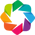

In [172]:
import numpy as np
import holoviews as hv
import pandas as pd
from bokeh.models import HoverTool
hv.extension('bokeh')

metadata = pd.read_csv("/home/minion/Downloads/Biller-data-metadata.tsv", sep= "\t")
bats = pd.read_csv("/home/minion/Desktop/sag_cellular/coverages/sar11_coverage_RPKM_combined.tsv", sep = "\t")
#bats = pd.melt(bats, id_vars=['contig'], var_name='new_name', value_name='RPKM')
#bats = bats.join(metadata.set_index('new_name'), on='new_name')
#bats = bats.sort_values("contig")

In [205]:
bats = pd.read_csv('/home/minion/Desktop/sag_cellular/all_sar11_viral_removed_bats_coverage_RPKM.tsv', sep = "\t")
bats = bats.sort_values("contig")
bats

contig  SRR5720234  SRR5720251  SRR5720233  SRR5720229  SRR5720237  \
0     AAAA    0.001801    0.000086    0.004119    0.002574    0.005098   
1     AAAB    0.026808    0.186678    0.328223    0.082627    0.242384   
2     AAAC    0.000940    0.126986    0.685189    0.003060    0.097041   
3     AAAD    0.028549    0.465187    0.433261    0.100702    0.279003   
4     AAAE    0.008605    0.060449    0.124544    0.041125    0.115065   
5     AAAF    0.004869    0.658581    0.361213    0.028931    0.138329   
6     AAAG    0.002050   13.251099    2.144553    0.018209    0.368523   
7     AAAH    0.000564    0.003461    0.005816    0.004558    0.004484   
8     AAAI    0.001237    0.001085    0.002352    0.005854    0.007154   
9     AAAJ    0.024032    0.001081    0.071738    0.058012    0.092084   
10    AAAK    0.002903   19.293465    3.042194    0.025828    0.519804   
11    AAAL    0.068153    0.245715    0.492599    0.166972    0.425992   
12    AAAM    0.005238    1.314082    0.792379    0.025876    0.244132   
13    AAAN    0.000376    0.102797    0.054146    0.002371    0.016572   
14    AAAO    0.048367    0.026777    0.094369    0.081165    0.114589   
15    AAAP    0.000587    0.013206    0.005779    0.004165    0.004600   
16    AAAQ    0.001035    0.028735    0.016867    0.003835    0.009373   
17    AAAR    0.000000    0.028767    0.064398    0.000135    0.015205   
18    AAAS    0.000576    0.050920    0.022500    0.003096    0.008172   
19    AAAT    0.002376    0.022725    0.030144    0.006370    0.021601   
20    AAAU    0.012081    0.003613    0.027103    0.025151    0.035659   
21    AAAV    0.000000    0.006876    0.002711    0.001606    0.002356   
22    AAAW    0.000589    0.034245    0.019609    0.002696    0.008709   
23    AAAX    0.000258    0.051229    0.028960    0.001834    0.012090   
24    AAAY    0.018144    0.391147    0.338956    0.074873    0.201726   
25    AAAZ    0.002765   15.128078    2.417868    0.021201    0.409226   
26    AABA    0.008084    0.026002    0.085434    0.032831    0.084035   
27    AABB    0.004351   14.320352    2.261298    0.016781    0.378881   
28    AABC    0.002352    0.029900    0.072569    0.002358    0.017938   
29    AABD    0.119674    0.000955    0.125008    0.239862    0.258331   
..     ...         ...         ...         ...         ...         ...   
421   AAQF    0.035413    0.000000    0.002705    0.031180    0.008215   
422   AAQG    0.003740    0.000000    0.000444    0.003370    0.000643   
423   AAQH    0.036111    0.000000    0.004898    0.034139    0.010473   
424   AAQI    0.059567    0.002520    0.011405    0.065213    0.028699   
425   AAQJ    0.208929    0.000420    0.003803    0.099890    0.011132   
426   AAQK    0.026531    0.004629    0.016752    0.029614    0.026618   
427   AAQL    0.003385    0.002435    0.003754    0.003142    0.004519   
428   AAQM    0.028544    0.000295    0.001023    0.028265    0.001760   
429   AAQN    0.008728    0.000316    0.003013    0.008180    0.003769   
430   AAQO    0.038450    0.001682    0.004697    0.037179    0.012944   
431   AAQP    0.005685    0.001914    0.002306    0.004264    0.002873   
432   AAQQ    0.035253    0.000000    0.002121    0.029014    0.006468   
433   AAQR    0.009440    0.000105    0.002822    0.010410    0.002505   
434   AAQS    0.032992    0.000000    0.001141    0.025440    0.003561   
435   AAQT    0.031069    0.000283    0.003190    0.031766    0.007551   
436   AAQU    0.031064    0.000595    0.002121    0.031423    0.005771   
437   AAQV    0.038806    0.009875    0.006302    0.021570    0.008418   
438   AAQW    0.065829    0.000308    0.006142    0.059341    0.017405   
439   AAQX    0.026570    0.000000    0.001080    0.024577    0.002869   
440   AAQY    0.003378    0.000066    0.001138    0.003809    0.000989   
441   AAQZ    0.038455    0.001326    0.004369    0.034749    0.007619   
442   AARA    0.068465    0.000449    0.002557    0.063336    0.008332   
443   AA

In [170]:
hover = HoverTool(tooltips=[
    ("Label", "@new_name"),
    ("Biller", "@biller"),
    ("Date Sampled", "@Date"),
    ("Depth(m)", "@Depth"),
    ("Ocean", "@Ocean"),
    ("Study", "@Location"),
    ("Longitude", "@Lon"),
    ("Latitude", "@Lat"),
    ("Cruise No.", "@cruise_id"),
    ("Cruise Loc", "@cruise_station"),
    ("RPKM", "@RPKM")
    ])

%opts HeatMap [invert_axes=True width=1575 height=9360 logz=True fontsize={'xticks': '8pt'} tools=[hover] colorbar=True toolbar='above' xrotation=90] (cmap='RdYlBu_r') 
bats_heatmap = hv.HeatMap(bats, on="contig", value = "ID", index = "RPKM")
hv.renderer('bokeh').save(bats_heatmap,'/home/minion/Desktop/sag_cellular/coverages/bats-heatmap')
bats_heatmap

:HeatMap   [contig,new_name]   (RPKM,biller,Date,Depth,Ocean,Location,Lon,Lat,cruise_id,cruise_station)

In [45]:
import pandas as pd
df = pd.read_csv("/home/minion/Desktop/coverages/sar11_coverage_RPKM_combined.tsv", sep = "\t")
df = df.sort_values("contig")
df.rename(columns={
'SRR5720219':'5m_Oct-2004',
'SRR5720220':'115m_Oct-2004',
'SRR5720221':'175m_Aug-2004',
'SRR5720222':'5m_Sep-2004',
'SRR5720223':'115m_Sep-2004',
'SRR5720224':'175m_Sep-2004',
'SRR5720225':'125m_Jun-2004',
'SRR5720226':'175m_Jun-2004',
'SRR5720227':'5m_Aug-2004',
'SRR5720228':'100m_Aug-2004',
'SRR5720229':'180m_Jul-2003',
'SRR5720230':'120m_Jul-2003',
'SRR5720231':'180m_Feb-2003',
'SRR5720232':'40m_Feb-2003',
'SRR5720233':'1m_Feb-2003',
'SRR5720234':'180m_Dec-2004',
'SRR5720235':'10m_Jul-2003',
'SRR5720236':'180m_Mar-2003',
'SRR5720237':'80m_Mar-2003',
'SRR5720238':'1m_Mar-2003',
'SRR5720239':'175m_Jan-2003',
'SRR5720240':'125m_Jan-2003',
'SRR5720241':'5m_Nov-2004',
'SRR5720242':'175m_Oct-2004',
'SRR5720243':'175m_Nov-2004',
'SRR5720244':'100m_Nov-2004',
'SRR5720245':'100m_Dec-2004',
'SRR5720246':'5m_Dec-2004',
'SRR5720247':'5m_Jan-2003',
'SRR5720248':'175m_Dec-2004',
'SRR5720249':'40m_Apr-2004',
'SRR5720250':'180m_Apr-2004',
'SRR5720251':'1m_Sep-2004',
'SRR5720252':'100m_Sep-2004',
'SRR5720253':'100m_Jun-2004',
'SRR5720254':'180m_Jun-2004',
'SRR5720255':'160m_Aug-2003',
'SRR5720256':'1m_Apr-2004',
'SRR5720257':'10m_May-2004',
'SRR5720258':'80m_May-2004',
'SRR5720259':'180m_May-2004',
'SRR5720260':'10m_Jun-2004',
'SRR5720261':'180m_Nov-2003',
'SRR5720262':'1m_Dec-2003',
'SRR5720263':'100m_Dec-2003',
'SRR5720264':'180m_Dec-2003',
'SRR5720265':'175m_Apr-2003',
'SRR5720266':'5m_May-2003',
'SRR5720267':'175m_Feb-2003',
'SRR5720268':'5m_Mar-2003',
'SRR5720269':'5m_Feb-2003',
'SRR5720270':'115m_Feb-2003',
'SRR5720271':'5m_Apr-2003',
'SRR5720272':'125m_Apr-2003',
'SRR5720273':'125m_Mar-2003',
'SRR5720274':'175m_Mar-2003',
'SRR5720275':'80m_Nov-2003',
'SRR5720276':'1m_Nov-2003',
'SRR5720277':'80m_Nov-2004',
'SRR5720278':'1m_Nov-2004',
'SRR5720279':'180m_Oct-2004',
'SRR5720280':'100m_Oct-2004',
'SRR5720281':'180m_May-2003',
'SRR5720282':'100m_May-2003',
'SRR5720283':'1m_May-2003',
'SRR5720284':'180m_Nov-2004',
'SRR5720285':'100m_Aug-2003',
'SRR5720286':'10m_Aug-2003',
'SRR5720287':'115m_Aug-2003',
'SRR5720288':'5m_Aug-2003',
'SRR5720289':'175m_Jul-2003',
'SRR5720290':'125m_Jul-2003',
'SRR5720291':'5m_Jul-2003',
'SRR5720292':'175m_Jun-2003',
'SRR5720293':'100m_Jun-2003',
'SRR5720294':'5m_Jun-2003',
'SRR5720295':'175m_May-2003',
'SRR5720296':'115m_May-2003',
'SRR5720297':'175m_May-2004',
'SRR5720298':'5m_Jun-2004',
'SRR5720299':'5m_Feb-2004',
'SRR5720300':'100m_Feb-2004',
'SRR5720301':'175m_Feb-2004',
'SRR5720302':'25m_Apr-2004',
'SRR5720303':'125m_Apr-2004',
'SRR5720304':'175m_Apr-2004',
'SRR5720305':'5m_May-2004',
'SRR5720306':'115m_May-2004',
'SRR5720307':'1m_Oct-2004',
'SRR5720308':'100m_Oct-2003',
'SRR5720309':'175m_Oct-2003',
'SRR5720310':'175m_Aug-2003',
'SRR5720311':'5m_Nov-2003',
'SRR5720312':'100m_Nov-2003',
'SRR5720313':'175m_Nov-2003',
'SRR5720314':'5m_Dec-2003',
'SRR5720315':'85m_Dec-2003',
'SRR5720316':'175m_Dec-2003',
'SRR5720317':'10m_Oct-2003',
'SRR5720318':'180m_Feb-2004',
'SRR5720319':'40m_Feb-2004',
'SRR5720320':'120m_Aug-2004',
'SRR5720321':'1m_Aug-2004',
'SRR5720322':'1m_Feb-2004',
'SRR5720323':'180m_Aug-2004',
'SRR5720324':'175m_Mar-2004',
'SRR5720325':'115m_Mar-2004',
'SRR5720326':'80m_Apr-2003',
'SRR5720327':'10m_Apr-2003',
'SRR5720328':'100m_Jan-2004',
'SRR5720329':'5m_Jan-2004',
'SRR5720330':'10m_Mar-2004',
'SRR5720331':'175m_Jan-2004',
'SRR5720332':'1m_Oct-2003',
'SRR5720333':'180m_Apr-2003',
'SRR5720334':'60m_Mar-2004',
'SRR5720335':'180m_Mar-2004',
'SRR5720336':'180m_Jan-2004',
'SRR5720337':'1m_Mar-2004',
'SRR5720338':'1m_Jan-2004',
'SRR5720339':'40m_Jan-2004',
'SRR5720340':'80m_Oct-2003',
'SRR5720341':'180m_Oct-2003',
'SRR5720342':'1m_Dec-2004',
'SRR5720343':'100m_Dec-2004',
'SRR5720344':'180m_Sep-2004',
'SRR5787989':'9m_Mar-2011',
'SRR5787990':'50m_Mar-2011',
'SRR5787991':'33m_Jun-2011',
'SRR5787992':'149m_Mar-2011',
'SRR5787993':'109.7m_Nov-2011',
'SRR5787994':'182.4m_Nov-2011',
'SRR5787995':'15m_May-2011',
'SRR5787996':'50m_May-2011',
'SRR5787997':'50m_May-2011',
'SRR5787998':'30m_May-2011',
'SRR5787999':'151m_May-2010',
'SRR5788000':'76m_May-2010',
'SRR5788001':'15m_May-2011',
'SRR5788002':'201m_May-2010',
'SRR5788003':'100m_May-2011',
'SRR5788004':'75m_May-2011',
'SRR5788005':'65.2m_Dec-2011',
'SRR5788006':'38.9m_Dec-2011',
'SRR5788007':'291.5m_Nov-2011',
'SRR5788008':'237.3m_Nov-2011',
'SRR5788009':'233m_Dec-2011',
'SRR5788010':'184m_Dec-2011',
'SRR5788011':'113.9m_Dec-2011',
'SRR5788012':'75.1m_Dec-2011',
'SRR5788013':'28.4m_Nov-2011',
'SRR5788014':'283.9m_Dec-2011',
'SRR5788015':'10m_Mar-2011',
'SRR5788016':'49m_Mar-2011',
'SRR5788017':'150m_Mar-2011',
'SRR5788018':'49m_Mar-2011',
'SRR5788019':'9m_Mar-2011',
'SRR5788020':'151m_Mar-2011',
'SRR5788021':'50m_Mar-2011',
'SRR5788022':'10m_Mar-2011',
'SRR5788023':'150m_Mar-2011',
'SRR5788024':'50m_Mar-2011',
'SRR5788025':'110.7m_Nov-2011',
'SRR5788026':'81.5m_Oct-2010',
'SRR5788027':'101.9m_Oct-2010',
'SRR5788028':'51.1m_Oct-2010',
'SRR5788029':'61.4m_Oct-2010',
'SRR5788030':'6.4m_Oct-2010',
'SRR5788031':'21.3m_Oct-2010',
'SRR5788032':'51.4m_Oct-2010',
'SRR5788033':'60.9m_Oct-2010',
'SRR5788034':'10m_Oct-2010',
'SRR5788035':'21.1m_Oct-2010',
'SRR5788036':'374.3m_Dec-2011',
'SRR5788037':'15m_May-2011',
'SRR5788038':'30m_May-2011',
'SRR5788039':'75m_May-2011',
'SRR5788040':'100m_May-2011',
'SRR5788041':'100m_May-2011',
'SRR5788042':'15m_May-2011',
'SRR5788043':'50m_May-2011',
'SRR5788044':'75m_May-2011',
'SRR5788045':'30m_May-2011',
'SRR5788046':'50m_May-2011',
'SRR5788047':'10m_Mar-2011',
'SRR5788048':'150m_Mar-2011',
'SRR5788049':'77m_Jun-2011',
'SRR5788050':'102m_Jun-2011',
'SRR5788051':'31m_Jun-2011',
'SRR5788052':'52m_Jun-2011',
'SRR5788053':'102m_Jun-2011',
'SRR5788054':'15m_Jun-2011',
'SRR5788055':'49m_Jun-2011',
'SRR5788056':'76m_Jun-2011',
'SRR5788057':'76m_Jun-2011',
'SRR5788058':'102m_Jun-2011',
'SRR5788059':'50m_Mar-2011',
'SRR5788060':'10m_Mar-2011',
'SRR5788061':'74.3m_Dec-2011',
'SRR5788062':'99.7m_Dec-2011',
'SRR5788063':'108.8m_Nov-2011',
'SRR5788064':'135.6m_Nov-2011',
'SRR5788065':'61.2m_Nov-2011',
'SRR5788066':'86.4m_Nov-2011',
'SRR5788067':'288.8m_Nov-2011',
'SRR5788068':'39.9m_Dec-2011',
'SRR5788069':'186.5m_Nov-2011',
'SRR5788070':'234.7m_Nov-2011',
'SRR5788071':'91.5m_Nov-2010',
'SRR5788072':'121.1m_Nov-2010',
'SRR5788073':'80.9m_Nov-2010',
'SRR5788074':'100.9m_Nov-2010',
'SRR5788075':'40.7m_Nov-2010',
'SRR5788076':'61.5m_Nov-2010',
'SRR5788077':'51.2m_Nov-2010',
'SRR5788078':'71.3m_Nov-2010',
'SRR5788079':'6.1m_Nov-2010',
'SRR5788080':'21.4m_Nov-2010',
'SRR5788081':'233.6m_Nov-2011',
'SRR5788082':'285m_Nov-2011',
'SRR5788083':'133.7m_Nov-2011',
'SRR5788084':'183.8m_Nov-2011',
'SRR5788085':'99m_Nov-2011',
'SRR5788086':'113.8m_Nov-2011',
'SRR5788087':'40.1m_Nov-2011',
'SRR5788088':'69.4m_Nov-2011',
'SRR5788089':'30.2m_Nov-2011',
'SRR5788090':'57.8m_Nov-2011',
'SRR5788091':'102m_Jun-2011',
'SRR5788092':'16m_Jun-2011',
'SRR5788093':'50m_Jun-2011',
'SRR5788094':'75m_Jun-2011',
'SRR5788095':'76m_Jun-2011',
'SRR5788096':'101m_Jun-2011',
'SRR5788097':'30m_Jun-2011',
'SRR5788098':'52m_Jun-2011',
'SRR5788099':'149m_Mar-2011',
'SRR5788100':'51m_Mar-2011',
'SRR5788101':'15m_Jun-2011',
'SRR5788102':'30m_Jun-2011',
'SRR5788103':'51m_Mar-2011',
'SRR5788104':'10m_Mar-2011',
'SRR5788105':'10m_Mar-2011',
'SRR5788106':'151m_Mar-2011',
'SRR5788107':'134.2m_Dec-2011',
'SRR5788108':'200m_Jun-2010',
'SRR5788109':'9m_May-2010',
'SRR5788110':'152m_Jun-2010',
'SRR5788111':'202m_Jun-2010',
'SRR5788112':'77m_Jun-2010',
'SRR5788113':'119m_Jun-2010',
'SRR5788114':'100m_Jun-2010',
'SRR5788115':'127m_Jun-2010',
'SRR5788116':'12m_Jun-2010',
'SRR5788117':'75m_Jun-2010',
'SRR5788118':'75m_Jun-2011',
'SRR5788119':'102m_Jun-2011',
'SRR5788120':'101m_Jun-2011',
'SRR5788121':'15m_Jun-2011',
'SRR5788122':'30m_Jun-2011',
'SRR5788123':'52m_Jun-2011',
'SRR5788124':'49m_Jun-2011',
'SRR5788125':'76m_Jun-2011',
'SRR5788126':'52m_Jun-2011',
'SRR5788127':'77m_Jun-2011',
'SRR5788128':'50m_Jun-2011',
'SRR5788129':'30m_Jun-2011',
'SRR5788130':'21.1m_Oct-2010',
'SRR5788131':'6.1m_Oct-2010',
'SRR5788132':'76m_Jun-2011',
'SRR5788133':'52m_Jun-2011',
'SRR5788134':'15m_Jun-2011',
'SRR5788135':'101m_Jun-2011',
'SRR5788136':'40.8m_Oct-2010',
'SRR5788137':'31.2m_Oct-2010',
'SRR5788138':'135.8m_Nov-2011',
'SRR5788139':'186.3m_Nov-2011',
'SRR5788140':'201m_Jun-2010',
'SRR5788141':'31.3m_Nov-2011',
'SRR5788142':'68m_Nov-2011',
'SRR5788143':'111.1m_Nov-2011',
'SRR5788144':'8m_Jun-2010',
'SRR5788145':'76m_Jun-2010',
'SRR5788146':'101m_Jun-2010',
'SRR5788147':'150m_Jun-2010',
'SRR5788148':'100m_Jun-2011',
'SRR5788149':'76m_Jun-2011',
'SRR5788150':'1008m_Jun-2011',
'SRR5788151':'202m_Jun-2011',
'SRR5788152':'15m_Jun-2011',
'SRR5788153':'5601m_Jun-2011',
'SRR5788154':'15m_May-2011',
'SRR5788155':'30m_Jun-2011',
'SRR5788156':'50m_May-2011',
'SRR5788157':'30m_May-2011',
'SRR5788158':'100m_Jun-2011',
'SRR5788159':'77m_Jun-2011',
'SRR5788160':'15m_Jun-2011',
'SRR5788161':'101m_Jun-2011',
'SRR5788162':'51m_Jun-2011',
'SRR5788163':'32m_Jun-2011',
'SRR5788164':'30m_Jun-2011',
'SRR5788165':'14m_Jun-2011',
'SRR5788166':'74m_Jun-2011',
'SRR5788167':'51m_Jun-2011',
'SRR5788168':'185.4m_Nov-2010',
'SRR5788169':'2m_Nov-2010',
'SRR5788170':'101m_Jun-2011',
'SRR5788171':'14m_Jun-2011',
'SRR5788172':'50.4m_Nov-2010',
'SRR5788173':'71.9m_Nov-2010',
'SRR5788174':'91.6m_Nov-2010',
'SRR5788175':'136.5m_Nov-2010',
'SRR5788176':'31m_Jun-2011',
'SRR5788177':'51m_Jun-2011',
'SRR5788178':'16m_Jun-2011',
'SRR5788179':'102m_Jun-2011',
'SRR5788180':'149m_Mar-2011',
'SRR5788181':'10m_Mar-2011',
'SRR5788182':'10m_Mar-2011',
'SRR5788183':'50m_Mar-2011',
'SRR5788184':'50m_Mar-2011',
'SRR5788185':'135m_Mar-2011',
'SRR5788186':'143m_Mar-2011',
'SRR5788187':'10m_Mar-2011',
'SRR5788188':'49m_Mar-2011',
'SRR5788189':'149m_Mar-2011',
'SRR5788190':'50m_Mar-2011',
'SRR5788191':'15m_Jun-2011',
'SRR5788192':'9m_Jun-2010',
'SRR5788193':'200m_Jun-2010',
'SRR5788194':'100m_Jun-2010',
'SRR5788195':'72m_Jun-2010',
'SRR5788196':'75m_Jun-2010',
'SRR5788197':'9m_Jun-2010',
'SRR5788198':'150m_Jun-2010',
'SRR5788199':'99m_Jun-2010',
'SRR5788200':'201m_Jun-2010',
'SRR5788201':'151m_Jun-2010',
'SRR5788202':'21.1m_Nov-2010',
'SRR5788203':'6.3m_Nov-2010',
'SRR5788204':'183.8m_Dec-2011',
'SRR5788205':'101.9m_Oct-2010',
'SRR5788206':'76.2m_Oct-2010',
'SRR5788207':'21.2m_Nov-2010',
'SRR5788208':'6m_Nov-2010',
'SRR5788209':'60.9m_Nov-2010',
'SRR5788210':'41.3m_Nov-2010',
'SRR5788211':'101.1m_Nov-2010',
'SRR5788212':'71.6m_Nov-2010',
'SRR5788213':'300.8m_Dec-2011',
'SRR5788214':'234.1m_Dec-2011',
'SRR5788215':'499.6m_Dec-2011',
'SRR5788216':'39.4m_Nov-2011',
'SRR5788217':'285.9m_Nov-2011',
'SRR5788218':'90.8m_Nov-2011',
'SRR5788219':'65.6m_Nov-2011',
'SRR5788220':'109.9m_Nov-2011',
'SRR5788221':'89.2m_Nov-2011',
'SRR5788222':'185.8m_Nov-2011',
'SRR5788223':'135.4m_Nov-2011',
'SRR5788224':'41.8m_Nov-2011',
'SRR5788225':'135.6m_Nov-2011',
'SRR5788226':'135.2m_Nov-2011',
'SRR5788227':'111.1m_Nov-2011',
'SRR5788228':'1055.2m_Dec-2011',
'SRR5788229':'100m_May-2010',
'SRR5788230':'73m_May-2010',
'SRR5788231':'199m_May-2010',
'SRR5788232':'152m_May-2010',
'SRR5788233':'49m_May-2010',
'SRR5788234':'10m_May-2010',
'SRR5788235':'50m_May-2010',
'SRR5788236':'10m_May-2010',
'SRR5788237':'101m_May-2010',
'SRR5788238':'75m_May-2010',
'SRR5788239':'17m_Jun-2011',
'SRR5788240':'32m_Jun-2011',
'SRR5788241':'103m_Jun-2011',
'SRR5788242':'203m_Jun-2011',
'SRR5788243':'1012m_Jun-2011',
'SRR5788244':'4580m_Jun-2011',
'SRR5788245':'16m_Jun-2011',
'SRR5788246':'32m_Jun-2011',
'SRR5788247':'51m_Jun-2011',
'SRR5788248':'75m_Jun-2011',
'SRR5788249':'233.3m_Nov-2011',
'SRR5788250':'281.4m_Nov-2011',
'SRR5788251':'414.2m_Nov-2011',
'SRR5788252':'39.7m_Nov-2011',
'SRR5788253':'60.7m_Nov-2011',
'SRR5788254':'89.9m_Nov-2011',
'SRR5788255':'73m_Jun-2011',
'SRR5788256':'51m_May-2010',
'SRR5788257':'15m_Jun-2011',
'SRR5788258':'100m_Jun-2011',
'SRR5788259':'49m_Jun-2011',
'SRR5788260':'32m_Jun-2011',
'SRR5788261':'102m_Jun-2011',
'SRR5788262':'72m_Jun-2011',
'SRR5788263':'32m_Jun-2011',
'SRR5788264':'15m_Jun-2011',
'SRR5788265':'1000m_May-2011',
'SRR5788266':'75m_May-2011',
'SRR5788267':'100m_May-2011',
'SRR5788268':'15m_May-2011',
'SRR5788269':'30m_May-2011',
'SRR5788270':'50m_May-2011',
'SRR5788271':'100m_May-2011',
'SRR5788272':'1000m_May-2011',
'SRR5788273':'15m_Jun-2011',
'SRR5788274':'30m_Jun-2011',
'SRR5788275':'15m_May-2011',
'SRR5788276':'30m_May-2011',
'SRR5788277':'50m_May-2011',
'SRR5788278':'75m_May-2011',
'SRR5788279':'50m_Jun-2011',
'SRR5788280':'75m_Jun-2011',
'SRR5788281':'202m_Jun-2010',
'SRR5788282':'150m_Jun-2010',
'SRR5788283':'75m_May-2010',
'SRR5788284':'50m_May-2010',
'SRR5788285':'152m_May-2010',
'SRR5788286':'101m_May-2010',
'SRR5788287':'10m_Jun-2010',
'SRR5788288':'201m_May-2010',
'SRR5788289':'100m_Jun-2010',
'SRR5788290':'75m_Jun-2010',
'SRR5788291':'15m_May-2011',
'SRR5788292':'100m_May-2011',
'SRR5788293':'76m_Jun-2011',
'SRR5788294':'50m_Jun-2011',
'SRR5788295':'30m_Jun-2011',
'SRR5788296':'15m_Jun-2011',
'SRR5788297':'75m_May-2011',
'SRR5788298':'50m_May-2011',
'SRR5788299':'30m_May-2011',
'SRR5788300':'15m_May-2011',
'SRR5788301':'75m_May-2011',
'SRR5788302':'6.3m_Oct-2010',
'SRR5788303':'21.6m_Oct-2010',
'SRR5788304':'51.2m_Oct-2010',
'SRR5788305':'66.3m_Oct-2010',
'SRR5788306':'81.4m_Oct-2010',
'SRR5788307':'101.9m_Oct-2010',
'SRR5788308':'6m_Oct-2010',
'SRR5788309':'21.4m_Oct-2010',
'SRR5788310':'50.9m_Oct-2010',
'SRR5788311':'61.4m_Oct-2010',
'SRR5788312':'89.1m_Nov-2011',
'SRR5788313':'75.7m_Nov-2011',
'SRR5788314':'160m_Nov-2011',
'SRR5788315':'232.9m_Nov-2011',
'SRR5788316':'64.6m_Nov-2011',
'SRR5788317':'89.6m_Nov-2011',
'SRR5788318':'111.1m_Nov-2011',
'SRR5788319':'139.6m_Nov-2011',
'SRR5788320':'184.1m_Nov-2011',
'SRR5788321':'236.7m_Nov-2011',
'SRR5788322':'285.3m_Nov-2011',
'SRR5788323':'39.6m_Nov-2011',
'SRR5788324':'50m_Jun-2011',
'SRR5788325':'52m_Jun-2011',
'SRR5788326':'78m_Jun-2011',
'SRR5788327':'201m_Jun-2011',
'SRR5788328':'1008m_Jun-2011',
'SRR5788329':'5095m_Jun-2011',
'SRR5788330':'15m_Jun-2011',
'SRR5788331':'75m_Jun-2011',
'SRR5788332':'101m_Jun-2011',
'SRR5788333':'14m_Jun-2011',
'SRR5788334':'31m_Jun-2011',
'SRR5788335':'51.8m_Oct-2010',
'SRR5788336':'2m_Oct-2010',
'SRR5788337':'349m_Oct-2010',
'SRR5788338':'201.1m_Oct-2010',
'SRR5788339':'185m_Oct-2010',
'SRR5788340':'140.7m_Oct-2010',
'SRR5788341':'101m_Oct-2010',
'SRR5788342':'86.6m_Oct-2010',
'SRR5788343':'31.8m_Nov-2010',
'SRR5788344':'2m_Oct-2010',
'SRR5788345':'150m_Mar-2011',
'SRR5788346':'51m_Mar-2011',
'SRR5788347':'10m_Mar-2011',
'SRR5788348':'150m_Mar-2011',
'SRR5788349':'11m_Mar-2011',
'SRR5788350':'49m_Mar-2011',
'SRR5788351':'149m_Mar-2011',
'SRR5788352':'65m_Mar-2011',
'SRR5788353':'61m_Mar-2011',
'SRR5788354':'9m_Mar-2011',
'SRR5788355':'30m_May-2011',
'SRR5788356':'50m_May-2011',
'SRR5788357':'100m_May-2011',
'SRR5788358':'15m_May-2011',
'SRR5788359':'50m_May-2011',
'SRR5788360':'75m_May-2011',
'SRR5788361':'15m_May-2011',
'SRR5788362':'30m_May-2011',
'SRR5788363':'75m_May-2011',
'SRR5788364':'100m_May-2011',
'SRR5788365':'77m_May-2010',
'SRR5788366':'103m_May-2010',
'SRR5788367':'10m_May-2010',
'SRR5788368':'50m_May-2010',
'SRR5788369':'151m_May-2010',
'SRR5788370':'201m_May-2010',
'SRR5788371':'75m_May-2010',
'SRR5788372':'103m_May-2010',
'SRR5788373':'152m_May-2010',
'SRR5788374':'199m_May-2010',
'SRR5788375':'8m_Jun-2010',
'SRR5788376':'76m_Jun-2010',
'SRR5788377':'87m_Jun-2010',
'SRR5788378':'150m_Jun-2010',
'SRR5788379':'200m_Jun-2010',
'SRR5788380':'49m_Mar-2011',
'SRR5788381':'151m_Mar-2011',
'SRR5788382':'10m_Mar-2011',
'SRR5788383':'149m_Mar-2011',
'SRR5788384':'11m_Mar-2011',
'SRR5788385':'103m_Jun-2011',
'SRR5788386':'75m_Jun-2011',
'SRR5788387':'9m_May-2010',
'SRR5788388':'100m_May-2011',
'SRR5788389':'75m_May-2011',
'SRR5788390':'50m_May-2011',
'SRR5788391':'30m_May-2011',
'SRR5788392':'52m_Jun-2011',
'SRR5788393':'32m_Jun-2011',
'SRR5788394':'16m_Jun-2011',
'SRR5788395':'1000m_May-2011',
'SRR5788396':'15m_May-2011',
'SRR5788397':'100m_May-2011',
'SRR5788398':'75m_May-2011',
'SRR5788399':'50m_May-2011',
'SRR5788400':'30m_May-2011',
'SRR5788401':'15m_May-2011',
'SRR5788402':'100m_May-2011',
'SRR5788403':'75m_May-2011',
'SRR5788404':'100m_May-2011',
'SRR5788405':'50m_May-2011',
'SRR5788406':'30m_May-2011',
'SRR5788407':'183.7m_Dec-2011',
'SRR5788408':'135m_Dec-2011',
'SRR5788409':'89.3m_Dec-2011',
'SRR5788410':'71.6m_Dec-2011',
'SRR5788411':'48.1m_Dec-2011',
'SRR5788412':'284.8m_Nov-2011',
'SRR5788413':'234.8m_Nov-2011',
'SRR5788414':'185.7m_Nov-2011',
'SRR5788415':'100m_Jun-2011',
'SRR5788416':'75m_Jun-2011',
'SRR5788417':'50m_Jun-2011',
'SRR5788418':'100m_Jun-2011',
'SRR5788419':'17m_Jun-2011',
'SRR5788420':'5100m_Jun-2011',
'SRR5788421':'1023m_Jun-2011',
'SRR5788422':'204m_Jun-2011',
'SRR5788423':'51m_Jun-2011',
'SRR5788424':'31m_Jun-2011',
'SRR5788425':'285.9m_Dec-2011',
'SRR5788426':'234.5m_Dec-2011',
'SRR5788427':'52m_May-2010',
'SRR5788428':'10m_May-2010',
'SRR5788429':'199m_May-2010',
'SRR5788430':'151m_May-2010',
'SRR5788431':'102m_May-2010',
'SRR5788432':'74m_May-2010',
'SRR5788433':'50m_May-2010',
'SRR5788434':'8m_May-2010',
'SRR5788435':'198m_May-2010',
'SRR5788436':'153m_May-2010',
'SRR5788437':'101.9m_Oct-2010',
'SRR5788438':'62m_Oct-2010',
'SRR5788439':'52.1m_Oct-2010',
'SRR5788440':'42.2m_Oct-2010',
'SRR5788441':'21.4m_Oct-2010',
'SRR5788442':'6.5m_Oct-2010',
'SRR5788443':'101m_Oct-2010',
'SRR5788444':'81.5m_Oct-2010',
'SRR5788445':'59.8m_Oct-2010',
'SRR5788446':'50.2m_Oct-2010',
'SRR5788447':'11m_Jun-2010',
'SRR5788448':'389.4m_Dec-2011',
'SRR5788449':'84m_Dec-2011',
'SRR5788450':'74.5m_Dec-2011',
'SRR5788451':'50m_Dec-2011',
'SRR5788452':'284.7m_Nov-2011',
'SRR5788453':'283.3m_Dec-2011',
'SRR5788454':'233.1m_Dec-2011',
'SRR5788455':'183.9m_Dec-2011',
'SRR5788456':'123.8m_Dec-2011',
'SRR5788457':'28m_Jun-2011',
'SRR5788458':'15m_Jun-2011',
'SRR5788459':'102m_Jun-2011',
'SRR5788460':'76m_Jun-2011',
'SRR5788461':'48m_Jun-2011',
'SRR5788462':'30m_Jun-2011',
'SRR5788463':'72.9m_Oct-2010',
'SRR5788464':'151.8m_Oct-2010',
'SRR5788465':'33.2m_Oct-2010',
'SRR5788466':'57.7m_Oct-2010',
'SRR5788467':'148m_Mar-2011',
'SRR5788468':'11m_Mar-2011',
'SRR6507277':'5m_Aug-2009',
'SRR6507278':'100m_Nov-2009',
'SRR6507279':'10m_Jul-2009',
'SRR6507280':'100m_Nov-2009'}, inplace = True)

df = df[['contig',
 '1m_Feb-2003',
 '1m_Mar-2003',
 '1m_May-2003',
 '1m_Oct-2003',
 '1m_Nov-2003',
 '1m_Dec-2003',
 '1m_Jan-2004',
 '1m_Feb-2004',
 '1m_Mar-2004',
 '1m_Apr-2004',
 '1m_Aug-2004',
 '1m_Sep-2004',
 '1m_Oct-2004',
 '1m_Nov-2004',
 '1m_Dec-2004',
 '10m_Apr-2003',
 '10m_Jul-2003',
 '10m_Aug-2003',
 '10m_May-2004',
 '10m_Jun-2004',
 '10m_Jul-2009',
 '40m_Feb-2003',
 '40m_Jan-2004',
 '40m_Feb-2004',
 '40m_Apr-2004',
 '60m_Mar-2004',
 '80m_Mar-2003',
 '80m_Apr-2003',
 '80m_Oct-2003',
 '80m_Nov-2003',
 '80m_May-2004',
 '80m_Nov-2004',
 '100m_May-2003',
 '100m_Aug-2003',
 '100m_Dec-2003',
 '100m_Jun-2004',
 '100m_Sep-2004',
 '100m_Oct-2004',
 '100m_Dec-2004',
 '100m_Nov-2009',
 '120m_Jul-2003',
 '120m_Aug-2004',
 '160m_Aug-2003',
 '180m_Feb-2003',
 '180m_Mar-2003',
 '180m_Apr-2003',
 '180m_May-2003',
 '180m_Jul-2003',
 '180m_Oct-2003',
 '180m_Nov-2003',
 '180m_Dec-2003',
 '180m_Jan-2004',
 '180m_Feb-2004',
 '180m_Mar-2004',
 '180m_Apr-2004',
 '180m_May-2004',
 '180m_Jun-2004',
 '180m_Aug-2004',
 '180m_Sep-2004',
 '180m_Oct-2004',
 '180m_Nov-2004',
 '180m_Dec-2004'
]]

In [47]:
df.to_csv("/home/minion/Desktop/coverages/sar11_coverage_RPKM_combined.tsv", sep = "\t", index = None)